<a href="https://colab.research.google.com/github/Alvin7-boys/TA_Deep_Learning/blob/main/Kode_TA_1121061_Alvin_Boys_Gea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Library

In [ ]:
# # Take file from Google drive
from google.colab import drive
drive.mount('/content/drive')

# Read CSV
import pandas as pd

# Import TensorFlow
import tensorflow as tf
from tensorflow.python.keras import layers

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Matplotlib
import matplotlib.pyplot as plt

# Numpy
import numpy as np

# OS
import os

# Time
from datetime import datetime
import time

# Url Parse
from urllib.parse import urlparse

# GUI
!pip install flask
!pip install flask_ngrok
!pip install pyngrok
from flask import Flask, render_template, request, jsonify
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok


Mounted at /content/drive


## Set Seed

For reproducibility so the result will always be the same every re-run

In [ ]:
# Set Global Seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## Mengatur lebar output

In [ ]:
# Mengatur agar seluruh isi kolom ditampilkan tanpa terpotong
pd.set_option('display.max_colwidth', None)

# 2. Classes


## Class DataFrame

In [ ]:
class DataFrame:

    # Load dataframe dari Google Drive
    def load_from_drive(self, filename):
        """
        Memuat dataframe dari direktori di Google Drive.

        Parameter:
            filename (str): Nama file CSV tanpa ekstensi.

        Returns:
            pd.DataFrame: Dataframe yang dimuat dari drive.
        """
        return pd.read_csv(f"/content/drive/MyDrive/DatasetTA/{filename}.csv")

    # Save dataframe ke Google Drive
    def save_to_drive(self, df, filename):
        """
        Menyimpan dataframe ke direktori di Google Drive.

        Parameter:
            df (pd.DataFrame): Dataframe yang akan disimpan.
            filename (str): Nama file CSV tanpa ekstensi.
        """
        df.to_csv(f"/content/drive/MyDrive/DatasetTA/{filename}.csv", index=False)
        print("Dataframe saved to drive!")

    # Split data menjadi training dan testing
    def split_train_val_test(self, features, labels, test_size=0.3):
        """
        Membagi dataset menjadi data training, validation, dan testing.

        Parameters:
            features (pd.Series or pd.DataFrame): Kolom data (fitur).
            labels (pd.Series): Kolom label terkait.
            test_size (float): Proporsi data untuk testing (0-1).
            val_size (float): Proporsi data untuk validation dari total dataset (0-1).

        Returns:
            tuple: Tiga tuple berisi (fitur, label) untuk training, validation, dan testing.
        """
        # Split data menjadi data sementara (training + validation) dan testing
        x_train, x_test, y_train, y_test = train_test_split(
            features,
            labels,
            test_size=test_size,
            stratify=labels,
            random_state=42,
            shuffle=True
        )

        return (x_train, y_train), (x_test, y_test)

## Class TokenAnalyzer

In [ ]:
class TokenAnalyzer:
    """
    Class untuk melakukan analisis distribusi token pada dataset URL yang telah di-encode.
    """

    @staticmethod
    def average_token_length(encoded_urls):
        """
        Menghitung rata-rata panjang token dalam dataset URL yang telah di-encode.

        Parameter:
            encoded_urls (list of list of int): Sebuah daftar di mana setiap elemen adalah daftar token
                                                yang merepresentasikan URL yang telah di-encode.

        Returns:
            float: Rata-rata panjang token dalam dataset.
        """
        # Hitung panjang setiap encoded URL
        token_lengths = [len(url) for url in encoded_urls]

        # Hitung rata-rata panjang token
        average_length = sum(token_lengths) / len(token_lengths)
        return average_length

    @staticmethod
    def plot_distribution(encoded_urls):
        """
        Membuat plot distribusi jumlah token dalam dataset URL yang telah di-encode.

        Parameter:
            encoded_urls (list of list of int): Sebuah daftar di mana setiap elemen adalah daftar token
                                                yang merepresentasikan URL yang telah di-encode.
        """

        token_counts = [len(url) for url in encoded_urls]
        bins = [0, 40, 80, 120, 160, 200, 240, 280, 320, 360, 400]
        plt.hist(token_counts, bins=bins, alpha=0.7, color='blue', edgecolor='black')
        plt.xlabel('Token Count')
        plt.ylabel('Frequency')
        plt.title('Distribution of Token Counts in Encoded URLs')
        plt.xticks(bins)
        plt.xlim(0, 400)
        plt.show()

## Class Prepocessing

In [ ]:
class Preprocessing:

    def tokenization(self, url):
        """
        Memecah URL menjadi list karakter.

        Parameter:
            url (str): URL yang akan di-tokenisasi.

        Returns:
            list: Daftar karakter dari URL.
        """
        return list(url)

    def encode(self, tokenized_url):
        """
        Melakukan encoding URL yang telah di-tokenisasi menjadi representasi integer.

        Parameter:
            tokenized_url (list): Daftar karakter hasil tokenisasi URL.

        Returns:
            list: Daftar nilai integer yang merepresentasikan setiap karakter.
        """
        # Definisikan character dictionary (char_to_index)
        char_to_index = {
            **{chr(i): i - 96 for i in range(97, 123)},  # a-z -> 1-26
            **{chr(i): i - 38 for i in range(65, 91)},   # A-Z -> 27-52
            **{str(i): i + 52 for i in range(10)},       # 0-9 -> 53-62
            **{char: idx for idx, char in enumerate(".,!?:'/@#$%&*+=<>[]{}^()\"\\", start=63)},  # Punctuation -> 63-94
            'UNK': 95,                                   # Unknown character
            'DEFAULT': 0                                 # Default (padding or other cases)
        }

        # Integer encoding dengan default ke 'UNK' jika karakter tidak ada di kamus
        return [char_to_index.get(char, char_to_index['UNK']) for char in tokenized_url]

    def padding_truncating(self, normalized_data, max_length=50, padding_value=0):
        """
        Melakukan padding atau truncating pada encoded URL agar sesuai dengan panjang tetap.

        Parameter:
            encoded_url (list): URL yang telah di-encode dalam bentuk integer.
            max_length (int): Panjang maksimum URL setelah padding atau truncating.
            padding_value (int): Nilai padding yang akan digunakan.

        Returns:
            list: URL yang telah diproses dengan padding atau truncating.
        """
        # Jika panjangnya lebih dari max_length, truncate
        if len(normalized_data) > max_length:
            return normalized_data[:max_length]
        # Jika kurang dari max_length, tambahkan padding
        else:
            return normalized_data + [padding_value] * (max_length - len(normalized_data))

## Class CNN-Attention-Model


In [ ]:
class CNN_Attention_Model:
    def __init__(self, vocab_size=96, embedding_dim=128, input_length=50):
        """
        Inisialisasi model dengan parameter utama.

        Parameters:
            vocab_size (int): Jumlah kata atau karakter unik dalam data (ukuran kosakata).
            embedding_dim (int): Dimensi dari embedding yang digunakan untuk representasi kata/karakter.
            input_length (int): Panjang maksimal input sequence.
        """
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length

    def character_url_embedding(self):
        """
        Membuat embedding layer untuk karakter URL.

        Returns:
            tf.keras.layers.Embedding: Embedding layer.
        """
        return tf.keras.layers.Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            trainable=True
        )

    def positional_encoding(self):
        """
        Membuat positional encoding untuk input sequence.

        Returns:
            tf.Tensor: Positional encoding dengan bentuk (1, input_length, embedding_dim).
        """
        position = np.arange(self.input_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.embedding_dim, 2) * -(np.log(10000.0) / self.embedding_dim))

        pos_encoding = np.zeros((self.input_length, self.embedding_dim))
        pos_encoding[:, 0::2] = np.sin(position * div_term)  # Elemen genap
        pos_encoding[:, 1::2] = np.cos(position * div_term)  # Elemen ganjil

        return tf.constant(pos_encoding[np.newaxis, ...], dtype=tf.float32)

    def attention_block(self, input_tensor, num_heads=8, hidden_dim=64):
        """
        Blok attention untuk memperhatikan hubungan antar elemen dalam sequence.

        Parameters:
            input_tensor (tf.Tensor): Input tensor.
            num_heads (int): Jumlah "heads" pada Multi-Head Attention.
            hidden_dim (int): Dimensi hidden layer setelah attention.

        Returns:
            tf.Tensor: Output dari blok attention dengan residual connection.
        """
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=input_tensor.shape[-1]
        )(input_tensor, input_tensor)

        residual_1 = tf.keras.layers.Add()([input_tensor, attention_output])

        # Dense layer tanpa regularisasi
        dense_output = tf.keras.layers.Dense(hidden_dim, activation=None)(residual_1)

        residual_1_projected = tf.keras.layers.Dense(hidden_dim)(residual_1)

        residual_2 = tf.keras.layers.Add()([residual_1_projected, dense_output])

        return residual_2

    def feature_block(self, input_tensor, kernel_size=3, num_kernels=5, hidden_dim=64):
        """
        Blok feature extraction menggunakan Convolutional Layer.

        Parameters:
            input_tensor (tf.Tensor): Input tensor.
            kernel_size (int): Ukuran kernel pada Conv1D.
            num_kernels (int): Jumlah filter pada Conv1D.
            hidden_dim (int): Dimensi hidden layer.

        Returns:
            tf.Tensor: Output dari blok feature extraction dengan residual connection.
        """
        conv_output = tf.keras.layers.Conv1D(
            filters=num_kernels,
            kernel_size=kernel_size,
            activation=None,
            padding="same"
        )(input_tensor)

        conv_output_projected = tf.keras.layers.Conv1D(
            filters=input_tensor.shape[-1],
            kernel_size=1,
            activation=None,
            padding="same"
        )(conv_output)

        residual_1 = tf.keras.layers.Add()([input_tensor, conv_output_projected])

        dense_output = tf.keras.layers.Dense(hidden_dim, activation="relu")(residual_1)

        residual_1_projected = tf.keras.layers.Dense(hidden_dim)(residual_1)

        residual_2 = tf.keras.layers.Add()([residual_1_projected, dense_output])

        return residual_2

    def output_block(self, a_output, f_output, num_heads=8):
        """
        Blok output untuk menghasilkan prediksi akhir.

        Parameters:
            a_output (tf.Tensor): Output dari blok attention.
            f_output (tf.Tensor): Output dari blok feature.
            num_heads (int): Jumlah "heads" pada Multi-Head Attention.

        Returns:
            tf.Tensor: Output prediksi dengan aktivasi sigmoid (untuk klasifikasi biner).
        """
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=a_output.shape[-1]
        )(query=a_output, key=a_output, value=f_output)

        residual_output = tf.keras.layers.Add()([attention_output, f_output])

        flattened_output = tf.keras.layers.Flatten()(residual_output)
        dense_output = tf.keras.layers.Dense(64, activation="relu")(flattened_output)
        output = tf.keras.layers.Dense(1, activation="sigmoid")(dense_output)

        return output

    def build_model(self):
        """
        Membuat model dengan embedding, positional encoding, attention, feature, dan output blocks.

        Returns:
            tf.keras.Model: Model CNN Attention yang sudah terbangun.
        """
        inputs = tf.keras.Input(shape=(self.input_length,))

        embedding_layer = self.character_url_embedding()
        embedded_input = embedding_layer(inputs)
        pos_encoding = self.positional_encoding()
        embedded_with_position = embedded_input + pos_encoding

        a_output = self.attention_block(embedded_with_position)
        f_output = self.feature_block(embedded_with_position)

        outputs = self.output_block(a_output, f_output)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model


## Class CNN_Attention_Classifier

In [ ]:
class CNN_Attention_Classifier:
    def __init__(self, model, embedding_dim, batch_size, learning_rate, num_epochs,
                 model_dir="/content/drive/MyDrive/Model/",
                 log_dir="/content/drive/MyDrive/Log/"):
        """
        Inisialisasi trainer dengan hyperparameter dan model.
        """
        self.model = model
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.model_dir = model_dir
        self.log_path = os.path.join(log_dir, "training_log.csv")
        self.evaluation_log_path = os.path.join(log_dir, "evaluation_log.csv")

        # Pastikan direktori model dan log ada
        os.makedirs(self.model_dir, exist_ok=True)
        os.makedirs(log_dir, exist_ok=True)

        # Pemeriksaan perangkat
        if tf.config.list_physical_devices('GPU'):
            self.device_name = '/device:GPU:0'
            print("GPU detected. Using GPU for training.")
        else:
            self.device_name = '/cpu:0'
            print("No GPU detected. Using CPU for training.")

    def train(self, x_train, y_train):
        """
        Melatih model dan menyimpan log pelatihan setiap epoch.
        Menyimpan model setiap 2 epoch.
        """
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

        with tf.device(self.device_name):
            for epoch in range(1, self.num_epochs + 1):
                print("=" * 60)
                print(f"Epoch {epoch}/{self.num_epochs}")
                print("=" * 60)

                start_time = time.time()
                history = self.model.fit(
                    x_train, y_train,
                    validation_split=0.2,
                    epochs=1,
                    batch_size=self.batch_size,
                    verbose=1,
                )
                end_time = time.time()

                # Ambil metrik pelatihan dari history
                train_loss = history.history['loss'][0]
                train_accuracy = history.history['accuracy'][0]
                val_loss = history.history['val_loss'][0]
                val_accuracy = history.history['val_accuracy'][0]
                runtime = end_time - start_time

                # Simpan log
                self.save_log(epoch, train_loss, train_accuracy, val_loss, val_accuracy, runtime)

                # Simpan model setiap 2 epoch
                if epoch % 2 == 0 or epoch == self.num_epochs:
                    self.save_model(epoch)

    def save_model(self, epoch):
        """
        Menyimpan model dalam format .keras dengan nama file yang mencerminkan hyperparameter.
        """
        model_file = os.path.join(
            self.model_dir,
            f"cnn_attention_ed({self.embedding_dim})_lr({self.learning_rate})_bs({self.batch_size})_epoch({epoch}).keras"
        )
        self.model.save(model_file)
        print(f"\nModel saved: {model_file}\n")

    def save_log(self, epoch, train_loss, train_accuracy, val_loss, val_accuracy, runtime):
        """
        Menyimpan log pelatihan setiap epoch.
        """
        log_exists = os.path.isfile(self.log_path)

        log_data = pd.DataFrame([[
            epoch, self.embedding_dim, self.batch_size, self.learning_rate,
            train_loss, train_accuracy, val_loss, val_accuracy, runtime
        ]], columns=[
            "Epoch", "Embedding Dim", "Batch Size", "Learning Rate",
            "Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy",
            "Runtime (s)"
        ])

        if log_exists:
            log_data.to_csv(self.log_path, mode='a', header=False, index=False)
        else:
            log_data.to_csv(self.log_path, index=False)

        print(f"\nTraining log saved at {self.log_path}\n")

    def evaluate_models(self, x_test, y_test):
        """
        Mengevaluasi semua model yang disimpan dengan nama berdasarkan kelipatan epoch.
        """
        # Cari semua model yang sesuai dengan pola nama dan urutkan berdasarkan epoch
        saved_models = sorted(
            [f for f in os.listdir(self.model_dir)
             if f.startswith(f"cnn_attention_ed({self.embedding_dim})_lr({self.learning_rate})_bs({self.batch_size})") and f.endswith('.keras')],
            key=lambda x: int(x.split("epoch(")[1].split(")")[0])  # Ekstrak nomor epoch untuk pengurutan
        )

        for model_name in saved_models:
            epoch_number = int(model_name.split("epoch(")[1].split(")")[0])  # Ekstrak nomor epoch

            # Hanya evaluasi model pada epoch yang merupakan kelipatan
            if epoch_number % 2 == 0 or epoch_number == self.num_epochs:
                model_path = os.path.join(self.model_dir, model_name)

                print(f"\nLoading model: {model_name}")
                model = tf.keras.models.load_model(model_path)

                # Prediksi hasil
                predictions = model.predict(x_test, verbose=0)
                y_pred = (predictions > 0.5).astype(int).flatten()

                # Hitung metrik evaluasi
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average="binary")
                recall = recall_score(y_test, y_pred, average="binary")

                # Confusion Matrix
                cm = confusion_matrix(y_test, y_pred)
                print(f"\nResult Evaluation for {model_name}:\n")
                print(cm)
                print(f"\nAccuracy: {accuracy:.4f}")
                print(f"Precision: {precision:.4f}")
                print(f"Recall: {recall:.4f}")
                print("-" * 60)

                # Simpan hasil evaluasi ke log langsung di setiap iterasi
                log_exists = os.path.isfile(self.evaluation_log_path)

                log_data = pd.DataFrame([[
                    model_name, accuracy, precision, recall
                ]], columns=[
                    "Model Name", "Accuracy", "Precision", "Recall"
                ])

                if log_exists:
                    log_data.to_csv(self.evaluation_log_path, mode='a', header=False, index=False)
                else:
                    log_data.to_csv(self.evaluation_log_path, index=False)

                print(f"Log updated at {self.evaluation_log_path}")
                print("-" * 60, "\n")



## Class Main

In [ ]:
class Main:
    # Constructor, initialize hyperparameters used
    def __init__(self, embedding_dim, batch_sizes, learning_rates, num_epochs):
        """
        Inisialisasi hyperparameter utama yang akan digunakan dalam model.
        """
        self.embedding_dim = embedding_dim
        self.batch_sizes = batch_sizes
        self.learning_rates = learning_rates
        self.num_epochs = num_epochs

        # Inisialisasi kelas DataFrame untuk memuat dan memproses dataset
        self.dataframe = DataFrame()

    def start_training(self):
        """
        Memulai seluruh proses: memuat dataset, membagi data, membuat dataset TensorFlow,
        dan melatih model menggunakan berbagai learning rate.
        """
        print("-----------------START TRAINING-----------------")

        # 1. Load the Dataset
        df = self.dataframe.load_from_drive("Ready_Dataset")
        print("\n1. Dataset Loaded")

        # 2. Store dataset into variables
        # Ambil data URL dan label, konversi menjadi NumPy array untuk kompatibilitas dengan TensorFlow
        url = np.array(df['feature'].apply(eval).tolist(), dtype=np.float32)  # Konversi kolom fitur
        label = np.array(df['label'].tolist(), dtype=np.int32)  # Konversi kolom label menjadi integer

        # 3. Split data menjadi Training dan Testing (80%, 20%)
        # Fungsi pembagian dataset menjadi training, validation, dan testing
        (train_url, train_label), (test_url, test_label) = self.dataframe.split_train_val_test(
            features=url,
            labels=label,
            test_size=0.2,
        )

        print("\n2. Data Splitted")
        print("Training set size:", len(train_url))  # Ukuran dataset training
        print("Testing set size:", len(test_url), "\n")  # Ukuran dataset testing

        # 4. Train with different learning rates
        for learning_rate in self.learning_rates:  # Loop melalui setiap learning rate

            # 4.1 Initialize and build CNN Attention Model
            cnn_attention_model = CNN_Attention_Model(
                vocab_size=96,  # Ukuran vocabulary (jumlah kata unik)
                embedding_dim=self.embedding_dim,  # Dimensi embedding layer
                input_length=80  # Panjang input sequence
            )
            model = cnn_attention_model.build_model()  # Bangun model CNN Attention

            # 4.2 Initialize classifier
            classifier = CNN_Attention_Classifier(
                model=model,
                embedding_dim=self.embedding_dim,
                batch_size=self.batch_sizes[0],  # Menggunakan batch size pertama
                learning_rate=learning_rate,  # Gunakan learning rate dari iterasi saat ini
                num_epochs=self.num_epochs,
                model_dir="/content/drive/MyDrive/Model/",  # Lokasi penyimpanan model
                log_dir="/content/drive/MyDrive/Log/"  # Lokasi penyimpanan log
            )

            # 4.3 Train Model
            # Melatih model dan mencetak informasi hyperparameter yang digunakan
            print("\nHyperparameters for Current Training:")
            print(" - Embedding Dim :", self.embedding_dim)  # Cetak dimensi embedding
            print(" - Batch Size    :", self.batch_sizes[0])  # Cetak batch size tetap
            print(" - Learning Rate :", learning_rate)  # Cetak learning rate saat ini
            print(" - Epochs        :", self.num_epochs)  # Cetak jumlah epoch

            classifier.train(train_url, train_label)  # Mulai pelatihan

            # 4.4 Evaluate Models
            print("\n-----------------START EVALUATION-----------------")
            classifier.evaluate_models(test_url, test_label)  # Evaluasi model


## Class Predict

In [ ]:
class Predict:
    def __init__(self, model_path, preprocessing, max_length=100):
        """
        Inisialisasi kelas Predict untuk memuat model dan menghasilkan prediksi.

        Parameters:
            model_path (str): Path lokasi model yang disimpan.
            preprocessing (Preprocessing): Instance kelas Preprocessing untuk memproses URL.
            max_length (int): Panjang maksimum URL setelah padding.
        """
        self.model_path = model_path
        self.preprocessing = preprocessing
        self.max_length = max_length
        self.model = None

    def load_model(self):
        """
        Memuat model dari path yang diberikan saat inisialisasi.
        """
        print(f"Loading model from: {self.model_path}")
        try:
            self.model = tf.keras.models.load_model(self.model_path)
            print("Model loaded successfully.")
        except Exception as e:
            raise ValueError(f"Error loading model: {e}")

    def extract_domain(self, raw_url):
        """
        Ekstraksi domain beserta path dan query dari URL mentah.

        Parameters:
            raw_url (str): URL mentah yang akan diekstrak.

        Returns:
            str: Domain beserta path dan query dari URL.
        """
        # Menggunakan urlparse untuk mem-parsing URL
        parsed_url = urlparse(raw_url)

        # Menggabungkan domain (netloc), path, dan query (jika ada)
        if parsed_url.query:
            domain_with_path_and_query = f"{parsed_url.netloc}{parsed_url.path}?{parsed_url.query}"
        else:
            domain_with_path_and_query = f"{parsed_url.netloc}{parsed_url.path}"

        # Mengembalikan hasil dalam huruf kecil
        return domain_with_path_and_query.lower()

    def preprocess_url(self, raw_url):
        """
        Preprocess URL mentah menjadi input numerik yang siap diberikan ke model.

        Parameters:
            raw_url (str): URL mentah yang akan diproses.

        Returns:
            np.array: Representasi numerik URL dalam bentuk batch.
        """
        # Langkah 1: Ekstrak domain dari URL
        domain = self.extract_domain(raw_url)

        # Langkah 2: Tokenisasi domain
        tokenized_url = self.preprocessing.tokenization(domain)

        # Langkah 3: Encoding domain menjadi integer
        encoded_url = self.preprocessing.encode(tokenized_url)

        # Langkah 4: Padding atau truncating untuk mencapai panjang tetap
        padded_url = self.preprocessing.padding_truncating(
            encoded_url, max_length=self.max_length
        )

        # Tambahkan dimensi batch agar memiliki bentuk (1, max_length)
        return np.array(padded_url).reshape(1, -1)

    def predict(self, raw_url):
        """
        Menghasilkan prediksi berdasarkan URL mentah.

        Parameters:
            raw_url (str): URL mentah yang akan diprediksi.

        Returns:
            dict: Probabilitas dan prediksi label.
        """
        # Pastikan model telah dimuat
        if self.model is None:
            raise ValueError("Model not loaded. Call `load_model()` first.")

        # Preprocessing URL
        processed_url = self.preprocess_url(raw_url)

        # Lakukan prediksi menggunakan model
        predictions = self.model.predict(processed_url)

        # Logika baru: Probabilitas > 0.5 dianggap phishing (1), sisanya legal (0)
        predicted_label = (predictions > 0.5).astype(int)[0][0]  # 1 untuk phishing, 0 untuk legal

        return {
            "probability": float(predictions[0][0]),  # Probabilitas kelas legal
            "predicted_label": predicted_label  # Label prediksi (1 untuk phishing, 0 untuk legal )
        }


## Class GUI

In [ ]:
class GUI:
    def __init__(self):
        template_path = "/content/drive/MyDrive/GUI/templates"  # Path ke template HTML
        static_path = "/content/drive/MyDrive/GUI/static"  # Path ke folder static
        model_path = "/content/drive/MyDrive/Model/cnn_attention_ed(128)_lr(3e-05)_bs(32)_epoch(20).keras"
        self.app = Flask(__name__, template_folder=template_path, static_folder=static_path)
        self.preprocessor = Preprocessing()
        self.predictor = Predict(model_path=model_path, preprocessing=self.preprocessor, max_length=80)

    def start_gui(self):
        run_with_ngrok(self.app)

        @self.app.route("/")
        def home():
            return render_template("index.html")

        @self.app.route("/predict", methods=["POST"])
        def predict():
            url = request.form.get("url", "")
            if not url:
                return render_template("index.html", error="URL tidak boleh kosong.")

            try:
                # Muat model
                self.predictor.load_model()

                # Prediksi
                result = self.predictor.predict(url)

                # Tentukan label berdasarkan prediksi
                label = "phishing" if result['predicted_label'] == 1 else "legitimate"
                probability = round(result['probability'], 4)  # Batas hingga 4 desimal

                # Render hasil ke template
                return render_template(
                    "index.html", result=result, label=label, probability=probability, url=url
                )
            except Exception as e:
                # Tangani error dan tampilkan ke pengguna
                return render_template("index.html", error=f"Terjadi kesalahan: {e}")

        self.app.run()

# 3. Prepocessing (No Need Re-Run)

Prepocessing terdiri dari beberapa rangkaian proses yaitu tokenization, integer encoding, normalization untuk fitur-fitur numerik url, padding, truncating, dan combined data.

In [ ]:
dataframe = DataFrame()
preprocessor = Preprocessing()

## Load Original Data

In [ ]:
df = dataframe.load_from_drive("D1")

# Drop all duplicated rows based on 'combined_column'
df_cleaned = df.drop_duplicates(subset=['domain'], keep=False)

# Display the cleaned DataFrame
print(df_cleaned.head())


                                                                                                                                                                                                                              domain  \
0  nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526   
1                                                                                                                                                  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php   
2                                                  serviciosbys.com/paypal.cgi.bin.get-into.herf.secure.dispatch35463256rzr321654641dsf654321874/href/href/href/secure/center/update/limit/seccure/4d7a1ff5c55825a2e632a679c2fd5353/   
3                                                                       

## Tokenization

In [ ]:
tokenized_url = df_cleaned['domain'].apply(preprocessor.tokenization)
tokenized_url.head()

0    [n, o, b, e, l, l, ., i, t, /, 7, 0, f, f, b, 5, 2, d, 0, 7, 9, 1, 0, 9, d, c, a, 5, 6, 6, 4, c, c, e, 6, f, 3, 1, 7, 3, 7, 3, 7, 8, 2, /, l, o, g, i, n, ., S, k, y, P, e, ., c, o, m, /, e, n, /, c, g, i, -, b, i, n, /, v, e, r, i, f, i, c, a, t, i, o, n, /, l, o, g, i, n, /, 7, 0, f, f, b, 5, 2, d, ...]
1                                                                  [w, w, w, ., d, g, h, j, d, g, f, ., c, o, m, /, p, a, y, p, a, l, ., c, o, ., u, k, /, c, y, c, g, i, -, b, i, n, /, w, e, b, s, c, r, c, m, d, =, _, h, o, m, e, -, c, u, s, t, o, m, e, r, &, n, a, v, =, 1, /, l, o, a, d, i, n, g, ., p, h, p]
2    [s, e, r, v, i, c, i, o, s, b, y, s, ., c, o, m, /, p, a, y, p, a, l, ., c, g, i, ., b, i, n, ., g, e, t, -, i, n, t, o, ., h, e, r, f, ., s, e, c, u, r, e, ., d, i, s, p, a, t, c, h, 3, 5, 4, 6, 3, 2, 5, 6, r, z, r, 3, 2, 1, 6, 5, 4, 6, 4, 1, d, s, f, 6, 5, 4, 3, 2, 1, 8, 7, 4, /, h, r, e, f, /, h, ...]
3                                                                                                                                 [m, a, i, l, ., p, r, i, n, t, a, k, i, d, ., c, o, m, /, w, w, w, ., o, n, l, i, n, e, ., a, m, e, r, i, c, a, n, e, x, p, r, e, s, s, ., c, o, m, /, i, n, d, e, x, ., h, t, m, l]
4    [t, h, e, w, h, i, s, k, e, y, d, r, e, g, s, ., c, o, m, /, w, p, -, c, o, n, t, e, n, t, /, t, h, e, m, e, s, /, w, i, d, e, s, c, r, e, e, n, /, i, n, c, l, u, d, e, s, /, t, e, m, p, /, p, r, o, m, o, c, o, e, s, s, m, i, l, e, s, /, ?, 8, 4, 7, 8, 4, 7, 8, 7, 8, 2, 4, H, D, J, N, D, J, D, S, J, ...]
Name: domain, dtype: object

## Integer Encoding

In [ ]:
encoded_url = tokenized_url.apply(preprocessor.encode)
encoded_url.head()

0            [14, 15, 2, 5, 12, 12, 63, 9, 20, 69, 59, 52, 6, 6, 2, 57, 54, 4, 52, 59, 61, 53, 52, 61, 4, 3, 1, 57, 58, 58, 56, 3, 3, 5, 58, 6, 55, 53, 59, 55, 59, 55, 59, 60, 54, 69, 12, 15, 7, 9, 14, 63, 45, 11, 25, 42, 5, 63, 3, 15, 13, 69, 5, 14, 69, 3, 7, 9, 95, 2, 9, 14, 69, 22, 5, 18, 9, 6, 9, 3, 1, 20, 9, 15, 14, 69, 12, 15, 7, 9, 14, 69, 59, 52, 6, 6, 2, 57, 54, 4, ...]
1                                                                                       [23, 23, 23, 63, 4, 7, 8, 10, 4, 7, 6, 63, 3, 15, 13, 69, 16, 1, 25, 16, 1, 12, 63, 3, 15, 63, 21, 11, 69, 3, 25, 3, 7, 9, 95, 2, 9, 14, 69, 23, 5, 2, 19, 3, 18, 3, 13, 4, 77, 95, 8, 15, 13, 5, 95, 3, 21, 19, 20, 15, 13, 5, 18, 74, 14, 1, 22, 77, 53, 69, 12, 15, 1, 4, 9, 14, 7, 63, 16, 8, 16]
2        [19, 5, 18, 22, 9, 3, 9, 15, 19, 2, 25, 19, 63, 3, 15, 13, 69, 16, 1, 25, 16, 1, 12, 63, 3, 7, 9, 63, 2, 9, 14, 63, 7, 5, 20, 95, 9, 14, 20, 15, 63, 8, 5, 18, 6, 63, 19, 5, 3, 21, 18, 5, 63, 4, 9, 19, 16, 1, 20, 3, 8, 55, 57, 56, 58, 55, 54, 57, 58, 18, 26, 18, 55, 54, 53, 58, 57, 56, 58, 56, 53, 4, 19, 6, 58, 57, 56, 55, 54, 53, 60, 59, 56, 69, 8, 18, 5, 6, 69, 8, ...]
3                                                                                                                                                                 [13, 1, 9, 12, 63, 16, 18, 9, 14, 20, 1, 11, 9, 4, 63, 3, 15, 13, 69, 23, 23, 23, 63, 15, 14, 12, 9, 14, 5, 63, 1, 13, 5, 18, 9, 3, 1, 14, 5, 24, 16, 18, 5, 19, 19, 63, 3, 15, 13, 69, 9, 14, 4, 5, 24, 63, 8, 20, 13, 12]
4    [20, 8, 5, 23, 8, 9, 19, 11, 5, 25, 4, 18, 5, 7, 19, 63, 3, 15, 13, 69, 23, 16, 95, 3, 15, 14, 20, 5, 14, 20, 69, 20, 8, 5, 13, 5, 19, 69, 23, 9, 4, 5, 19, 3, 18, 5, 5, 14, 69, 9, 14, 3, 12, 21, 4, 5, 19, 69, 20, 5, 13, 16, 69, 16, 18, 15, 13, 15, 3, 15, 5, 19, 19, 13, 9, 12, 5, 19, 69, 66, 60, 56, 59, 60, 56, 59, 60, 59, 60, 54, 56, 34, 30, 36, 40, 30, 36, 30, 45, 36, ...]
Name: domain, dtype: object

## Padding and Truncating
Karena dataset ini memiliki rata-rata 64 token per url dan distribusi yang menunjukkan range token yang paling banyak muncul adalah 0 sampai 120, maka akan ditetapkan max length 80. Walaupun ada yang memiliki lebih dari 200 token, jika 200 dipilih maka semua input sequence memiliki 200 token. Oleh karena itu, akan ada banyak sequence yang kebanyakan tokennya adalah padding (tidak membantu model belajar) serta akan memperlambat proses training.

Jika ada URL yang memiliki 100 token maka tokennya akan dipotong menjadi 80.

Jika ada URL yang memiliki kurang dari 80 token, maka akan ditambahkan padding pada akhir barisan token tersebut agar panjangnya sama yaitu 80. Padding adalah token yang direpresentasikan oleh [0].


### Mean Encoded URL length

In [ ]:
print(f"Rata-rata distribusi token: {TokenAnalyzer.average_token_length(encoded_url)}")

Rata-rata distribusi token: 64.45031227517751


### Distribusi Token

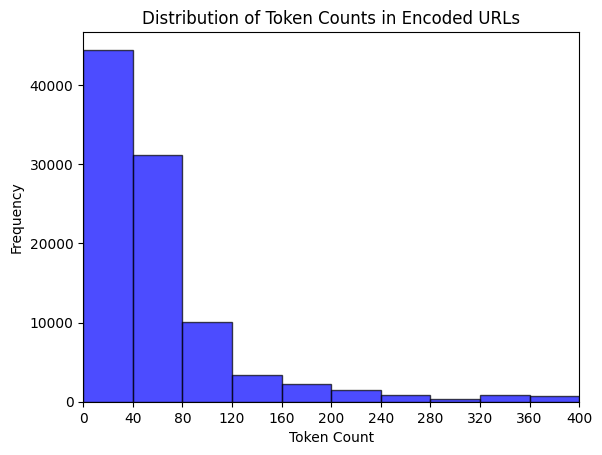

In [ ]:
TokenAnalyzer.plot_distribution(encoded_url)

### Padding & Truncating

In [ ]:
padded_truncate_encoded_URL = encoded_url.apply(preprocessor.padding_truncating, max_length = 80)
padded_truncate_encoded_URL.head()

0      [14, 15, 2, 5, 12, 12, 63, 9, 20, 69, 59, 52, 6, 6, 2, 57, 54, 4, 52, 59, 61, 53, 52, 61, 4, 3, 1, 57, 58, 58, 56, 3, 3, 5, 58, 6, 55, 53, 59, 55, 59, 55, 59, 60, 54, 69, 12, 15, 7, 9, 14, 63, 45, 11, 25, 42, 5, 63, 3, 15, 13, 69, 5, 14, 69, 3, 7, 9, 95, 2, 9, 14, 69, 22, 5, 18, 9, 6, 9, 3]
1        [23, 23, 23, 63, 4, 7, 8, 10, 4, 7, 6, 63, 3, 15, 13, 69, 16, 1, 25, 16, 1, 12, 63, 3, 15, 63, 21, 11, 69, 3, 25, 3, 7, 9, 95, 2, 9, 14, 69, 23, 5, 2, 19, 3, 18, 3, 13, 4, 77, 95, 8, 15, 13, 5, 95, 3, 21, 19, 20, 15, 13, 5, 18, 74, 14, 1, 22, 77, 53, 69, 12, 15, 1, 4, 9, 14, 7, 63, 16, 8]
2    [19, 5, 18, 22, 9, 3, 9, 15, 19, 2, 25, 19, 63, 3, 15, 13, 69, 16, 1, 25, 16, 1, 12, 63, 3, 7, 9, 63, 2, 9, 14, 63, 7, 5, 20, 95, 9, 14, 20, 15, 63, 8, 5, 18, 6, 63, 19, 5, 3, 21, 18, 5, 63, 4, 9, 19, 16, 1, 20, 3, 8, 55, 57, 56, 58, 55, 54, 57, 58, 18, 26, 18, 55, 54, 53, 58, 57, 56, 58, 56]
3                  [13, 1, 9, 12, 63, 16, 18, 9, 14, 20, 1, 11, 9, 4, 63, 3, 15, 13, 69, 23, 23, 23, 63, 15, 14, 12, 9, 14, 5, 63, 1, 13, 5, 18, 9, 3, 1, 14, 5, 24, 16, 18, 5, 19, 19, 63, 3, 15, 13, 69, 9, 14, 4, 5, 24, 63, 8, 20, 13, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4      [20, 8, 5, 23, 8, 9, 19, 11, 5, 25, 4, 18, 5, 7, 19, 63, 3, 15, 13, 69, 23, 16, 95, 3, 15, 14, 20, 5, 14, 20, 69, 20, 8, 5, 13, 5, 19, 69, 23, 9, 4, 5, 19, 3, 18, 5, 5, 14, 69, 9, 14, 3, 12, 21, 4, 5, 19, 69, 20, 5, 13, 16, 69, 16, 18, 15, 13, 15, 3, 15, 5, 19, 19, 13, 9, 12, 5, 19, 69, 66]
Name: domain, dtype: object

## Save Prepocessing Result
Menyimpan kolom atau fitur hasil prepocessing kedalam csv

In [ ]:
df_cleaned.loc[:, 'feature'] = padded_truncate_encoded_URL

# Pilih kolom yang ingin disimpan (feature dan label)
df_new = df_cleaned[['feature', 'label']]

dataframe.save_to_drive(df_new, "Ready_Dataset")

<ipython-input-25-090fc6cbb34b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, 'feature'] = padded_truncate_encoded_URL


Dataframe saved to drive!


# 4. Pengujian (No Need Re-Run)

Proposed Hyperparameter:

embedding_dims = [64, 128, 256]

batch_sizes = [32, 64, 128]

learning_rates = [1e-5, 2e-5, 3e-5]

num_epochs = [ 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

## Batch 1 (64, 32)

### Training

In [ ]:
# Membuat instance dari kelas Main dengan hyperparameter yang diperlukan
main_instance = Main(
    embedding_dim=64,  # Dimensi embedding
    batch_sizes=[32],  # Ukuran batch
    learning_rates=[1e-5, 2e-5, 3e-5],  # Daftar learning rates yang akan diuji
    num_epochs=20  # Jumlah epoch pelatihan
)

# Memanggil metode start_training untuk memulai proses
main_instance.start_training()

-----------------START TRAINING-----------------

1. Dataset Loaded

2. Data Splitted
Training set size: 69781
Testing set size: 17446 

GPU detected. Using GPU for training.

Hyperparameters for Current Training:
 - Embedding Dim : 64
 - Batch Size    : 32
 - Learning Rate : 1e-05
 - Epochs        : 20
Epoch 1/20
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.6563 - loss: 0.6315 - val_accuracy: 0.7365 - val_loss: 0.5238

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Epoch 2/20
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7420 - loss: 0.5168 - val_accuracy: 0.7699 - val_loss: 0.4768

Training log saved at /content/drive/MyDrive/Log/training_log.csv


Model saved: /content/drive/MyDrive/Model/cnn_attention_ed(64)_lr(1e-05)_bs(32)_epoch(2).keras

Epoch 3/20
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7646 - loss: 0.4745 - val_accuracy: 0.7974 - val_loss: 0.4539

Training log saved at /content/drive/MyDrive/Log/training_log.csv



### Plot Evaluate Model

Results for Learning Rate = 1e-05:

Optimal Validation Loss: 0.2952 at Epoch 20
Optimal Validation Accuracy: 0.8780 at Epoch 20 



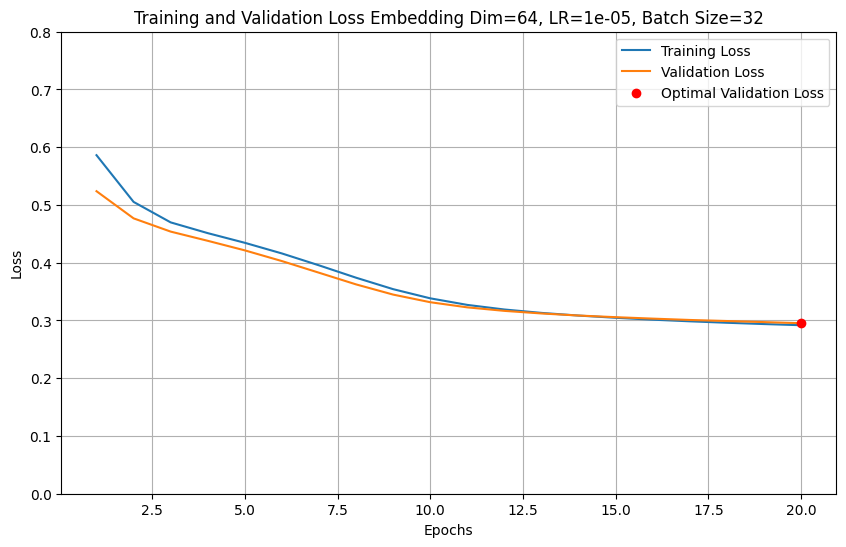

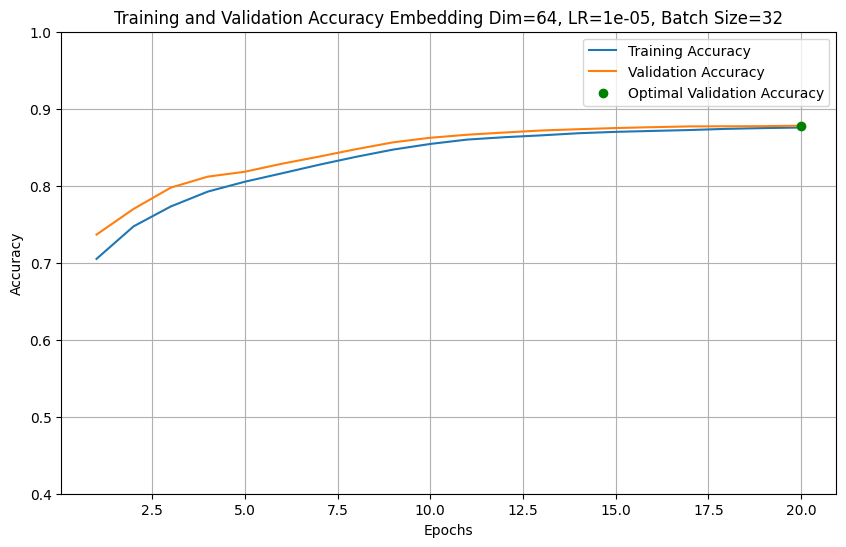



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Validation Loss: 0.2840 at Epoch 20
Optimal Validation Accuracy: 0.8798 at Epoch 20 



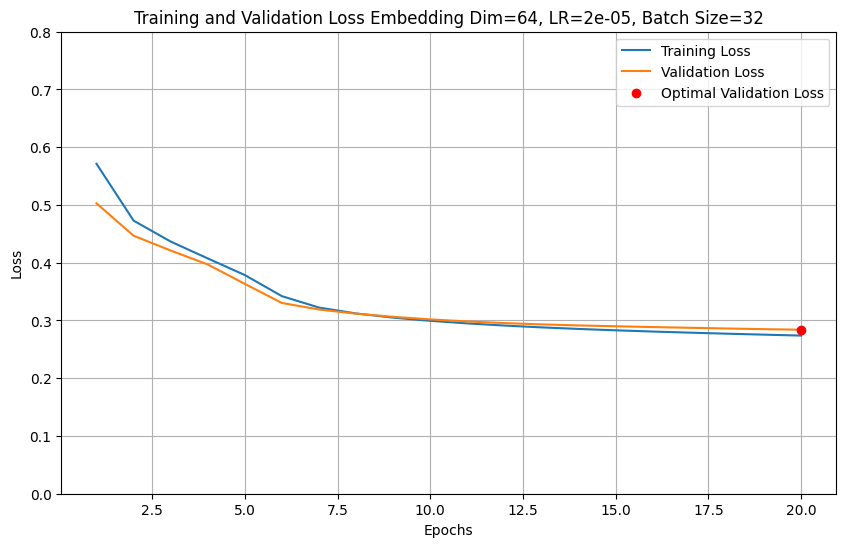

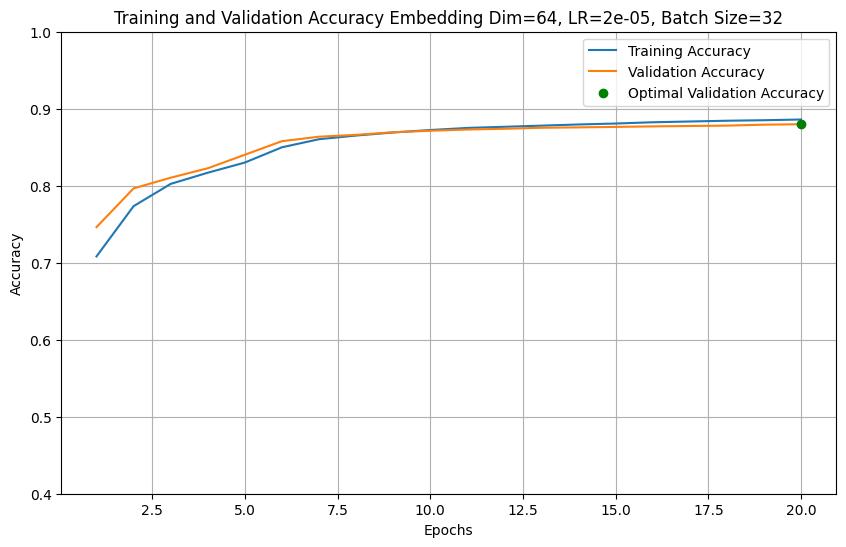



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Validation Loss: 0.2604 at Epoch 20
Optimal Validation Accuracy: 0.8931 at Epoch 20 



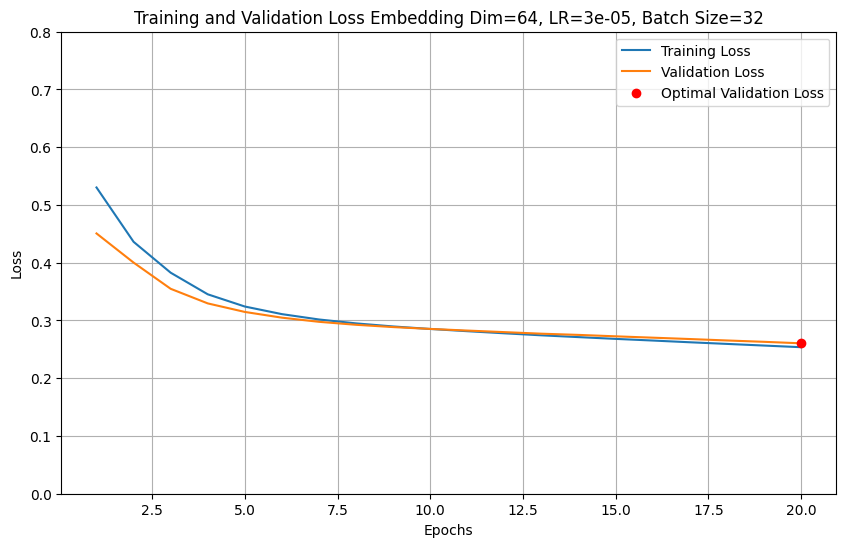

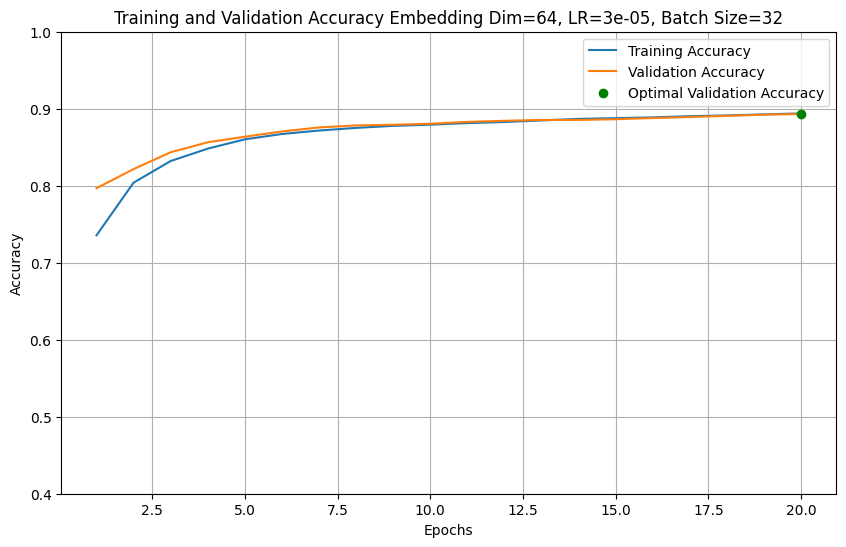



---------------------------------------------------------------------------------------------------- 



In [ ]:
log_path = "/content/drive/MyDrive/Log/training_log.csv"  # Pastikan path benar
log_data = pd.read_csv(log_path)

# List of learning rates to iterate over
learning_rates = [1e-5, 2e-5, 3e-5] # Learning Rate
ED = 64     # Embedding Dimension
BS = 32     # Batch Size

for lr in learning_rates:
    # Filter log data based on the specified hyperparameters
    filtered_log = log_data[
        (log_data['Embedding Dim'] == ED) &
        (log_data['Batch Size'] == BS) &
        (log_data['Learning Rate'] == lr)
    ]

    if filtered_log.empty:
        print(f"No data found for Learning Rate = {lr}!\n")
        print("----\n")
        continue

    # Extract relevant columns
    epochs = filtered_log['Epoch']
    train_loss = filtered_log['Training Loss']
    val_loss = filtered_log['Validation Loss']
    train_accuracy = filtered_log['Training Accuracy']
    val_accuracy = filtered_log['Validation Accuracy']

    # Find optimal epochs
    optimal_val_loss_epoch = val_loss.idxmin()
    optimal_val_accuracy_epoch = val_accuracy.idxmax()

    optimal_val_loss = val_loss.loc[optimal_val_loss_epoch]
    optimal_val_accuracy = val_accuracy.loc[optimal_val_accuracy_epoch]

    # Print optimal results for the current learning rate
    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Validation Loss: {optimal_val_loss:.4f} at Epoch {epochs.loc[optimal_val_loss_epoch]}")
    print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f} at Epoch {epochs.loc[optimal_val_accuracy_epoch]} \n")

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.scatter(epochs.loc[optimal_val_loss_epoch], optimal_val_loss, color='red', label='Optimal Validation Loss', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.8)
    plt.title(f'Training and Validation Loss Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.scatter(epochs.loc[optimal_val_accuracy_epoch], optimal_val_accuracy, color='green', label='Optimal Validation Accuracy', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)  # Mengatur skala y dari 0.4 hingga 1.0
    plt.title(f'Training and Validation Accuracy Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots
    print("----"*25,"\n")


## Batch 2 (64, 64)

### Training

In [ ]:
# Membuat instance dari kelas Main dengan hyperparameter yang diperlukan
main_instance = Main(
    embedding_dim=64,  # Dimensi embedding
    batch_sizes=[64],  # Ukuran batch
    learning_rates=[1e-5, 2e-5, 3e-5],  # Daftar learning rates yang akan diuji
    num_epochs=20  # Jumlah epoch pelatihan
)

# Memanggil metode start_training untuk memulai proses
main_instance.start_training()

-----------------START TRAINING-----------------

1. Dataset Loaded

2. Data Splitted
Training set size: 69781
Testing set size: 17446 

GPU detected. Using GPU for training.

Hyperparameters for Current Training:
 - Embedding Dim : 64
 - Batch Size    : 64
 - Learning Rate : 1e-05
 - Epochs        : 20
Epoch 1/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6189 - loss: 0.6669 - val_accuracy: 0.7350 - val_loss: 0.5410

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Epoch 2/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7343 - loss: 0.5356 - val_accuracy: 0.7444 - val_loss: 0.5013

Training log saved at /content/drive/MyDrive/Log/training_log.csv


Model saved: /content/drive/MyDrive/Model/cnn_attention_ed(64)_lr(1e-05)_bs(64)_epoch(2).keras

Epoch 3/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7465 - loss: 0.4974 - val_accuracy: 0.7691 - val_loss: 0.4638

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Epoc

### Plot Evaluate Model

Results for Learning Rate = 1e-05:

Optimal Validation Loss: 0.3125 at Epoch 20
Optimal Validation Accuracy: 0.8657 at Epoch 20 



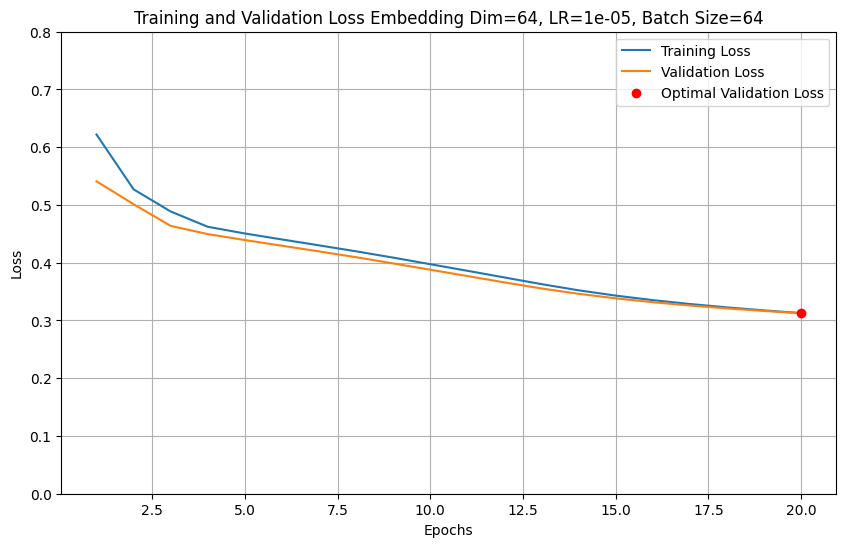

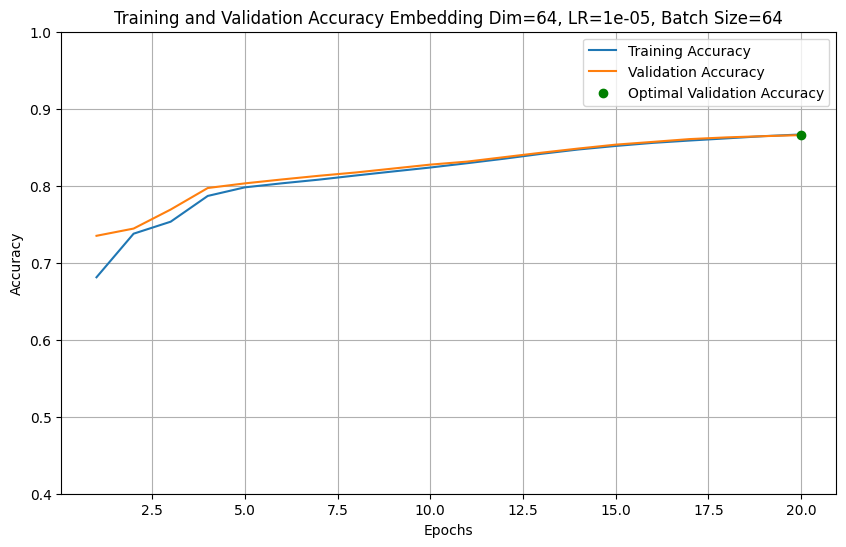



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Validation Loss: 0.2857 at Epoch 20
Optimal Validation Accuracy: 0.8806 at Epoch 20 



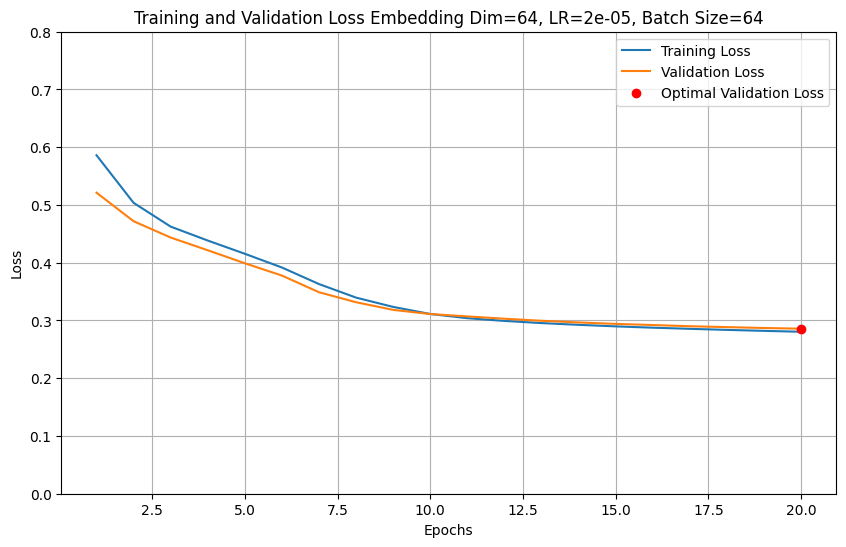

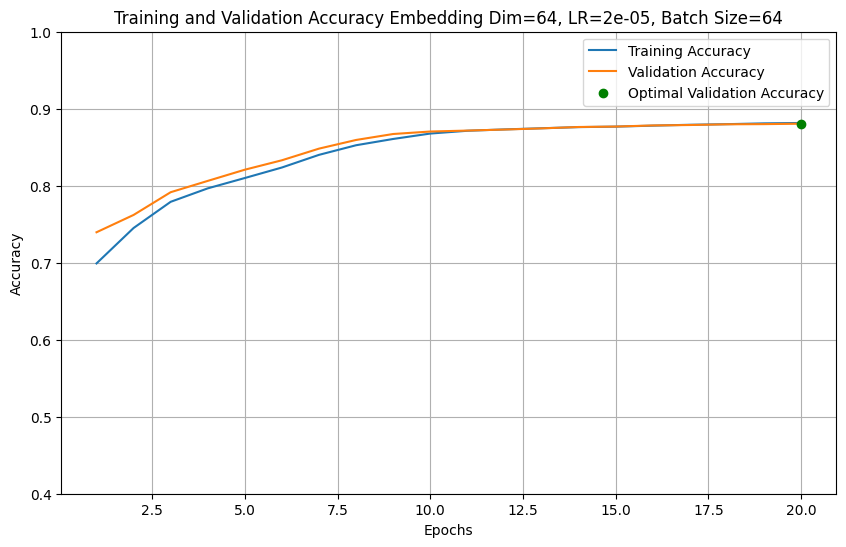



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Validation Loss: 0.2735 at Epoch 20
Optimal Validation Accuracy: 0.8849 at Epoch 20 



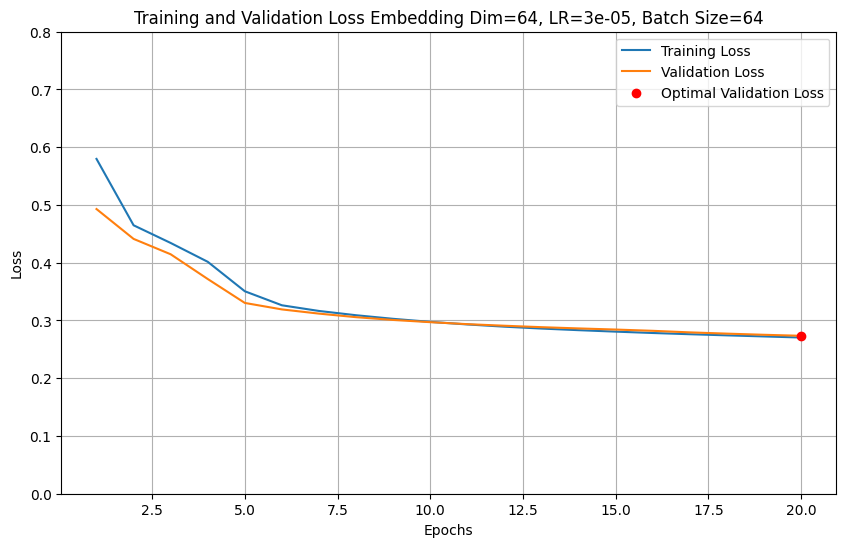

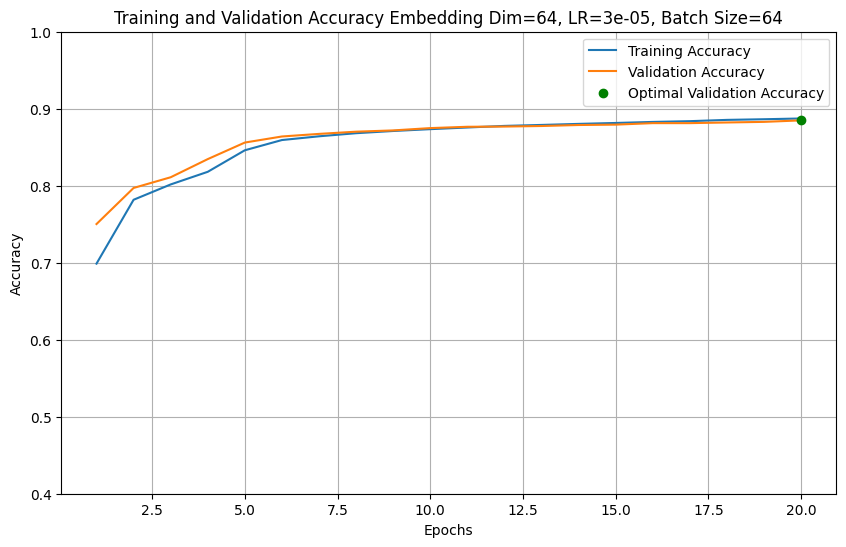



---------------------------------------------------------------------------------------------------- 



In [ ]:
log_path = "/content/drive/MyDrive/Log/training_log.csv"  # Pastikan path benar
log_data = pd.read_csv(log_path)

# List of learning rates to iterate over
learning_rates = [1e-5, 2e-5, 3e-5] # Learning Rate
ED = 64     # Embedding Dimension
BS = 64     # Batch Size

for lr in learning_rates:
    # Filter log data based on the specified hyperparameters
    filtered_log = log_data[
        (log_data['Embedding Dim'] == ED) &
        (log_data['Batch Size'] == BS) &
        (log_data['Learning Rate'] == lr)
    ]

    if filtered_log.empty:
        print(f"No data found for Learning Rate = {lr}!\n")
        print("----\n")
        continue

    # Extract relevant columns
    epochs = filtered_log['Epoch']
    train_loss = filtered_log['Training Loss']
    val_loss = filtered_log['Validation Loss']
    train_accuracy = filtered_log['Training Accuracy']
    val_accuracy = filtered_log['Validation Accuracy']

    # Find optimal epochs
    optimal_val_loss_epoch = val_loss.idxmin()
    optimal_val_accuracy_epoch = val_accuracy.idxmax()

    optimal_val_loss = val_loss.loc[optimal_val_loss_epoch]
    optimal_val_accuracy = val_accuracy.loc[optimal_val_accuracy_epoch]

    # Print optimal results for the current learning rate
    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Validation Loss: {optimal_val_loss:.4f} at Epoch {epochs.loc[optimal_val_loss_epoch]}")
    print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f} at Epoch {epochs.loc[optimal_val_accuracy_epoch]} \n")

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.scatter(epochs.loc[optimal_val_loss_epoch], optimal_val_loss, color='red', label='Optimal Validation Loss', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.8)
    plt.title(f'Training and Validation Loss Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.scatter(epochs.loc[optimal_val_accuracy_epoch], optimal_val_accuracy, color='green', label='Optimal Validation Accuracy', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)  # Mengatur skala y dari 0.4 hingga 1.0
    plt.title(f'Training and Validation Accuracy Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots
    print("----"*25,"\n")


## Batch 3 (64, 128)

### Training

In [ ]:
# Membuat instance dari kelas Main dengan hyperparameter yang diperlukan
main_instance = Main(
    embedding_dim=64,  # Dimensi embedding
    batch_sizes=[128],  # Ukuran batch
    learning_rates=[1e-5, 2e-5, 3e-5],  # Daftar learning rates yang akan diuji
    num_epochs=20  # Jumlah epoch pelatihan
)

# Memanggil metode start_training untuk memulai proses
main_instance.start_training()

-----------------START TRAINING-----------------

1. Dataset Loaded

2. Data Splitted
Training set size: 69781
Testing set size: 17446 

GPU detected. Using GPU for training.

Hyperparameters for Current Training:
 - Embedding Dim : 64
 - Batch Size    : 128
 - Learning Rate : 1e-05
 - Epochs        : 20
Epoch 1/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6036 - loss: 0.6716 - val_accuracy: 0.7324 - val_loss: 0.5752

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7340 - loss: 0.5565 - val_accuracy: 0.7340 - val_loss: 0.5348

Training log saved at /content/drive/MyDrive/Log/training_log.csv


Model saved: /content/drive/MyDrive/Model/cnn_attention_ed(64)_lr(1e-05)_bs(128)_epoch(2).keras

Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7352 - loss: 0.5323 - val_accuracy: 0.7372 - val_loss: 0.5218

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Ep

### Plot Evaluate Model

Results for Learning Rate = 1e-05:

Optimal Validation Loss: 0.3342 at Epoch 20
Optimal Validation Accuracy: 0.8568 at Epoch 20 



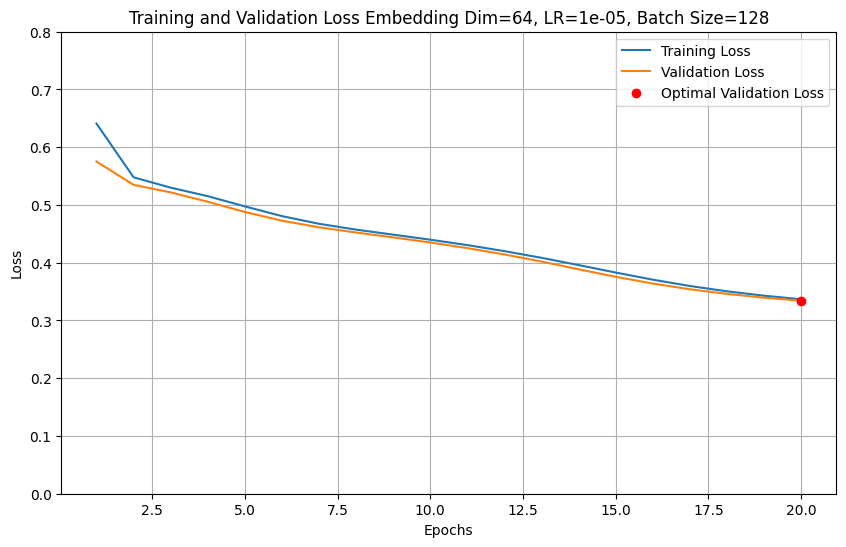

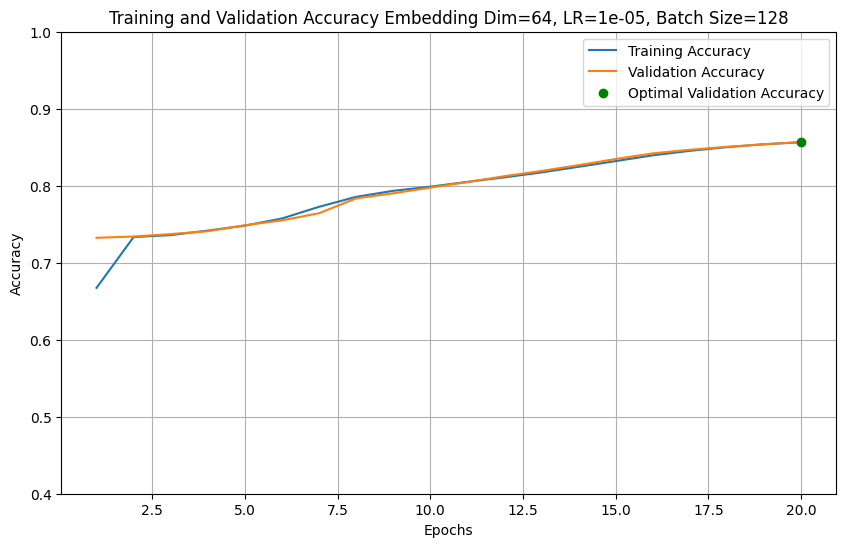



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Validation Loss: 0.3034 at Epoch 20
Optimal Validation Accuracy: 0.8715 at Epoch 20 



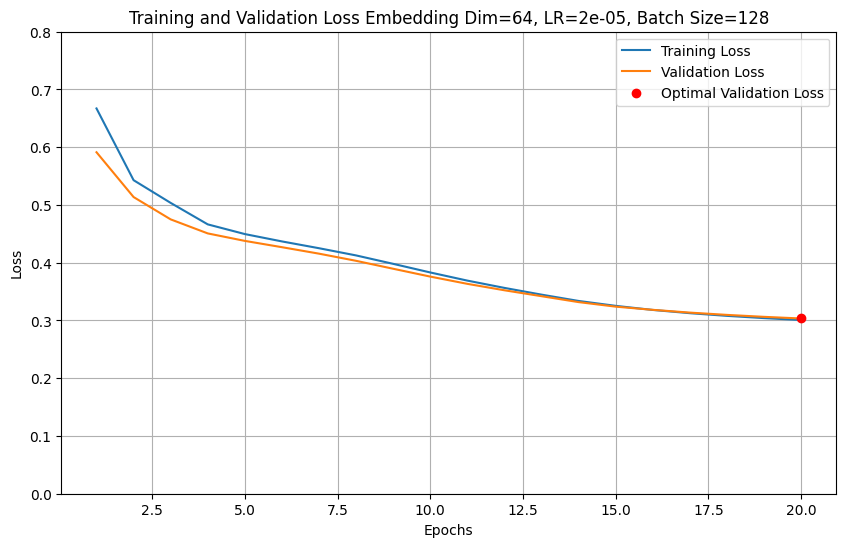

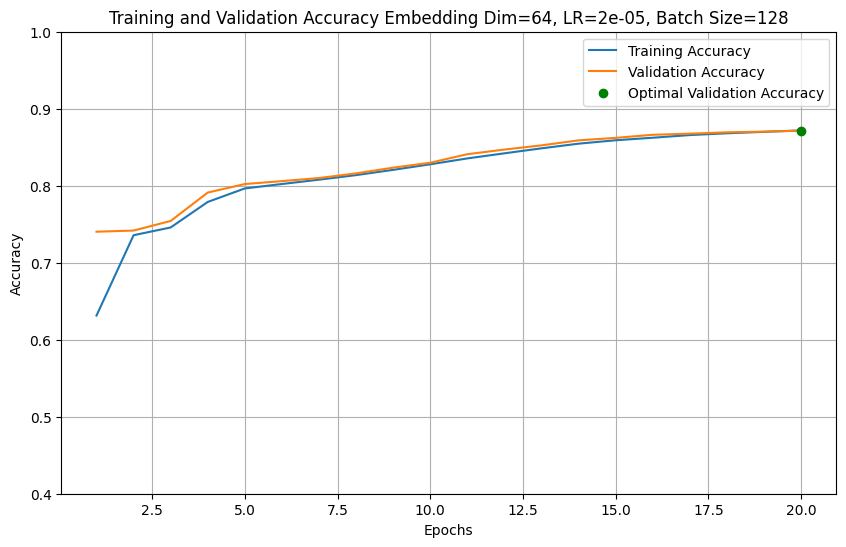



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Validation Loss: 0.2852 at Epoch 20
Optimal Validation Accuracy: 0.8808 at Epoch 20 



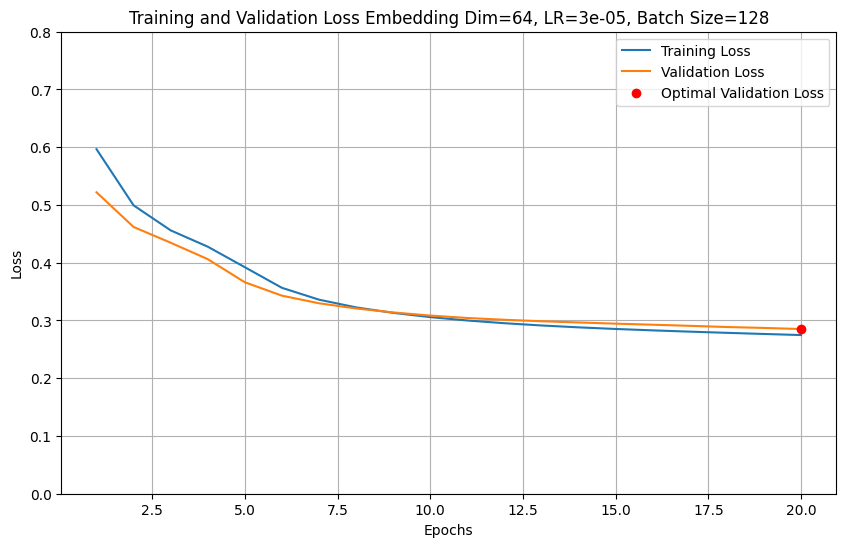

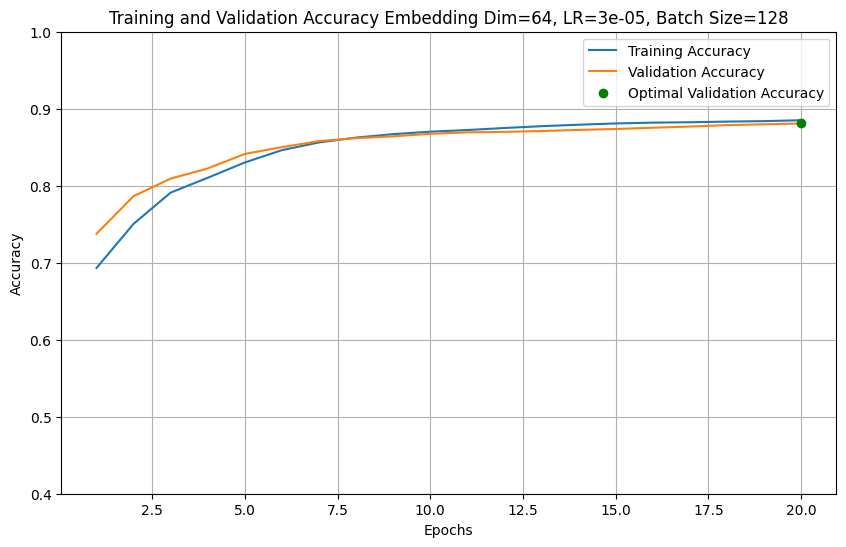



---------------------------------------------------------------------------------------------------- 



In [ ]:
log_path = "/content/drive/MyDrive/Log/training_log.csv"  # Pastikan path benar
log_data = pd.read_csv(log_path)

# List of learning rates to iterate over
learning_rates = [1e-5, 2e-5, 3e-5] # Learning Rate
ED = 64     # Embedding Dimension
BS = 128     # Batch Size

for lr in learning_rates:
    # Filter log data based on the specified hyperparameters
    filtered_log = log_data[
        (log_data['Embedding Dim'] == ED) &
        (log_data['Batch Size'] == BS) &
        (log_data['Learning Rate'] == lr)
    ]

    if filtered_log.empty:
        print(f"No data found for Learning Rate = {lr}!\n")
        print("----\n")
        continue

    # Extract relevant columns
    epochs = filtered_log['Epoch']
    train_loss = filtered_log['Training Loss']
    val_loss = filtered_log['Validation Loss']
    train_accuracy = filtered_log['Training Accuracy']
    val_accuracy = filtered_log['Validation Accuracy']

    # Find optimal epochs
    optimal_val_loss_epoch = val_loss.idxmin()
    optimal_val_accuracy_epoch = val_accuracy.idxmax()

    optimal_val_loss = val_loss.loc[optimal_val_loss_epoch]
    optimal_val_accuracy = val_accuracy.loc[optimal_val_accuracy_epoch]

    # Print optimal results for the current learning rate
    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Validation Loss: {optimal_val_loss:.4f} at Epoch {epochs.loc[optimal_val_loss_epoch]}")
    print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f} at Epoch {epochs.loc[optimal_val_accuracy_epoch]} \n")

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.scatter(epochs.loc[optimal_val_loss_epoch], optimal_val_loss, color='red', label='Optimal Validation Loss', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.8)
    plt.title(f'Training and Validation Loss Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.scatter(epochs.loc[optimal_val_accuracy_epoch], optimal_val_accuracy, color='green', label='Optimal Validation Accuracy', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)  # Mengatur skala y dari 0.4 hingga 1.0
    plt.title(f'Training and Validation Accuracy Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots
    print("----"*25,"\n")


## Batch 4 (128, 32)

### Training

In [ ]:
# Membuat instance dari kelas Main dengan hyperparameter yang diperlukan
main_instance = Main(
    embedding_dim=128,  # Dimensi embedding
    batch_sizes=[32],  # Ukuran batch
    learning_rates=[1e-5, 2e-5, 3e-5],  # Daftar learning rates yang akan diuji
    num_epochs=20  # Jumlah epoch pelatihan
)

# Memanggil metode start_training untuk memulai proses
main_instance.start_training()

-----------------START TRAINING-----------------

1. Dataset Loaded

2. Data Splitted
Training set size: 69781
Testing set size: 17446 

GPU detected. Using GPU for training.

Hyperparameters for Current Training:
 - Embedding Dim : 128
 - Batch Size    : 32
 - Learning Rate : 1e-05
 - Epochs        : 20
Epoch 1/20
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.6398 - loss: 0.6447 - val_accuracy: 0.7391 - val_loss: 0.5165

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Epoch 2/20
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.7426 - loss: 0.5086 - val_accuracy: 0.7838 - val_loss: 0.4704

Training log saved at /content/drive/MyDrive/Log/training_log.csv


Model saved: /content/drive/MyDrive/Model/cnn_attention_ed(128)_lr(1e-05)_bs(32)_epoch(2).keras

Epoch 3/20
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7727 - loss: 0.4677 - val_accuracy: 0.7969 - val_loss: 0.4485

Training log saved at /content/drive/MyDrive/Log/training_log.c

### Plot Evaluate Model

Results for Learning Rate = 1e-05:

Optimal Validation Loss: 0.2922 at Epoch 20
Optimal Validation Accuracy: 0.8783 at Epoch 20 



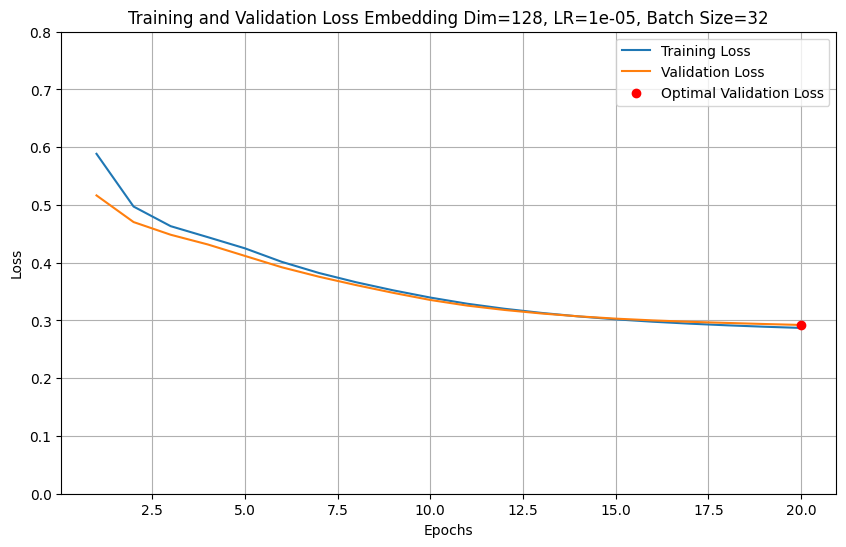

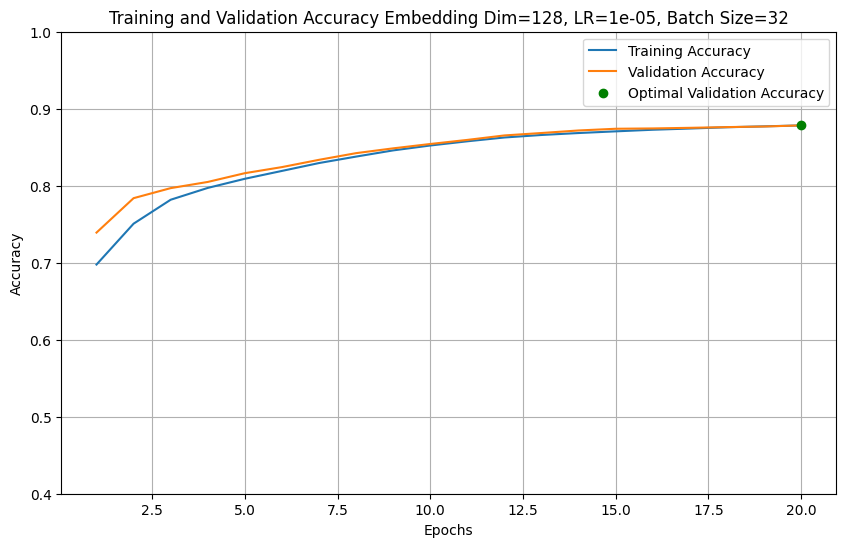



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Validation Loss: 0.2708 at Epoch 20
Optimal Validation Accuracy: 0.8877 at Epoch 18 



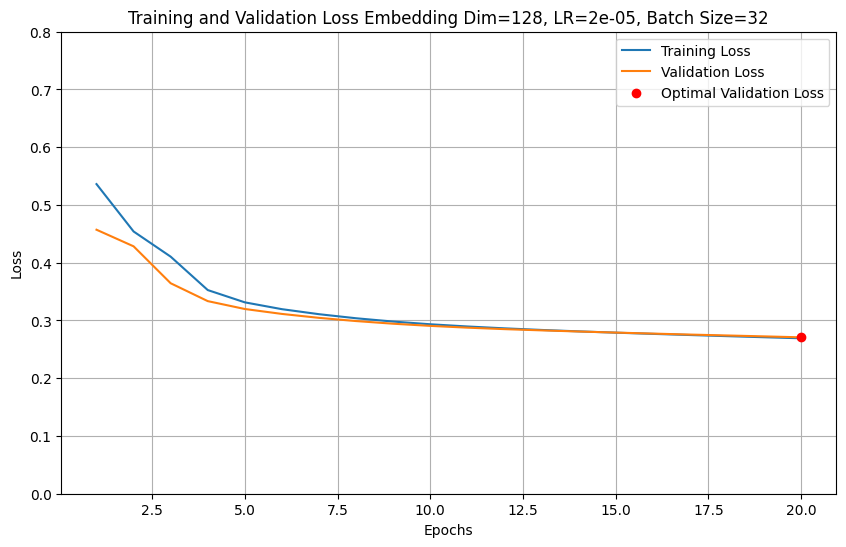

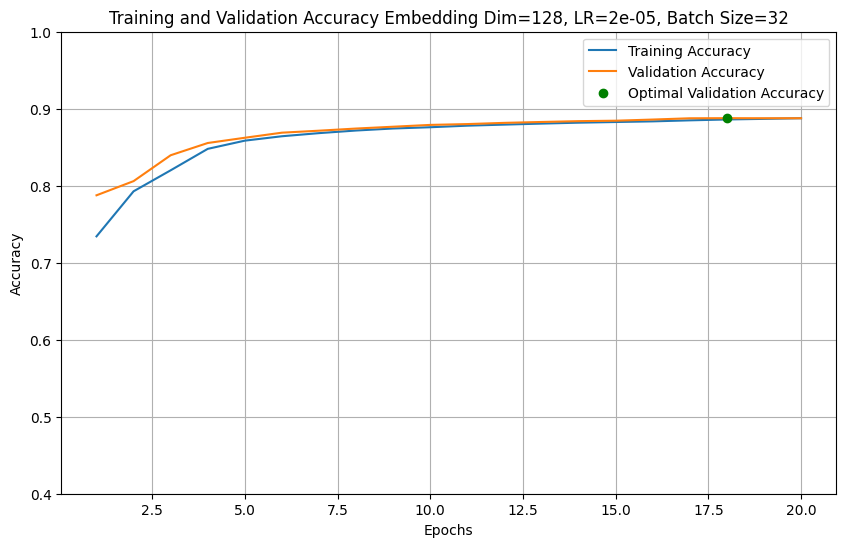



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Validation Loss: 0.2214 at Epoch 20
Optimal Validation Accuracy: 0.9118 at Epoch 20 



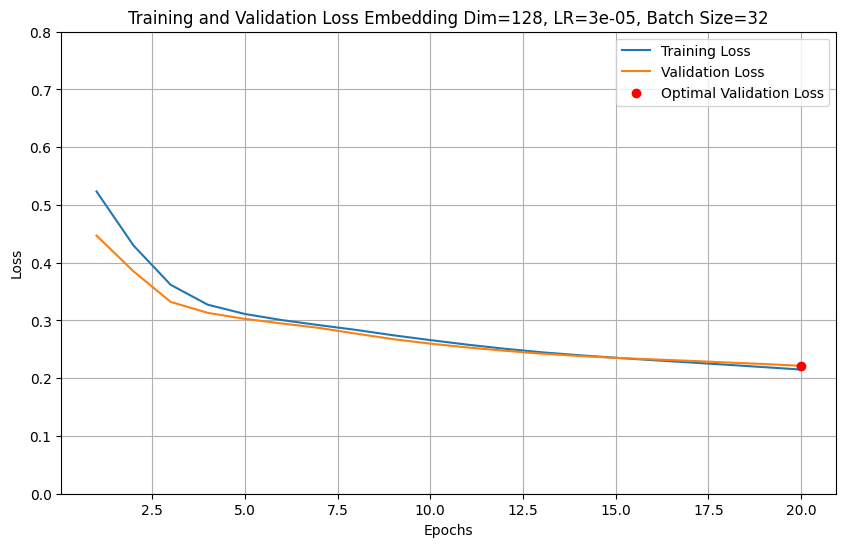

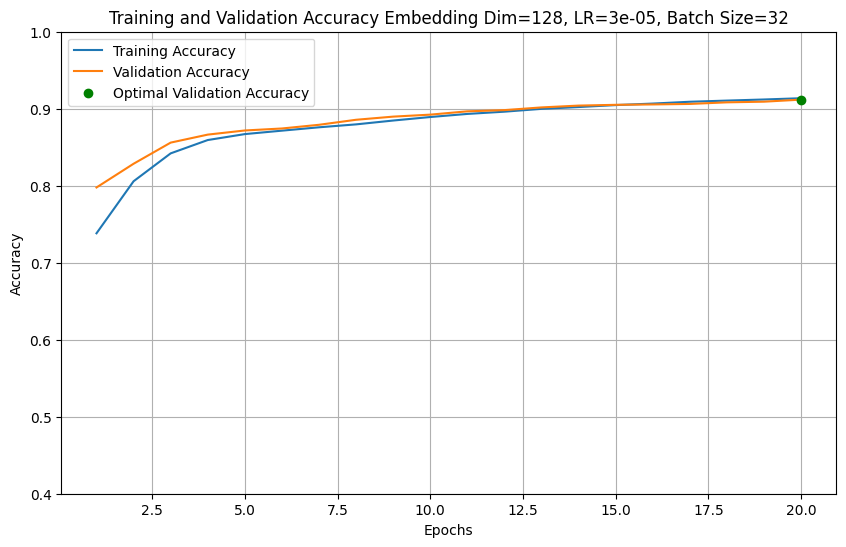



---------------------------------------------------------------------------------------------------- 



In [ ]:
log_path = "/content/drive/MyDrive/Log/training_log.csv"  # Pastikan path benar
log_data = pd.read_csv(log_path)

# List of learning rates to iterate over
learning_rates = [1e-5, 2e-5, 3e-5] # Learning Rate
ED = 128     # Embedding Dimension
BS = 32     # Batch Size

for lr in learning_rates:
    # Filter log data based on the specified hyperparameters
    filtered_log = log_data[
        (log_data['Embedding Dim'] == ED) &
        (log_data['Batch Size'] == BS) &
        (log_data['Learning Rate'] == lr)
    ]

    if filtered_log.empty:
        print(f"No data found for Learning Rate = {lr}!\n")
        print("----\n")
        continue

    # Extract relevant columns
    epochs = filtered_log['Epoch']
    train_loss = filtered_log['Training Loss']
    val_loss = filtered_log['Validation Loss']
    train_accuracy = filtered_log['Training Accuracy']
    val_accuracy = filtered_log['Validation Accuracy']

    # Find optimal epochs
    optimal_val_loss_epoch = val_loss.idxmin()
    optimal_val_accuracy_epoch = val_accuracy.idxmax()

    optimal_val_loss = val_loss.loc[optimal_val_loss_epoch]
    optimal_val_accuracy = val_accuracy.loc[optimal_val_accuracy_epoch]

    # Print optimal results for the current learning rate
    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Validation Loss: {optimal_val_loss:.4f} at Epoch {epochs.loc[optimal_val_loss_epoch]}")
    print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f} at Epoch {epochs.loc[optimal_val_accuracy_epoch]} \n")

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.scatter(epochs.loc[optimal_val_loss_epoch], optimal_val_loss, color='red', label='Optimal Validation Loss', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.8)
    plt.title(f'Training and Validation Loss Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.scatter(epochs.loc[optimal_val_accuracy_epoch], optimal_val_accuracy, color='green', label='Optimal Validation Accuracy', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)  # Mengatur skala y dari 0.4 hingga 1.0
    plt.title(f'Training and Validation Accuracy Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots
    print("----"*25,"\n")


## Batch 5 (128, 64)

### Train

In [ ]:
# Membuat instance dari kelas Main dengan hyperparameter yang diperlukan
main_instance = Main(
    embedding_dim=128,  # Dimensi embedding
    batch_sizes=[64],  # Ukuran batch
    learning_rates=[1e-5, 2e-5, 3e-5],  # Daftar learning rates yang akan diuji
    num_epochs=20  # Jumlah epoch pelatihan
)

# Memanggil metode start_training untuk memulai proses
main_instance.start_training()

-----------------START TRAINING-----------------

1. Dataset Loaded

2. Data Splitted
Training set size: 69781
Testing set size: 17446 

GPU detected. Using GPU for training.

Hyperparameters for Current Training:
 - Embedding Dim : 128
 - Batch Size    : 64
 - Learning Rate : 1e-05
 - Epochs        : 20
Epoch 1/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6166 - loss: 0.6608 - val_accuracy: 0.7369 - val_loss: 0.5378

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Epoch 2/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7369 - loss: 0.5317 - val_accuracy: 0.7472 - val_loss: 0.4916

Training log saved at /content/drive/MyDrive/Log/training_log.csv


Model saved: /content/drive/MyDrive/Model/cnn_attention_ed(128)_lr(1e-05)_bs(64)_epoch(2).keras

Epoch 3/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.7612 - loss: 0.4823 - val_accuracy: 0.7833 - val_loss: 0.4538

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Ep

### Plot Evaluate Model

Results for Learning Rate = 1e-05:

Optimal Validation Loss: 0.3009 at Epoch 20
Optimal Validation Accuracy: 0.8752 at Epoch 20 



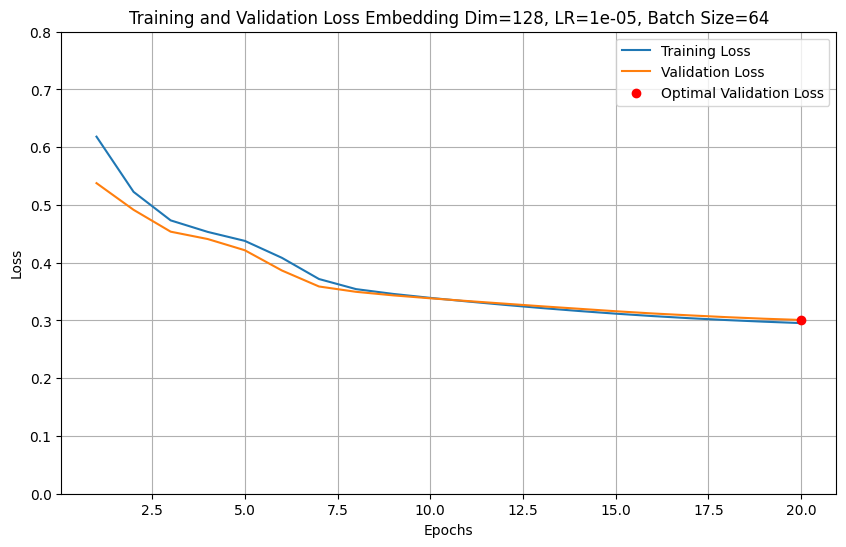

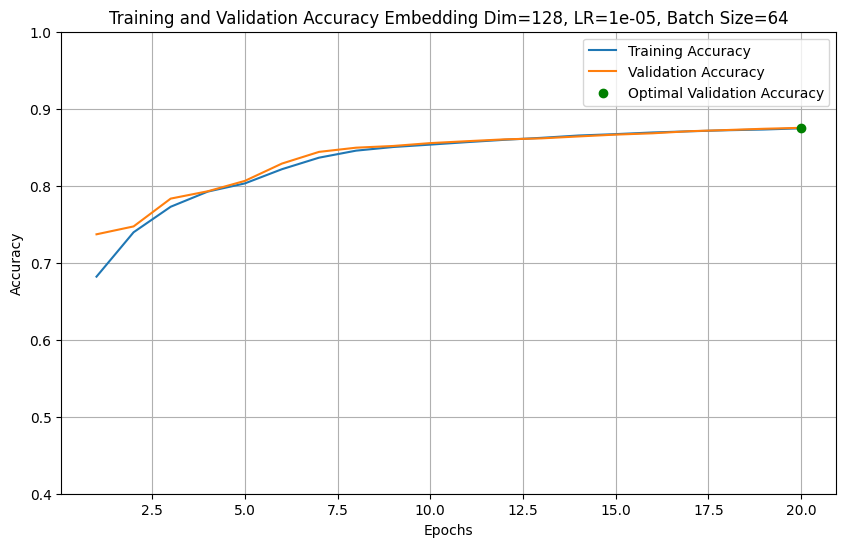



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Validation Loss: 0.2762 at Epoch 20
Optimal Validation Accuracy: 0.8867 at Epoch 20 



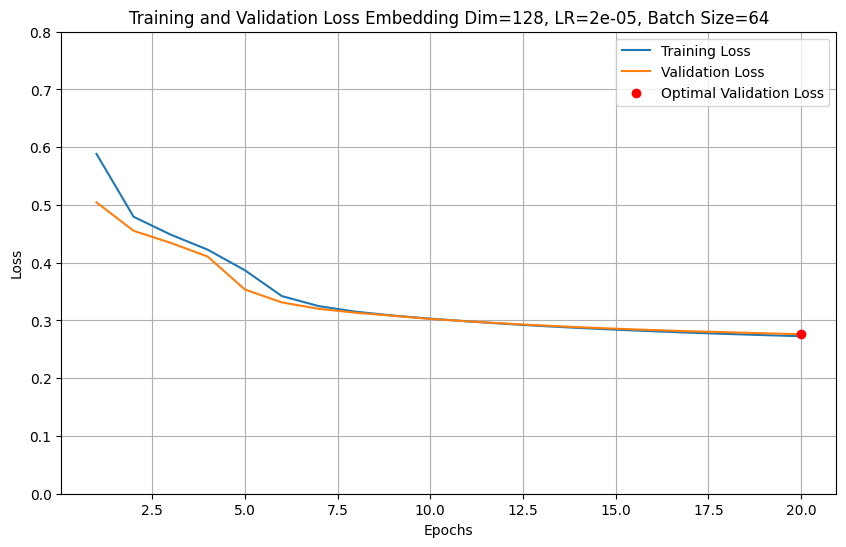

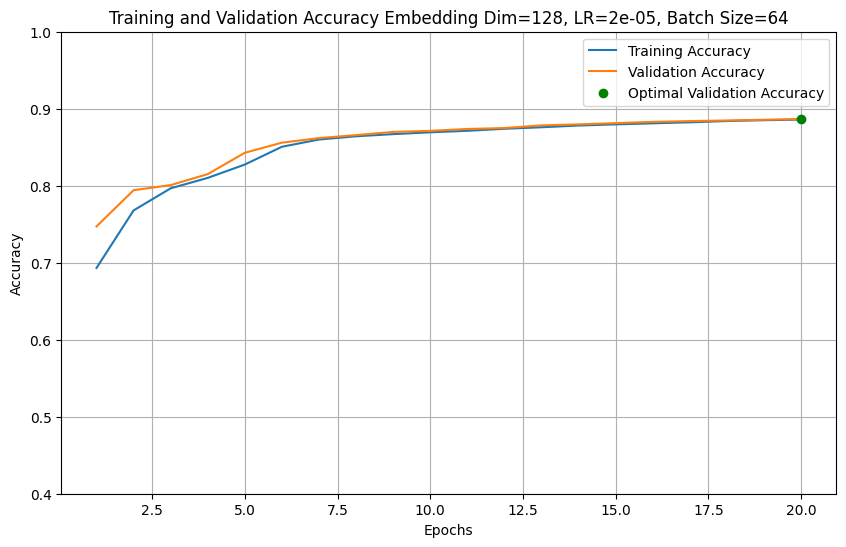



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Validation Loss: 0.2700 at Epoch 20
Optimal Validation Accuracy: 0.8867 at Epoch 19 



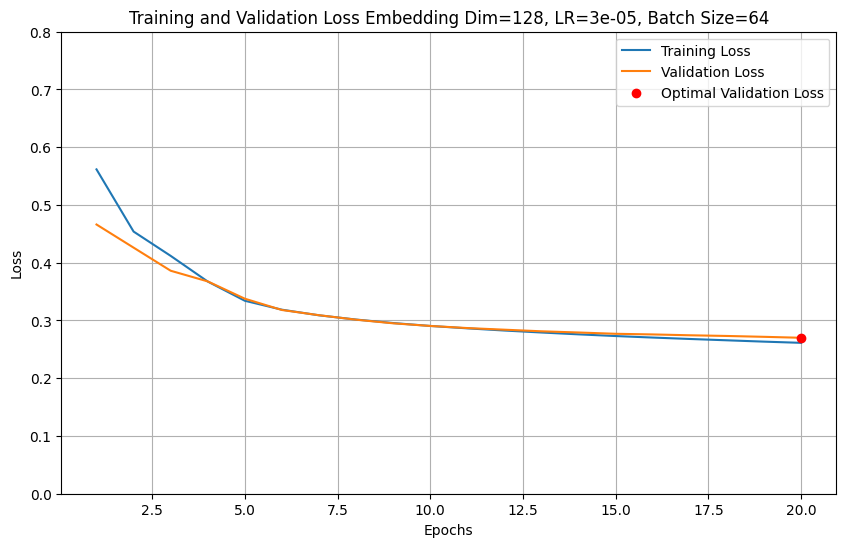

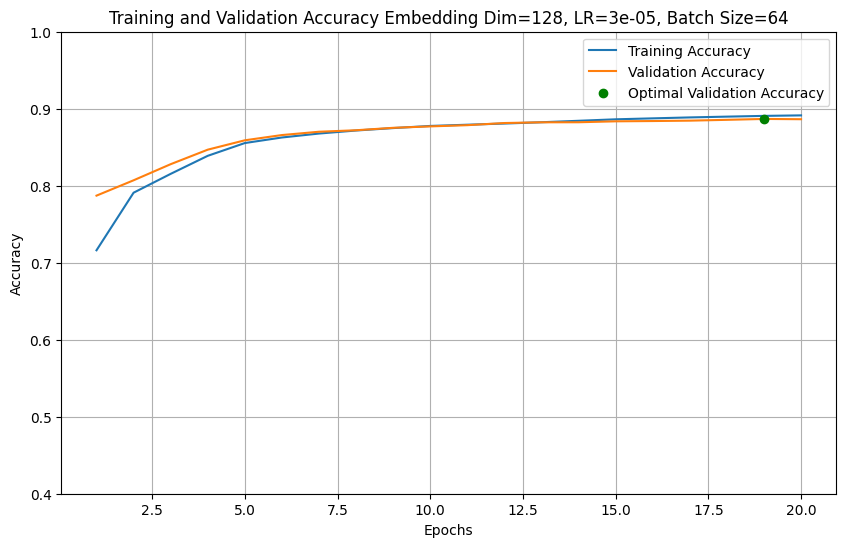



---------------------------------------------------------------------------------------------------- 



In [ ]:
log_path = "/content/drive/MyDrive/Log/training_log.csv"  # Pastikan path benar
log_data = pd.read_csv(log_path)

# List of learning rates to iterate over
learning_rates = [1e-5, 2e-5, 3e-5] # Learning Rate
ED = 128     # Embedding Dimension
BS = 64     # Batch Size

for lr in learning_rates:
    # Filter log data based on the specified hyperparameters
    filtered_log = log_data[
        (log_data['Embedding Dim'] == ED) &
        (log_data['Batch Size'] == BS) &
        (log_data['Learning Rate'] == lr)
    ]

    if filtered_log.empty:
        print(f"No data found for Learning Rate = {lr}!\n")
        print("----\n")
        continue

    # Extract relevant columns
    epochs = filtered_log['Epoch']
    train_loss = filtered_log['Training Loss']
    val_loss = filtered_log['Validation Loss']
    train_accuracy = filtered_log['Training Accuracy']
    val_accuracy = filtered_log['Validation Accuracy']

    # Find optimal epochs
    optimal_val_loss_epoch = val_loss.idxmin()
    optimal_val_accuracy_epoch = val_accuracy.idxmax()

    optimal_val_loss = val_loss.loc[optimal_val_loss_epoch]
    optimal_val_accuracy = val_accuracy.loc[optimal_val_accuracy_epoch]

    # Print optimal results for the current learning rate
    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Validation Loss: {optimal_val_loss:.4f} at Epoch {epochs.loc[optimal_val_loss_epoch]}")
    print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f} at Epoch {epochs.loc[optimal_val_accuracy_epoch]} \n")

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.scatter(epochs.loc[optimal_val_loss_epoch], optimal_val_loss, color='red', label='Optimal Validation Loss', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.8)
    plt.title(f'Training and Validation Loss Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.scatter(epochs.loc[optimal_val_accuracy_epoch], optimal_val_accuracy, color='green', label='Optimal Validation Accuracy', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)  # Mengatur skala y dari 0.4 hingga 1.0
    plt.title(f'Training and Validation Accuracy Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots
    print("----"*25,"\n")


## Batch 6 (128, 128)

### Train

In [ ]:
# Membuat instance dari kelas Main dengan hyperparameter yang diperlukan
main_instance = Main(
    embedding_dim=128,  # Dimensi embedding
    batch_sizes=[128],  # Ukuran batch
    learning_rates=[1e-5, 2e-5, 3e-5],  # Daftar learning rates yang akan diuji
    num_epochs=20  # Jumlah epoch pelatihan
)

# Memanggil metode start_training untuk memulai proses
main_instance.start_training()

-----------------START TRAINING-----------------

1. Dataset Loaded

2. Data Splitted
Training set size: 69781
Testing set size: 17446 

GPU detected. Using GPU for training.

Hyperparameters for Current Training:
 - Embedding Dim : 128
 - Batch Size    : 128
 - Learning Rate : 1e-05
 - Epochs        : 20
Epoch 1/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.6420 - loss: 0.6529 - val_accuracy: 0.7363 - val_loss: 0.5538

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.7354 - loss: 0.5446 - val_accuracy: 0.7426 - val_loss: 0.5161

Training log saved at /content/drive/MyDrive/Log/training_log.csv


Model saved: /content/drive/MyDrive/Model/cnn_attention_ed(128)_lr(1e-05)_bs(128)_epoch(2).keras

Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.7419 - loss: 0.5142 - val_accuracy: 0.7502 - val_loss: 0.4893

Training log saved at /content/drive/MyDrive/Log/training_log.csv



### Plot Evaluate Model

Results for Learning Rate = 1e-05:

Optimal Validation Loss: 0.3145 at Epoch 20
Optimal Validation Accuracy: 0.8668 at Epoch 20 



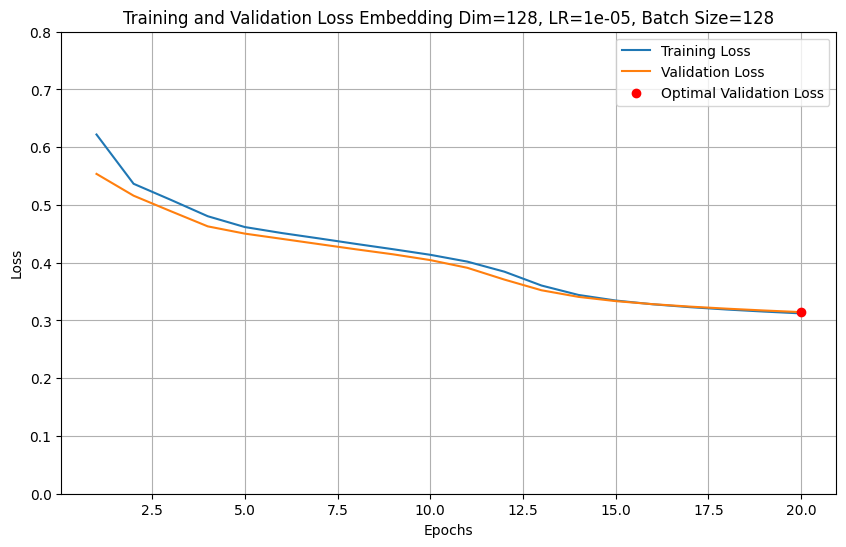

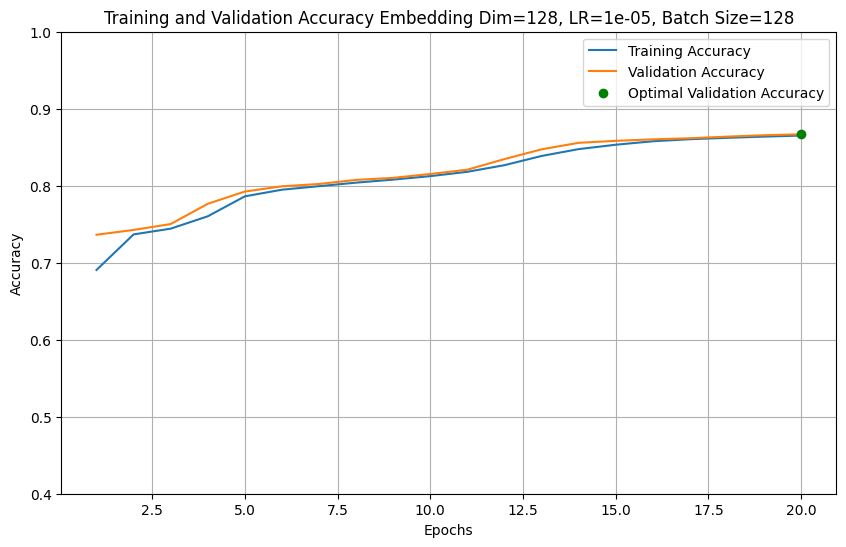



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Validation Loss: 0.2901 at Epoch 20
Optimal Validation Accuracy: 0.8781 at Epoch 20 



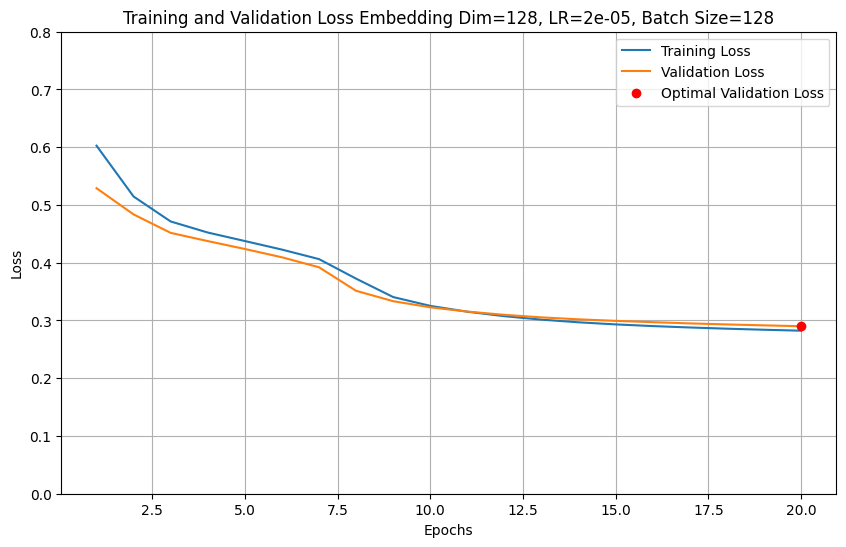

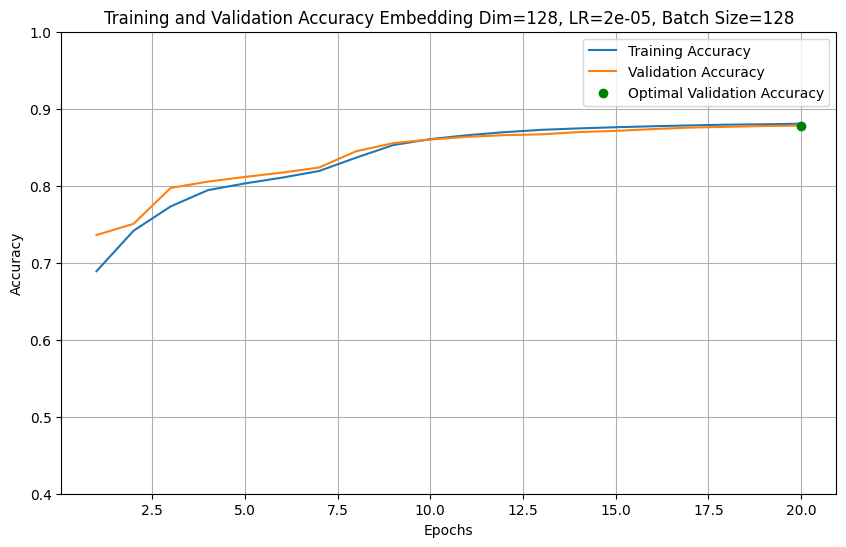



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Validation Loss: 0.2738 at Epoch 20
Optimal Validation Accuracy: 0.8839 at Epoch 20 



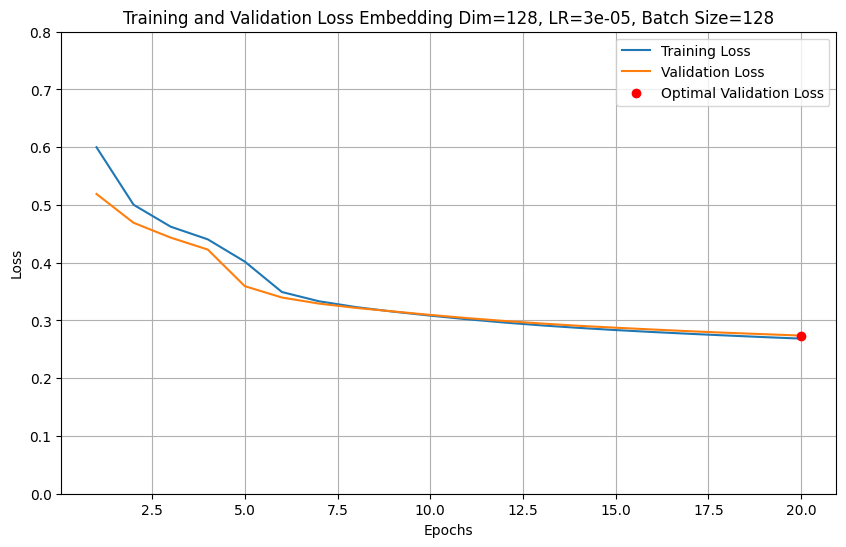

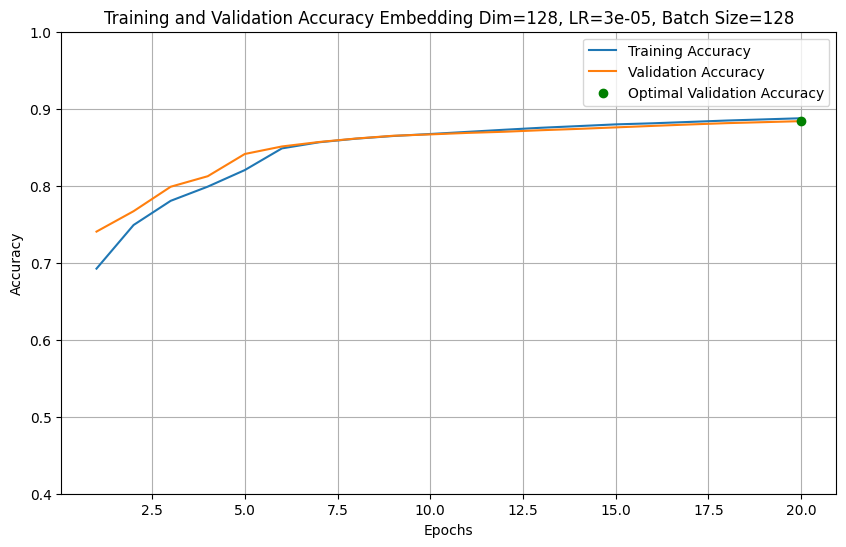



---------------------------------------------------------------------------------------------------- 



In [ ]:
log_path = "/content/drive/MyDrive/Log/training_log.csv"  # Pastikan path benar
log_data = pd.read_csv(log_path)

# List of learning rates to iterate over
learning_rates = [1e-5, 2e-5, 3e-5] # Learning Rate
ED = 128     # Embedding Dimension
BS = 128     # Batch Size

for lr in learning_rates:
    # Filter log data based on the specified hyperparameters
    filtered_log = log_data[
        (log_data['Embedding Dim'] == ED) &
        (log_data['Batch Size'] == BS) &
        (log_data['Learning Rate'] == lr)
    ]

    if filtered_log.empty:
        print(f"No data found for Learning Rate = {lr}!\n")
        print("----\n")
        continue

    # Extract relevant columns
    epochs = filtered_log['Epoch']
    train_loss = filtered_log['Training Loss']
    val_loss = filtered_log['Validation Loss']
    train_accuracy = filtered_log['Training Accuracy']
    val_accuracy = filtered_log['Validation Accuracy']

    # Find optimal epochs
    optimal_val_loss_epoch = val_loss.idxmin()
    optimal_val_accuracy_epoch = val_accuracy.idxmax()

    optimal_val_loss = val_loss.loc[optimal_val_loss_epoch]
    optimal_val_accuracy = val_accuracy.loc[optimal_val_accuracy_epoch]

    # Print optimal results for the current learning rate
    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Validation Loss: {optimal_val_loss:.4f} at Epoch {epochs.loc[optimal_val_loss_epoch]}")
    print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f} at Epoch {epochs.loc[optimal_val_accuracy_epoch]} \n")

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.scatter(epochs.loc[optimal_val_loss_epoch], optimal_val_loss, color='red', label='Optimal Validation Loss', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.8)
    plt.title(f'Training and Validation Loss Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.scatter(epochs.loc[optimal_val_accuracy_epoch], optimal_val_accuracy, color='green', label='Optimal Validation Accuracy', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)  # Mengatur skala y dari 0.4 hingga 1.0
    plt.title(f'Training and Validation Accuracy Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots
    print("----"*25,"\n")


## Batch 7 (256, 32)

### Train

In [ ]:
# Membuat instance dari kelas Main dengan hyperparameter yang diperlukan
main_instance = Main(
    embedding_dim=256,  # Dimensi embedding
    batch_sizes=[32],  # Ukuran batch
    learning_rates=[1e-5, 2e-5, 3e-5],  # Daftar learning rates yang akan diuji
    num_epochs=20  # Jumlah epoch pelatihan
)

# Memanggil metode start_training untuk memulai proses
main_instance.start_training()

-----------------START TRAINING-----------------

1. Dataset Loaded

2. Data Splitted
Training set size: 69781
Testing set size: 17446 

GPU detected. Using GPU for training.

Hyperparameters for Current Training:
 - Embedding Dim : 256
 - Batch Size    : 32
 - Learning Rate : 1e-05
 - Epochs        : 20
Epoch 1/20
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - accuracy: 0.6516 - loss: 0.6423 - val_accuracy: 0.7428 - val_loss: 0.5128

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Epoch 2/20
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.7463 - loss: 0.5057 - val_accuracy: 0.7845 - val_loss: 0.4666

Training log saved at /content/drive/MyDrive/Log/training_log.csv


Model saved: /content/drive/MyDrive/Model/cnn_attention_ed(256)_lr(1e-05)_bs(32)_epoch(2).keras

Epoch 3/20
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.7821 - loss: 0.4611 - val_accuracy: 0.8093 - val_loss: 0.4292

Training log saved at /content/drive/MyDrive/Log/training_log.c

### Plot Evaluate Model

Results for Learning Rate = 1e-05:

Optimal Validation Loss: 0.2770 at Epoch 20
Optimal Validation Accuracy: 0.8821 at Epoch 20 



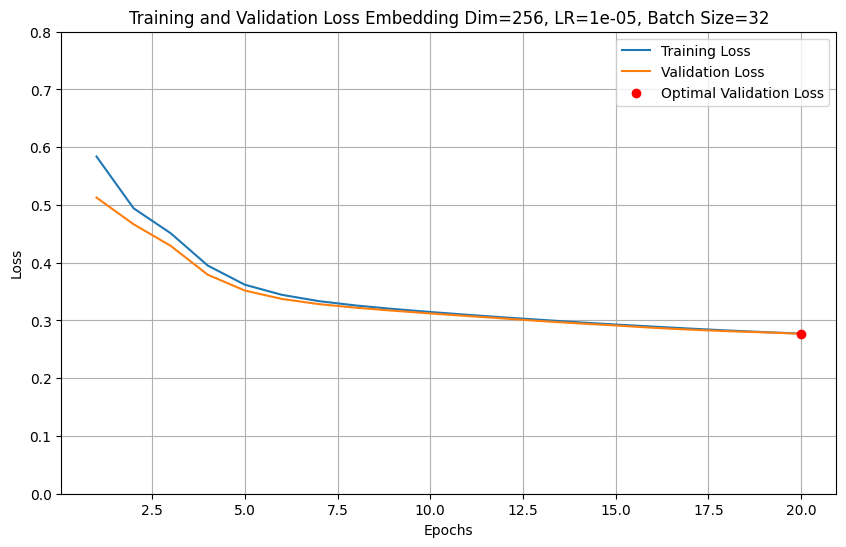

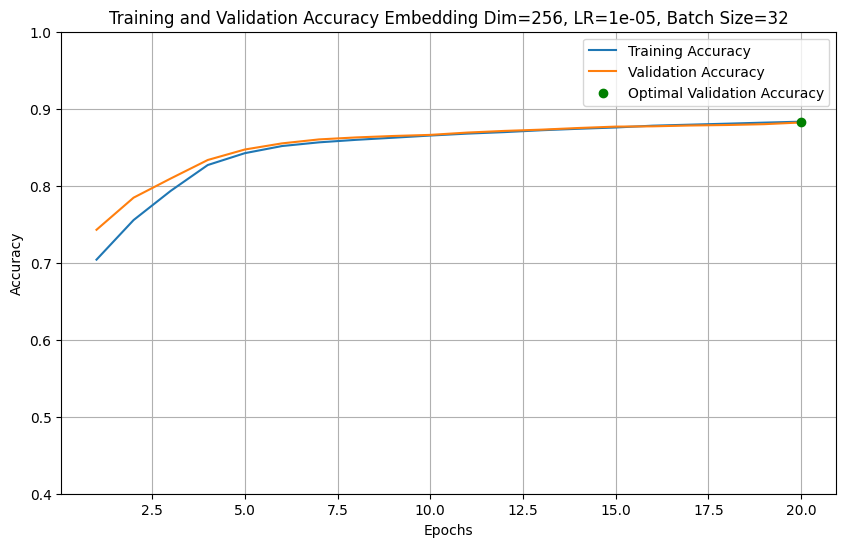



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Validation Loss: 0.2281 at Epoch 20
Optimal Validation Accuracy: 0.9076 at Epoch 20 



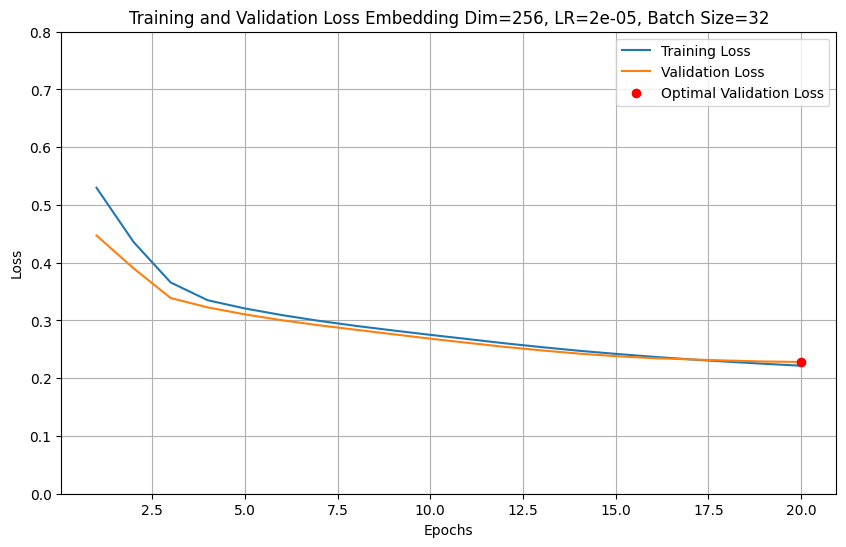

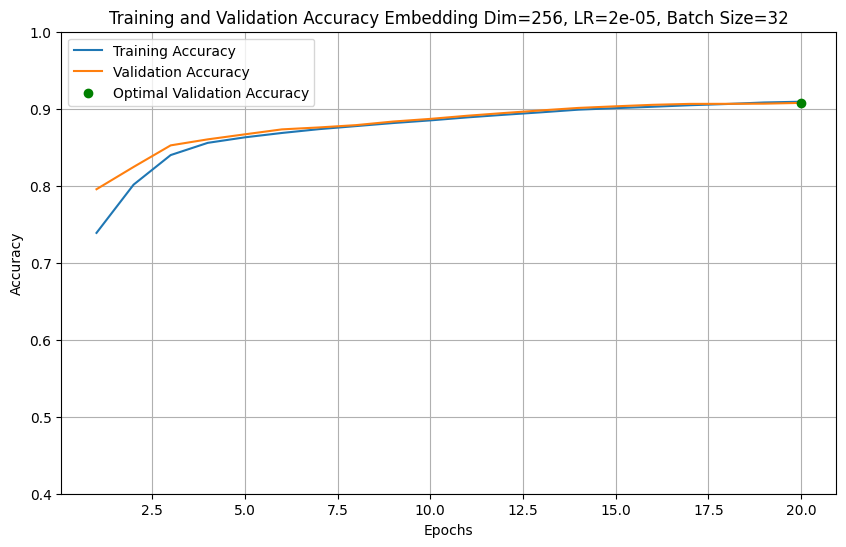



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Validation Loss: 0.2269 at Epoch 20
Optimal Validation Accuracy: 0.9062 at Epoch 20 



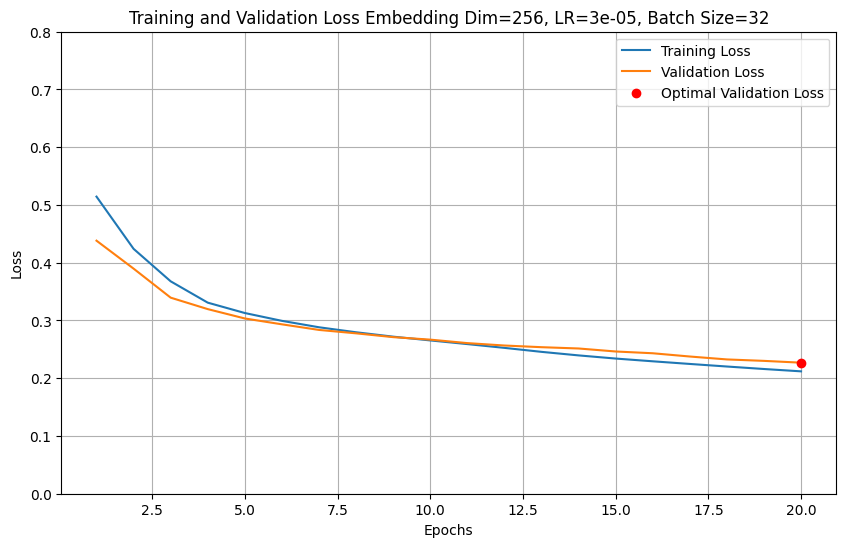

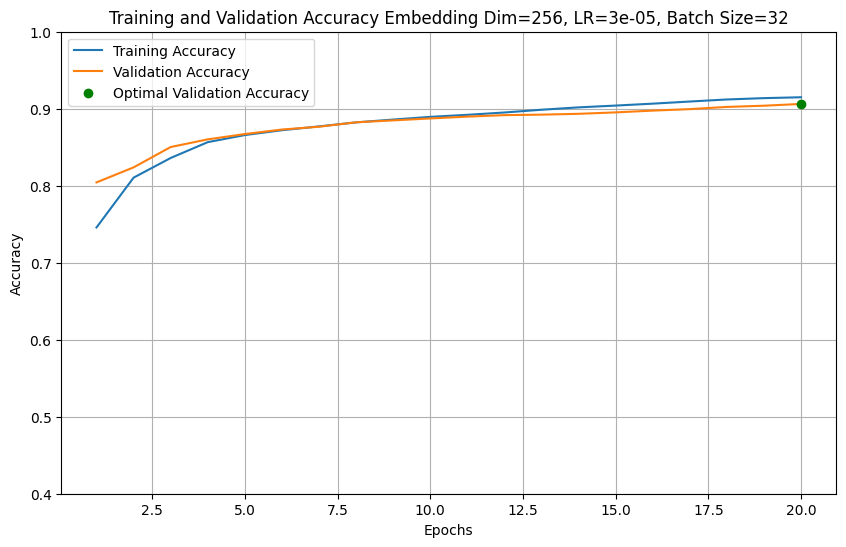



---------------------------------------------------------------------------------------------------- 



In [ ]:
log_path = "/content/drive/MyDrive/Log/training_log.csv"  # Pastikan path benar
log_data = pd.read_csv(log_path)

# List of learning rates to iterate over
learning_rates = [1e-5, 2e-5, 3e-5] # Learning Rate
ED = 256     # Embedding Dimension
BS = 32     # Batch Size

for lr in learning_rates:
    # Filter log data based on the specified hyperparameters
    filtered_log = log_data[
        (log_data['Embedding Dim'] == ED) &
        (log_data['Batch Size'] == BS) &
        (log_data['Learning Rate'] == lr)
    ]

    if filtered_log.empty:
        print(f"No data found for Learning Rate = {lr}!\n")
        print("----\n")
        continue

    # Extract relevant columns
    epochs = filtered_log['Epoch']
    train_loss = filtered_log['Training Loss']
    val_loss = filtered_log['Validation Loss']
    train_accuracy = filtered_log['Training Accuracy']
    val_accuracy = filtered_log['Validation Accuracy']

    # Find optimal epochs
    optimal_val_loss_epoch = val_loss.idxmin()
    optimal_val_accuracy_epoch = val_accuracy.idxmax()

    optimal_val_loss = val_loss.loc[optimal_val_loss_epoch]
    optimal_val_accuracy = val_accuracy.loc[optimal_val_accuracy_epoch]

    # Print optimal results for the current learning rate
    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Validation Loss: {optimal_val_loss:.4f} at Epoch {epochs.loc[optimal_val_loss_epoch]}")
    print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f} at Epoch {epochs.loc[optimal_val_accuracy_epoch]} \n")

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.scatter(epochs.loc[optimal_val_loss_epoch], optimal_val_loss, color='red', label='Optimal Validation Loss', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.8)
    plt.title(f'Training and Validation Loss Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.scatter(epochs.loc[optimal_val_accuracy_epoch], optimal_val_accuracy, color='green', label='Optimal Validation Accuracy', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)  # Mengatur skala y dari 0.4 hingga 1.0
    plt.title(f'Training and Validation Accuracy Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots
    print("----"*25,"\n")


## Batch 8 (256, 64)

### Train

In [ ]:
# Membuat instance dari kelas Main dengan hyperparameter yang diperlukan
main_instance = Main(
    embedding_dim=256,  # Dimensi embedding
    batch_sizes=[64],  # Ukuran batch
    learning_rates=[1e-5, 2e-5, 3e-5],  # Daftar learning rates yang akan diuji
    num_epochs=20  # Jumlah epoch pelatihan
)

# Memanggil metode start_training untuk memulai proses
main_instance.start_training()

-----------------START TRAINING-----------------

1. Dataset Loaded

2. Data Splitted
Training set size: 69781
Testing set size: 17446 

GPU detected. Using GPU for training.

Hyperparameters for Current Training:
 - Embedding Dim : 256
 - Batch Size    : 64
 - Learning Rate : 1e-05
 - Epochs        : 20
Epoch 1/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 46s 42ms/step - accuracy: 0.6200 - loss: 0.6571 - val_accuracy: 0.7379 - val_loss: 0.5329

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Epoch 2/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.7464 - loss: 0.5138 - val_accuracy: 0.7871 - val_loss: 0.4562

Training log saved at /content/drive/MyDrive/Log/training_log.csv


Model saved: /content/drive/MyDrive/Model/cnn_attention_ed(256)_lr(1e-05)_bs(64)_epoch(2).keras

Epoch 3/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.7915 - loss: 0.4567 - val_accuracy: 0.8019 - val_loss: 0.4342

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Ep

### Plot Evaluate Model

Results for Learning Rate = 1e-05:

Optimal Validation Loss: 0.3024 at Epoch 20
Optimal Validation Accuracy: 0.8723 at Epoch 20 



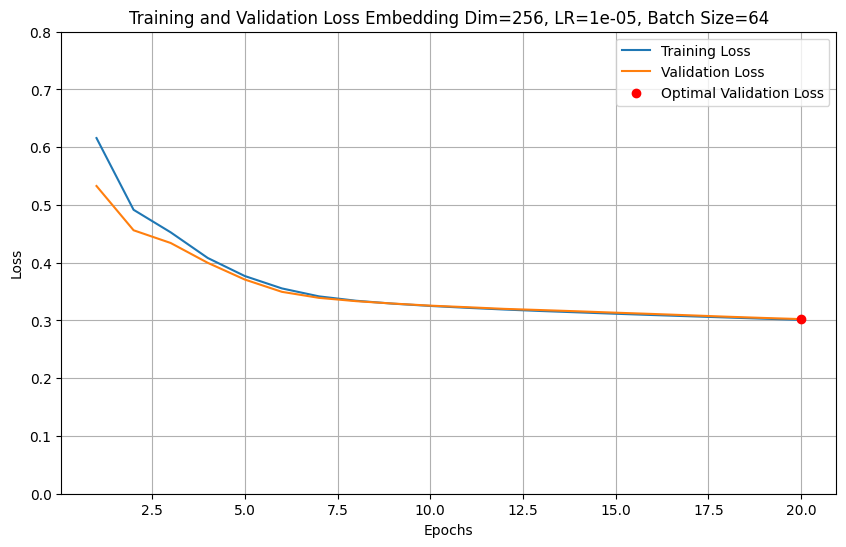

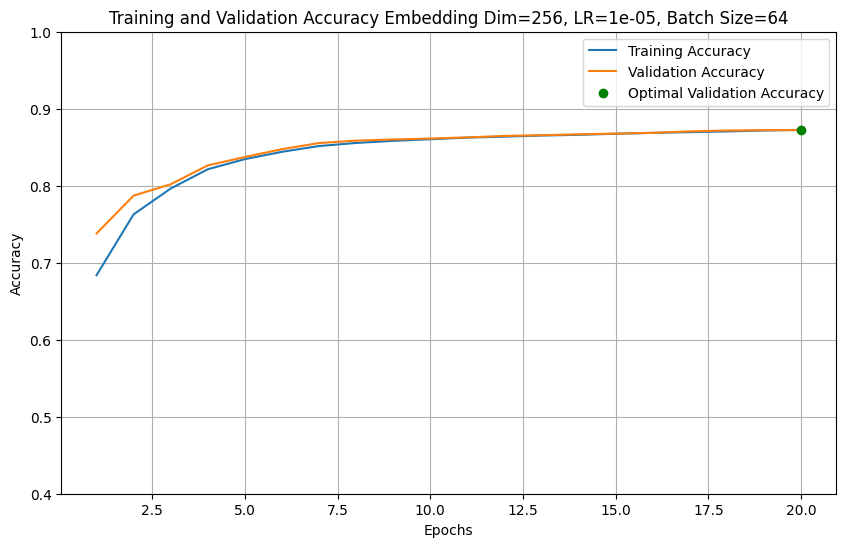



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Validation Loss: 0.2528 at Epoch 20
Optimal Validation Accuracy: 0.8960 at Epoch 20 



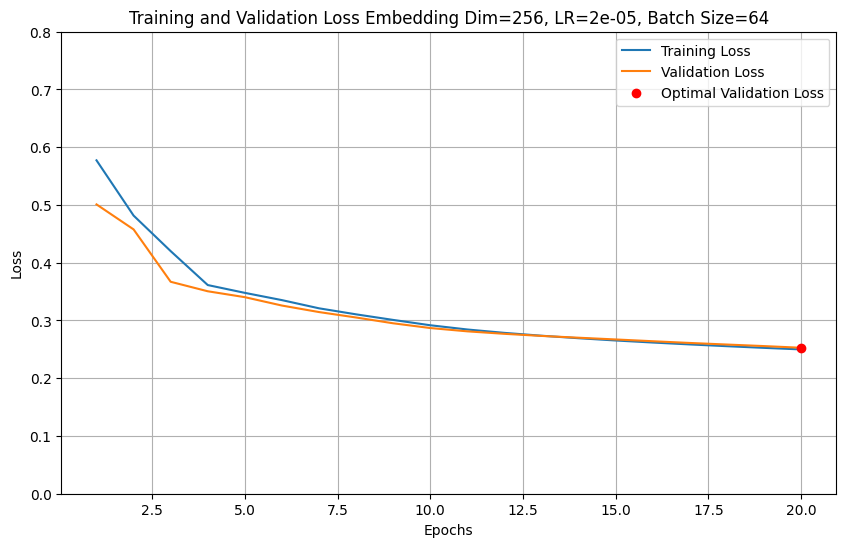

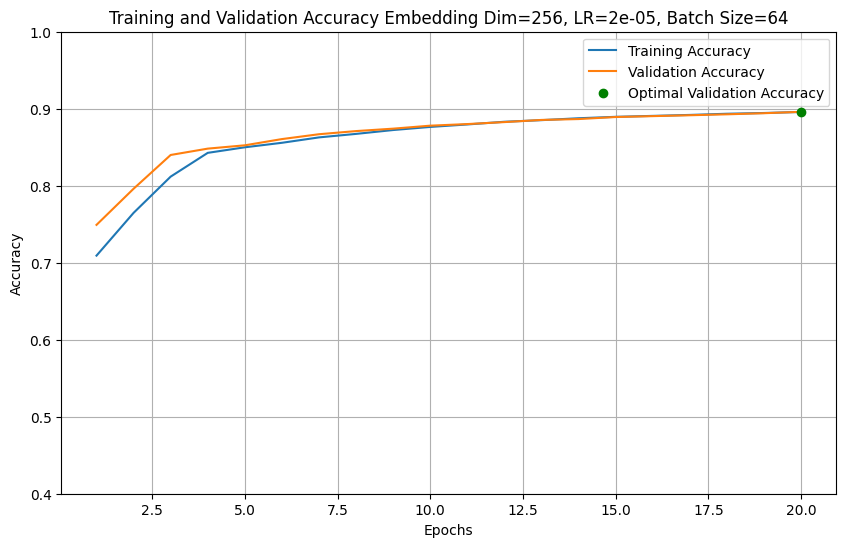



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Validation Loss: 0.2312 at Epoch 20
Optimal Validation Accuracy: 0.9049 at Epoch 19 



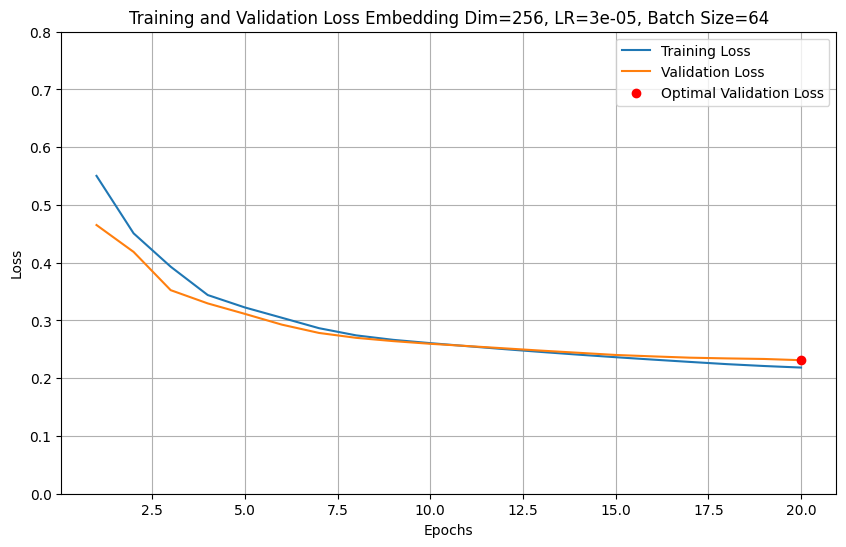

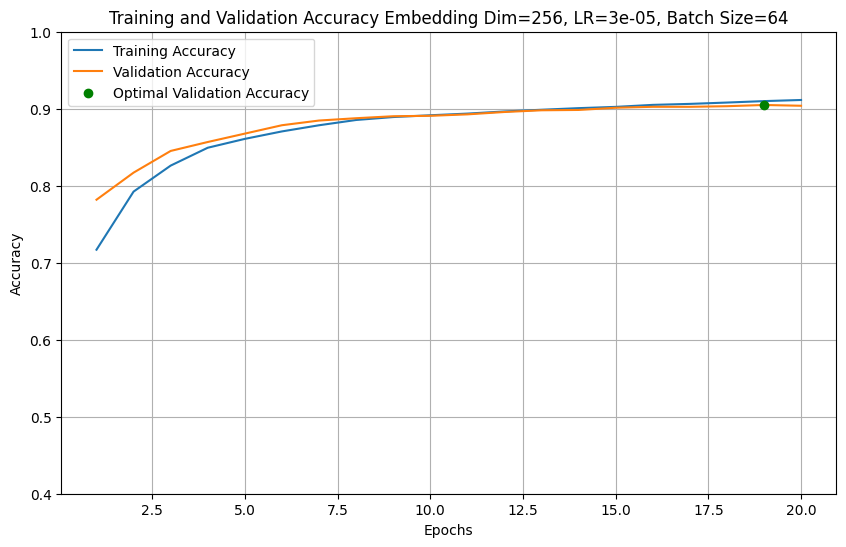



---------------------------------------------------------------------------------------------------- 



In [ ]:
log_path = "/content/drive/MyDrive/Log/training_log.csv"  # Pastikan path benar
log_data = pd.read_csv(log_path)

# List of learning rates to iterate over
learning_rates = [1e-5, 2e-5, 3e-5] # Learning Rate
ED = 256     # Embedding Dimension
BS = 64     # Batch Size

for lr in learning_rates:
    # Filter log data based on the specified hyperparameters
    filtered_log = log_data[
        (log_data['Embedding Dim'] == ED) &
        (log_data['Batch Size'] == BS) &
        (log_data['Learning Rate'] == lr)
    ]

    if filtered_log.empty:
        print(f"No data found for Learning Rate = {lr}!\n")
        print("----\n")
        continue

    # Extract relevant columns
    epochs = filtered_log['Epoch']
    train_loss = filtered_log['Training Loss']
    val_loss = filtered_log['Validation Loss']
    train_accuracy = filtered_log['Training Accuracy']
    val_accuracy = filtered_log['Validation Accuracy']

    # Find optimal epochs
    optimal_val_loss_epoch = val_loss.idxmin()
    optimal_val_accuracy_epoch = val_accuracy.idxmax()

    optimal_val_loss = val_loss.loc[optimal_val_loss_epoch]
    optimal_val_accuracy = val_accuracy.loc[optimal_val_accuracy_epoch]

    # Print optimal results for the current learning rate
    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Validation Loss: {optimal_val_loss:.4f} at Epoch {epochs.loc[optimal_val_loss_epoch]}")
    print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f} at Epoch {epochs.loc[optimal_val_accuracy_epoch]} \n")

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.scatter(epochs.loc[optimal_val_loss_epoch], optimal_val_loss, color='red', label='Optimal Validation Loss', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.8)
    plt.title(f'Training and Validation Loss Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.scatter(epochs.loc[optimal_val_accuracy_epoch], optimal_val_accuracy, color='green', label='Optimal Validation Accuracy', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)  # Mengatur skala y dari 0.4 hingga 1.0
    plt.title(f'Training and Validation Accuracy Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots
    print("----"*25,"\n")


## Batch 9 (256, 128)

### Train

In [ ]:
# Membuat instance dari kelas Main dengan hyperparameter yang diperlukan
main_instance = Main(
    embedding_dim=256,  # Dimensi embedding
    batch_sizes=[128],  # Ukuran batch
    learning_rates=[1e-5, 2e-5, 3e-5],  # Daftar learning rates yang akan diuji
    num_epochs=20  # Jumlah epoch pelatihan
)

# Memanggil metode start_training untuk memulai proses
main_instance.start_training()

-----------------START TRAINING-----------------

1. Dataset Loaded

2. Data Splitted
Training set size: 69781
Testing set size: 17446 

GPU detected. Using GPU for training.

Hyperparameters for Current Training:
 - Embedding Dim : 256
 - Batch Size    : 128
 - Learning Rate : 1e-05
 - Epochs        : 20
Epoch 1/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 47s 81ms/step - accuracy: 0.6256 - loss: 0.6712 - val_accuracy: 0.7362 - val_loss: 0.5623

Training log saved at /content/drive/MyDrive/Log/training_log.csv

Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.7355 - loss: 0.5454 - val_accuracy: 0.7407 - val_loss: 0.5091

Training log saved at /content/drive/MyDrive/Log/training_log.csv


Model saved: /content/drive/MyDrive/Model/cnn_attention_ed(256)_lr(1e-05)_bs(128)_epoch(2).keras

Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.7452 - loss: 0.5045 - val_accuracy: 0.7734 - val_loss: 0.4654

Training log saved at /content/drive/MyDrive/Log/training_log.csv



### Plot Evaluate Model

Results for Learning Rate = 1e-05:

Optimal Validation Loss: 0.3170 at Epoch 20
Optimal Validation Accuracy: 0.8634 at Epoch 20 



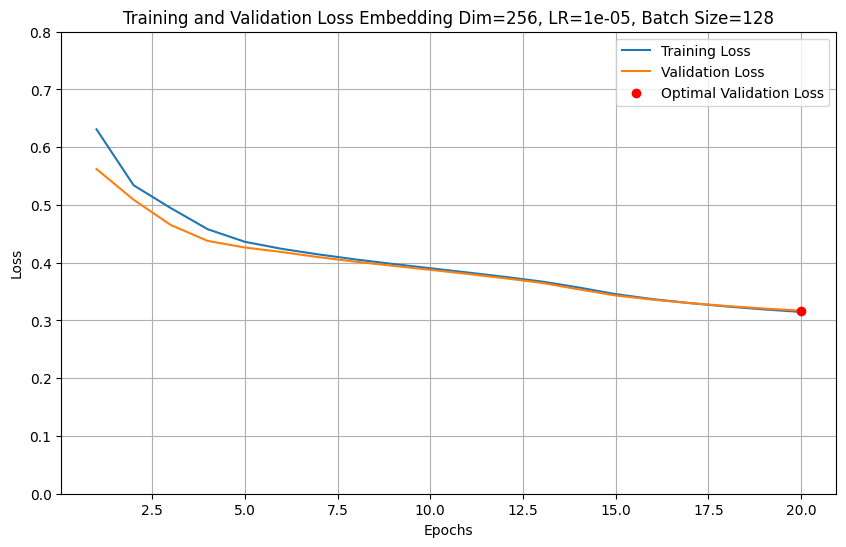

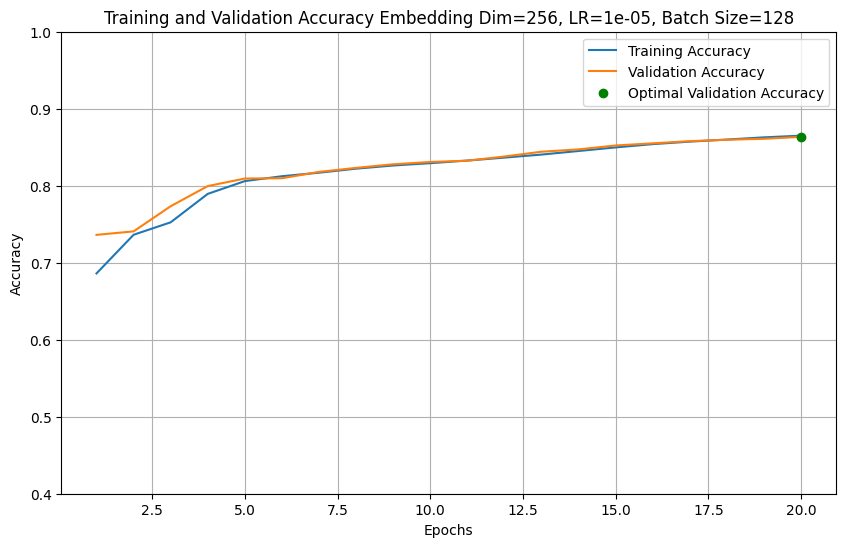



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Validation Loss: 0.2936 at Epoch 20
Optimal Validation Accuracy: 0.8760 at Epoch 20 



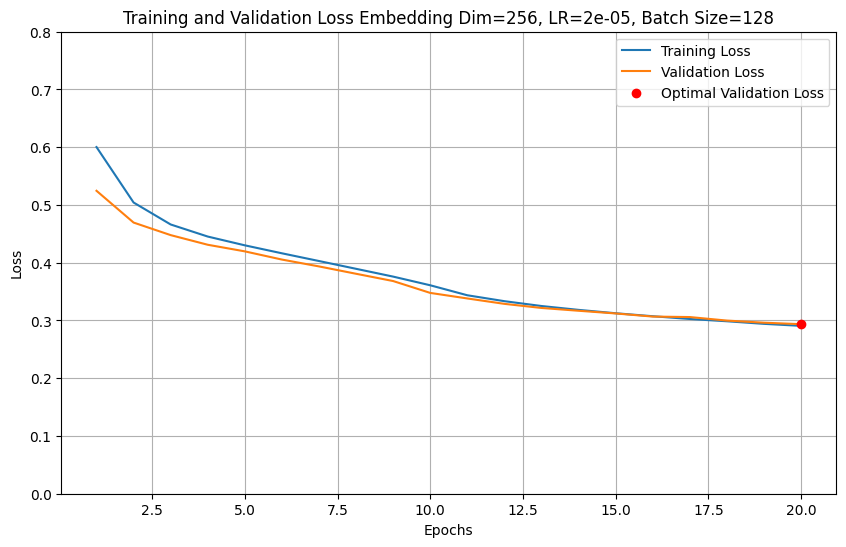

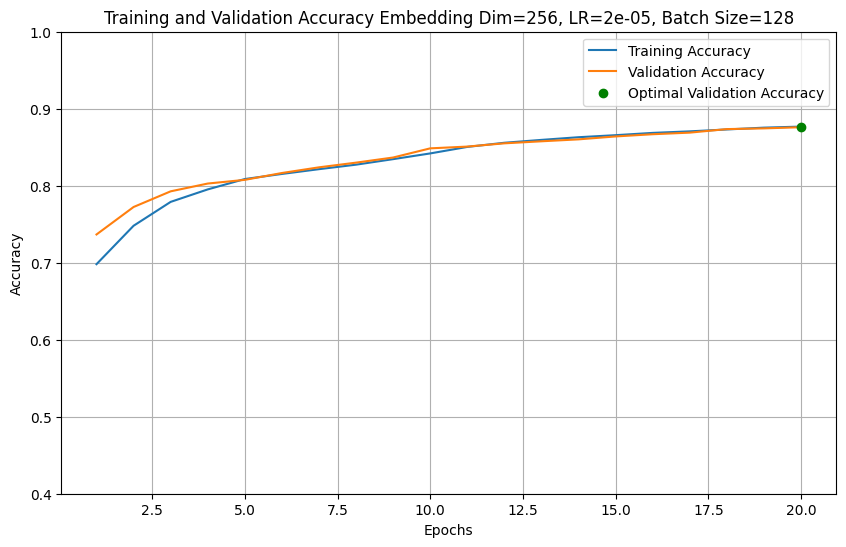



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Validation Loss: 0.2503 at Epoch 20
Optimal Validation Accuracy: 0.8962 at Epoch 20 



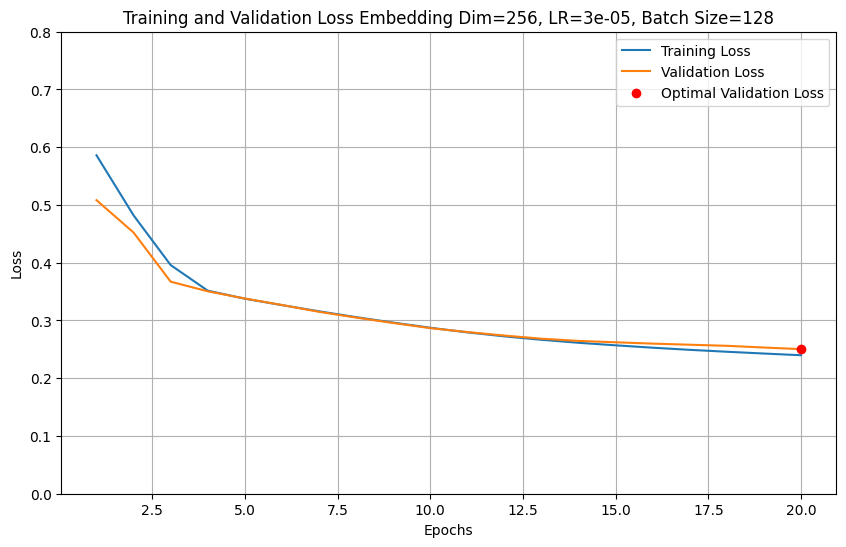

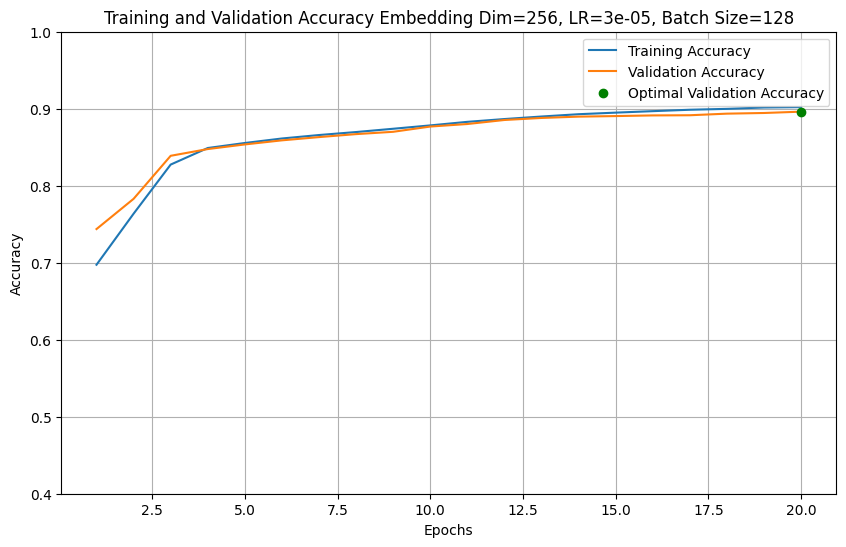



---------------------------------------------------------------------------------------------------- 



In [ ]:
log_path = "/content/drive/MyDrive/Log/training_log.csv"  # Pastikan path benar
log_data = pd.read_csv(log_path)

# List of learning rates to iterate over
learning_rates = [1e-5, 2e-5, 3e-5] # Learning Rate
ED = 256     # Embedding Dimension
BS = 128     # Batch Size

for lr in learning_rates:
    # Filter log data based on the specified hyperparameters
    filtered_log = log_data[
        (log_data['Embedding Dim'] == ED) &
        (log_data['Batch Size'] == BS) &
        (log_data['Learning Rate'] == lr)
    ]

    if filtered_log.empty:
        print(f"No data found for Learning Rate = {lr}!\n")
        print("----\n")
        continue

    # Extract relevant columns
    epochs = filtered_log['Epoch']
    train_loss = filtered_log['Training Loss']
    val_loss = filtered_log['Validation Loss']
    train_accuracy = filtered_log['Training Accuracy']
    val_accuracy = filtered_log['Validation Accuracy']

    # Find optimal epochs
    optimal_val_loss_epoch = val_loss.idxmin()
    optimal_val_accuracy_epoch = val_accuracy.idxmax()

    optimal_val_loss = val_loss.loc[optimal_val_loss_epoch]
    optimal_val_accuracy = val_accuracy.loc[optimal_val_accuracy_epoch]

    # Print optimal results for the current learning rate
    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Validation Loss: {optimal_val_loss:.4f} at Epoch {epochs.loc[optimal_val_loss_epoch]}")
    print(f"Optimal Validation Accuracy: {optimal_val_accuracy:.4f} at Epoch {epochs.loc[optimal_val_accuracy_epoch]} \n")

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.scatter(epochs.loc[optimal_val_loss_epoch], optimal_val_loss, color='red', label='Optimal Validation Loss', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.8)
    plt.title(f'Training and Validation Loss Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.scatter(epochs.loc[optimal_val_accuracy_epoch], optimal_val_accuracy, color='green', label='Optimal Validation Accuracy', zorder=5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)  # Mengatur skala y dari 0.4 hingga 1.0
    plt.title(f'Training and Validation Accuracy Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n")  # Add spacing between plots
    print("----"*25,"\n")


# 5. Hasil Pengujian

## Batch 1 (64, 32)

Results for Learning Rate = 1e-05:

Optimal Accuracy: 0.8760 at Epoch 20
Optimal Precision: 0.8639 at Epoch 20
Optimal Recall: 0.8599 at Epoch 20 



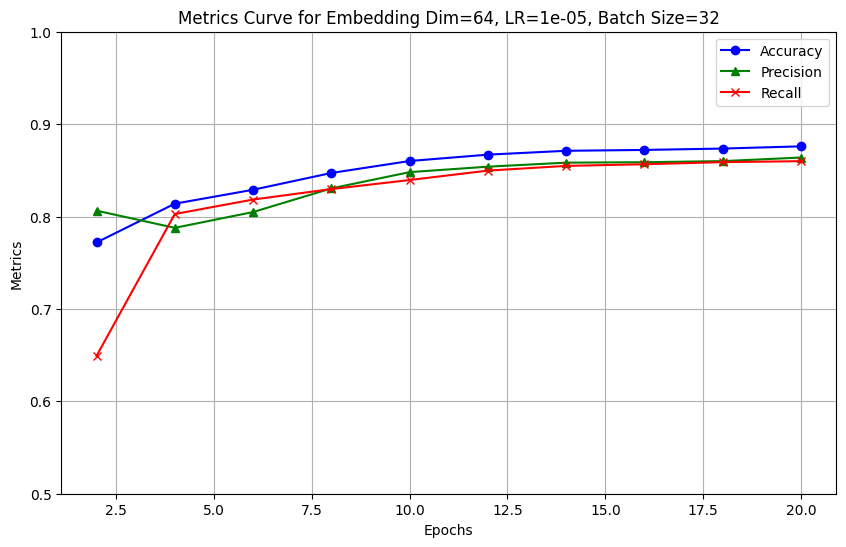



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Accuracy: 0.8794 at Epoch 20
Optimal Precision: 0.8525 at Epoch 20
Optimal Recall: 0.8851 at Epoch 20 



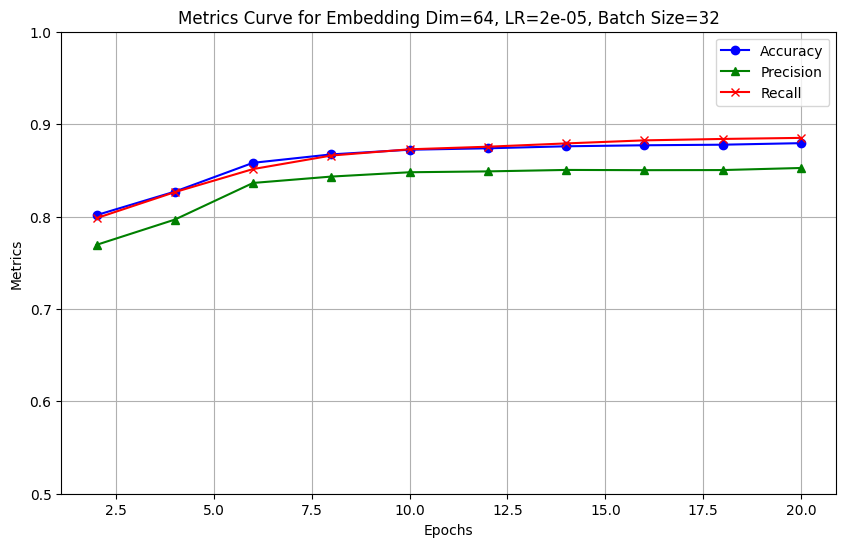



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Accuracy: 0.8930 at Epoch 20
Optimal Precision: 0.8903 at Epoch 6
Optimal Recall: 0.8721 at Epoch 20 



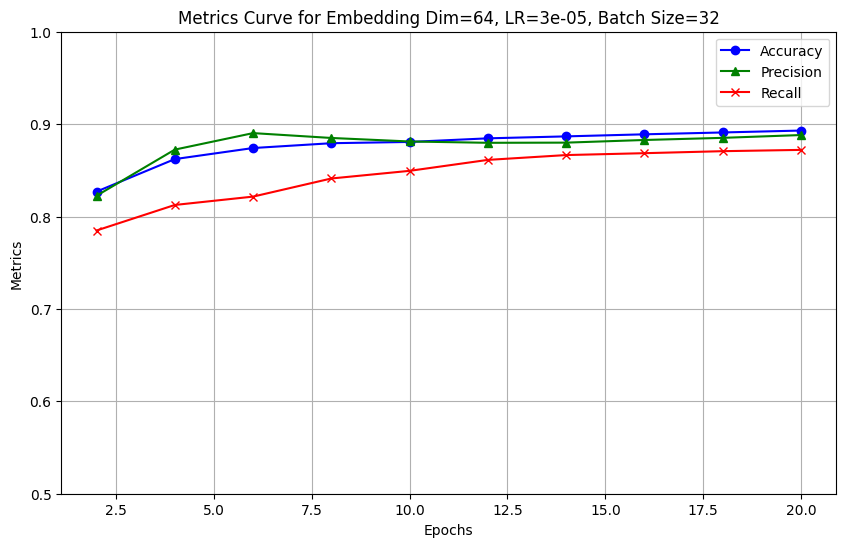



---------------------------------------------------------------------------------------------------- 



In [ ]:
# Path ke log evaluasi
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"  # Pastikan path benar
evaluation_data = pd.read_csv(evaluation_log_path)

# Hyperparameter untuk filter
learning_rates = [1e-5, 2e-5, 3e-5]  # Learning Rate
ED = 64  # Embedding Dimension
BS = 32  # Batch Size

for lr in learning_rates:
    # Filter data evaluasi berdasarkan hyperparameter dan kelipatan epoch
    filtered_data = evaluation_data[
        evaluation_data['Model Name'].str.contains(
            rf"cnn_attention_ed\({ED}\)_lr\({lr}\)_bs\({BS}\)_epoch\(\d+\)", regex=True
        )
    ]

    if filtered_data.empty:
        print(f"No evaluation data found for Learning Rate = {lr}, Embedding Dim = {ED}, Batch Size = {BS}!\n")
        print("----\n")
        continue

    # Buat salinan eksplisit untuk menghindari SettingWithCopyWarning
    filtered_data = filtered_data.copy()

    # Ekstrak epoch dari nama model
    filtered_data['Epoch'] = filtered_data['Model Name'].str.extract(r"epoch\((\d+)\)")[0].astype(int)

    # Sortir berdasarkan epoch
    filtered_data = filtered_data.sort_values('Epoch')

    # Ekstrak kolom yang relevan
    epochs = filtered_data['Epoch']
    accuracy = filtered_data['Accuracy']
    precision_plt = filtered_data['Precision']
    recall_plt = filtered_data['Recall']

    # Ekstrak nama model tanpa epoch
    model_name_without_epoch = filtered_data['Model Name'].iloc[0].split('_epoch(')[0]

    # Cetak hasil terbaik untuk setiap learning rate
    optimal_accuracy_epoch = accuracy.idxmax()
    optimal_precision_epoch = precision_plt.idxmax()
    optimal_recall_epoch = recall_plt.idxmax()

    optimal_accuracy = accuracy.loc[optimal_accuracy_epoch]
    optimal_precision = precision_plt.loc[optimal_precision_epoch]
    optimal_recall = recall_plt.loc[optimal_recall_epoch]

    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Accuracy: {optimal_accuracy:.4f} at Epoch {epochs.loc[optimal_accuracy_epoch]}")
    print(f"Optimal Precision: {optimal_precision:.4f} at Epoch {epochs.loc[optimal_precision_epoch]}")
    print(f"Optimal Recall: {optimal_recall:.4f} at Epoch {epochs.loc[optimal_recall_epoch]} \n")

    # Plot Accuracy, F1-Score, Precision, dan Recall dalam satu kurva
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
    plt.plot(epochs, precision_plt, marker='^', label='Precision', color='green')
    plt.plot(epochs, recall_plt, marker='x', label='Recall', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0.5, 1.0)
    plt.title(f'Metrics Curve for Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.grid()
    plt.legend()
    plt.show()

    print("\n")  # Tambahkan spasi antar plot

    print("----" * 25, "\n")


## Batch 2 (64, 64)

Results for Learning Rate = 1e-05:

Optimal Accuracy: 0.8703 at Epoch 20
Optimal Precision: 0.8786 at Epoch 20
Optimal Recall: 0.8259 at Epoch 20 



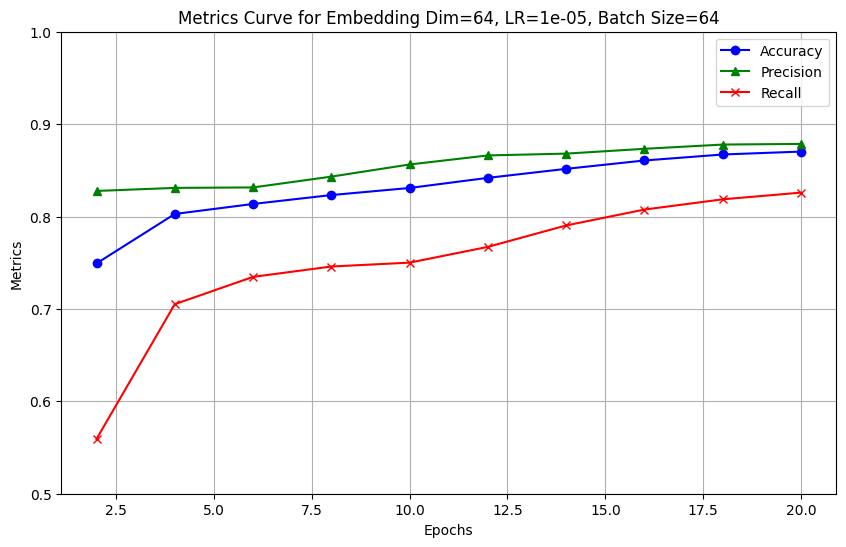



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Accuracy: 0.8788 at Epoch 20
Optimal Precision: 0.8637 at Epoch 20
Optimal Recall: 0.8677 at Epoch 20 



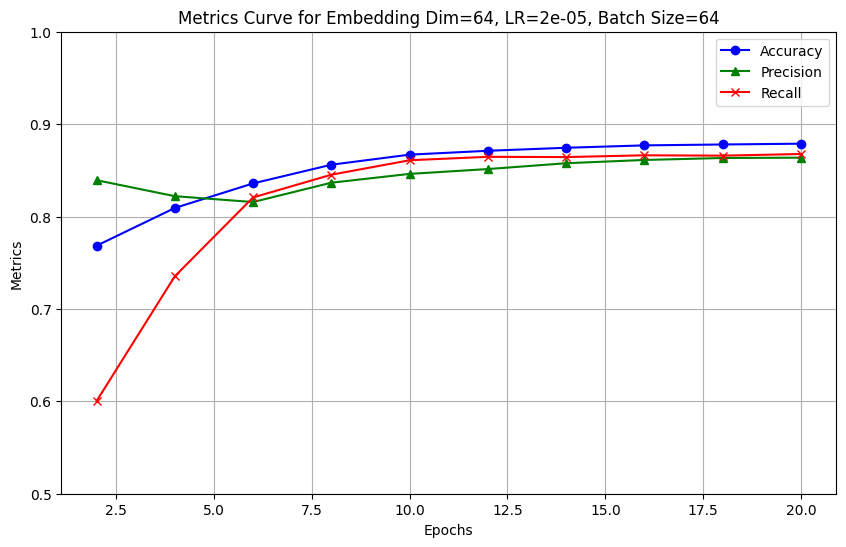



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Accuracy: 0.8862 at Epoch 20
Optimal Precision: 0.8998 at Epoch 16
Optimal Recall: 0.8460 at Epoch 20 



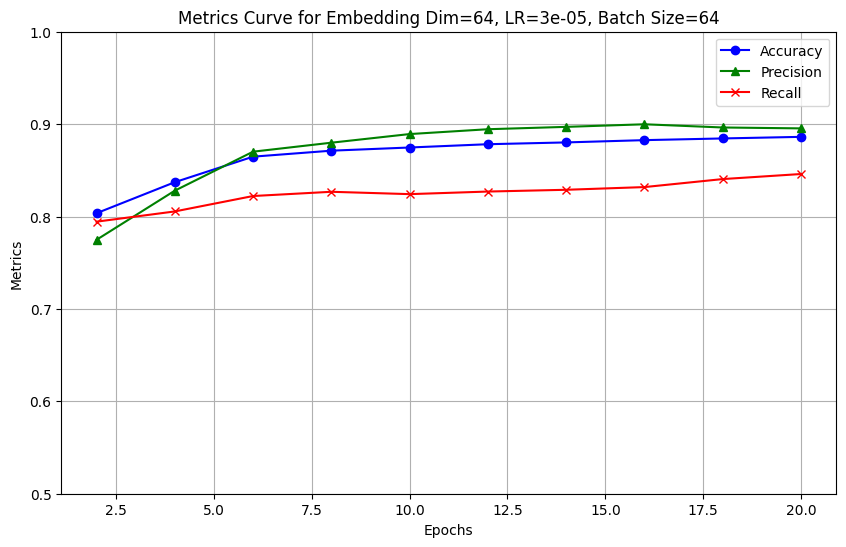



---------------------------------------------------------------------------------------------------- 



In [ ]:
# Path ke log evaluasi
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"  # Pastikan path benar
evaluation_data = pd.read_csv(evaluation_log_path)

# Hyperparameter untuk filter
learning_rates = [1e-5, 2e-5, 3e-5]  # Learning Rate
ED = 64  # Embedding Dimension
BS = 64  # Batch Size

for lr in learning_rates:
    # Filter data evaluasi berdasarkan hyperparameter dan kelipatan epoch
    filtered_data = evaluation_data[
        evaluation_data['Model Name'].str.contains(
            rf"cnn_attention_ed\({ED}\)_lr\({lr}\)_bs\({BS}\)_epoch\(\d+\)", regex=True
        )
    ]

    if filtered_data.empty:
        print(f"No evaluation data found for Learning Rate = {lr}, Embedding Dim = {ED}, Batch Size = {BS}!\n")
        print("----\n")
        continue

    # Buat salinan eksplisit untuk menghindari SettingWithCopyWarning
    filtered_data = filtered_data.copy()

    # Ekstrak epoch dari nama model
    filtered_data['Epoch'] = filtered_data['Model Name'].str.extract(r"epoch\((\d+)\)")[0].astype(int)

    # Sortir berdasarkan epoch
    filtered_data = filtered_data.sort_values('Epoch')

    # Ekstrak kolom yang relevan
    epochs = filtered_data['Epoch']
    accuracy = filtered_data['Accuracy']
    precision_plt = filtered_data['Precision']
    recall_plt = filtered_data['Recall']

    # Ekstrak nama model tanpa epoch
    model_name_without_epoch = filtered_data['Model Name'].iloc[0].split('_epoch(')[0]

    # Cetak hasil terbaik untuk setiap learning rate
    optimal_accuracy_epoch = accuracy.idxmax()
    optimal_precision_epoch = precision_plt.idxmax()
    optimal_recall_epoch = recall_plt.idxmax()

    optimal_accuracy = accuracy.loc[optimal_accuracy_epoch]
    optimal_precision = precision_plt.loc[optimal_precision_epoch]
    optimal_recall = recall_plt.loc[optimal_recall_epoch]

    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Accuracy: {optimal_accuracy:.4f} at Epoch {epochs.loc[optimal_accuracy_epoch]}")
    print(f"Optimal Precision: {optimal_precision:.4f} at Epoch {epochs.loc[optimal_precision_epoch]}")
    print(f"Optimal Recall: {optimal_recall:.4f} at Epoch {epochs.loc[optimal_recall_epoch]} \n")

    # Plot Accuracy, F1-Score, Precision, dan Recall dalam satu kurva
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
    plt.plot(epochs, precision_plt, marker='^', label='Precision', color='green')
    plt.plot(epochs, recall_plt, marker='x', label='Recall', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0.5, 1.0)
    plt.title(f'Metrics Curve for Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.grid()
    plt.legend()
    plt.show()

    print("\n")  # Tambahkan spasi antar plot

    print("----" * 25, "\n")


## Batch 3 (64, 128)

Results for Learning Rate = 1e-05:

Optimal Accuracy: 0.8572 at Epoch 20
Optimal Precision: 0.8773 at Epoch 20
Optimal Recall: 0.7935 at Epoch 20 



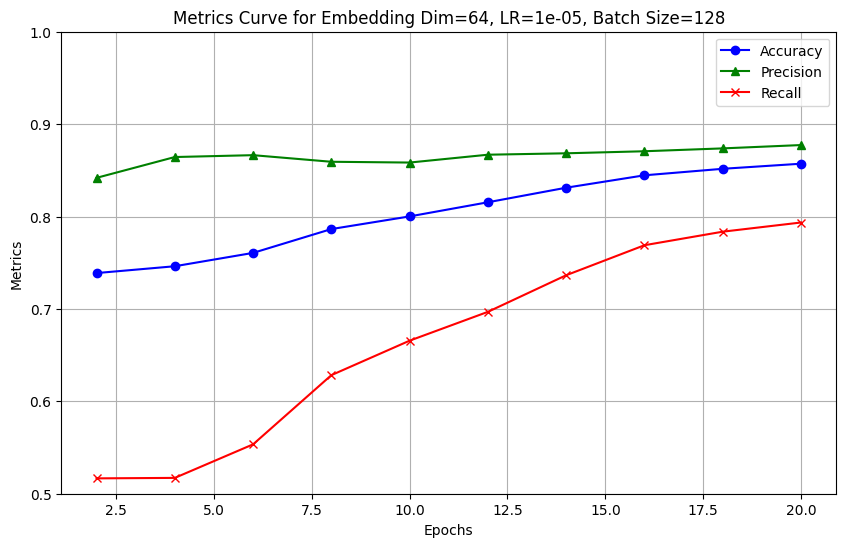



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Accuracy: 0.8728 at Epoch 20
Optimal Precision: 0.8619 at Epoch 20
Optimal Recall: 0.8544 at Epoch 18 



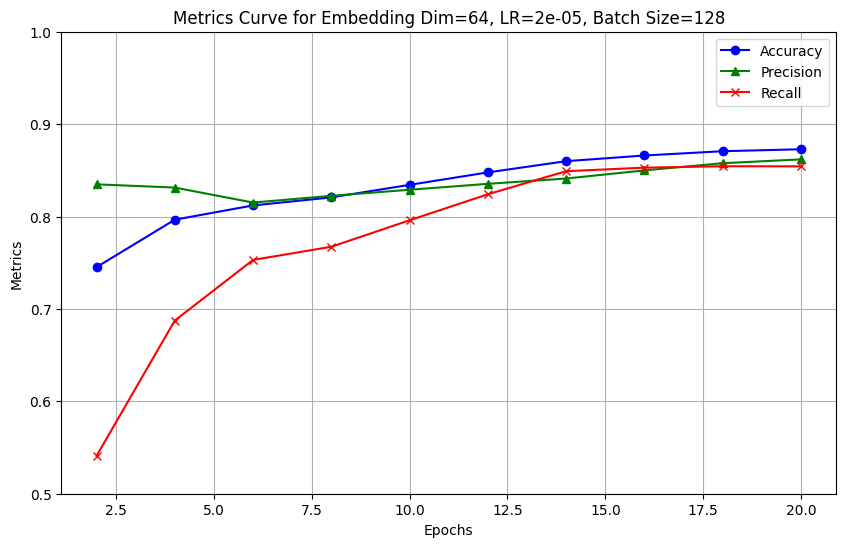



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Accuracy: 0.8821 at Epoch 20
Optimal Precision: 0.9180 at Epoch 20
Optimal Recall: 0.8103 at Epoch 20 



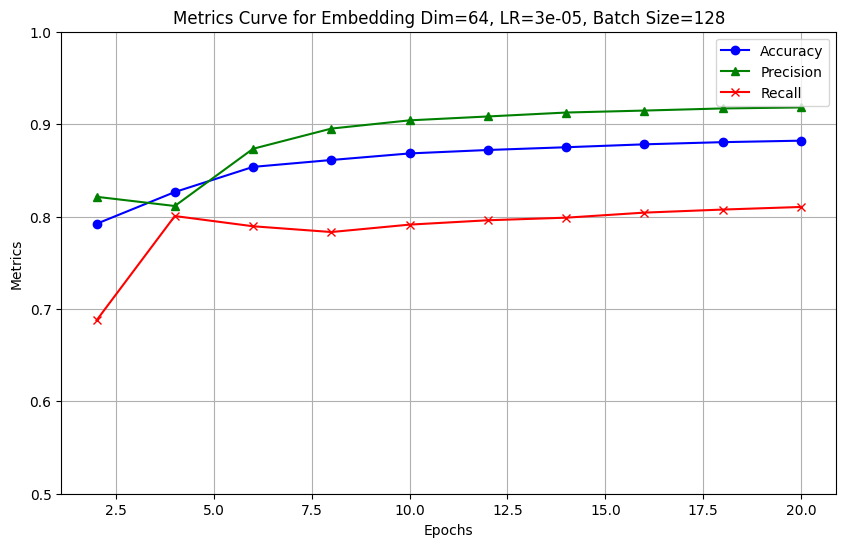



---------------------------------------------------------------------------------------------------- 



In [ ]:
# Path ke log evaluasi
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"  # Pastikan path benar
evaluation_data = pd.read_csv(evaluation_log_path)

# Hyperparameter untuk filter
learning_rates = [1e-5, 2e-5, 3e-5]  # Learning Rate
ED = 64  # Embedding Dimension
BS = 128  # Batch Size

for lr in learning_rates:
    # Filter data evaluasi berdasarkan hyperparameter dan kelipatan epoch
    filtered_data = evaluation_data[
        evaluation_data['Model Name'].str.contains(
            rf"cnn_attention_ed\({ED}\)_lr\({lr}\)_bs\({BS}\)_epoch\(\d+\)", regex=True
        )
    ]

    if filtered_data.empty:
        print(f"No evaluation data found for Learning Rate = {lr}, Embedding Dim = {ED}, Batch Size = {BS}!\n")
        print("----\n")
        continue

    # Buat salinan eksplisit untuk menghindari SettingWithCopyWarning
    filtered_data = filtered_data.copy()

    # Ekstrak epoch dari nama model
    filtered_data['Epoch'] = filtered_data['Model Name'].str.extract(r"epoch\((\d+)\)")[0].astype(int)

    # Sortir berdasarkan epoch
    filtered_data = filtered_data.sort_values('Epoch')

    # Ekstrak kolom yang relevan
    epochs = filtered_data['Epoch']
    accuracy = filtered_data['Accuracy']
    precision_plt = filtered_data['Precision']
    recall_plt = filtered_data['Recall']

    # Ekstrak nama model tanpa epoch
    model_name_without_epoch = filtered_data['Model Name'].iloc[0].split('_epoch(')[0]

    # Cetak hasil terbaik untuk setiap learning rate
    optimal_accuracy_epoch = accuracy.idxmax()
    optimal_precision_epoch = precision_plt.idxmax()
    optimal_recall_epoch = recall_plt.idxmax()

    optimal_accuracy = accuracy.loc[optimal_accuracy_epoch]
    optimal_precision = precision_plt.loc[optimal_precision_epoch]
    optimal_recall = recall_plt.loc[optimal_recall_epoch]

    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Accuracy: {optimal_accuracy:.4f} at Epoch {epochs.loc[optimal_accuracy_epoch]}")
    print(f"Optimal Precision: {optimal_precision:.4f} at Epoch {epochs.loc[optimal_precision_epoch]}")
    print(f"Optimal Recall: {optimal_recall:.4f} at Epoch {epochs.loc[optimal_recall_epoch]} \n")

    # Plot Accuracy, F1-Score, Precision, dan Recall dalam satu kurva
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
    plt.plot(epochs, precision_plt, marker='^', label='Precision', color='green')
    plt.plot(epochs, recall_plt, marker='x', label='Recall', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0.5, 1.0)
    plt.title(f'Metrics Curve for Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.grid()
    plt.legend()
    plt.show()

    print("\n")  # Tambahkan spasi antar plot

    print("----" * 25, "\n")


## Batch 4 (128, 32)

Results for Learning Rate = 1e-05:

Optimal Accuracy: 0.8791 at Epoch 20
Optimal Precision: 0.8605 at Epoch 20
Optimal Recall: 0.8728 at Epoch 20 



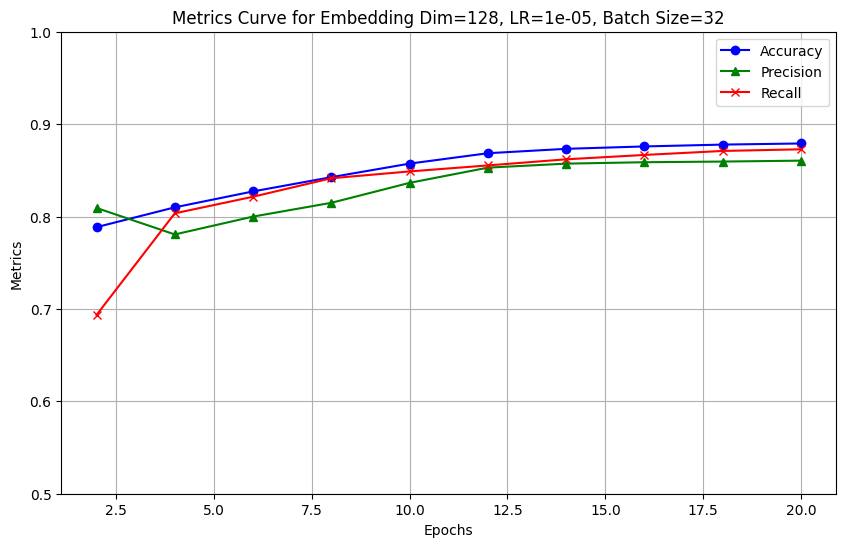



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Accuracy: 0.8879 at Epoch 20
Optimal Precision: 0.8982 at Epoch 16
Optimal Recall: 0.8505 at Epoch 20 



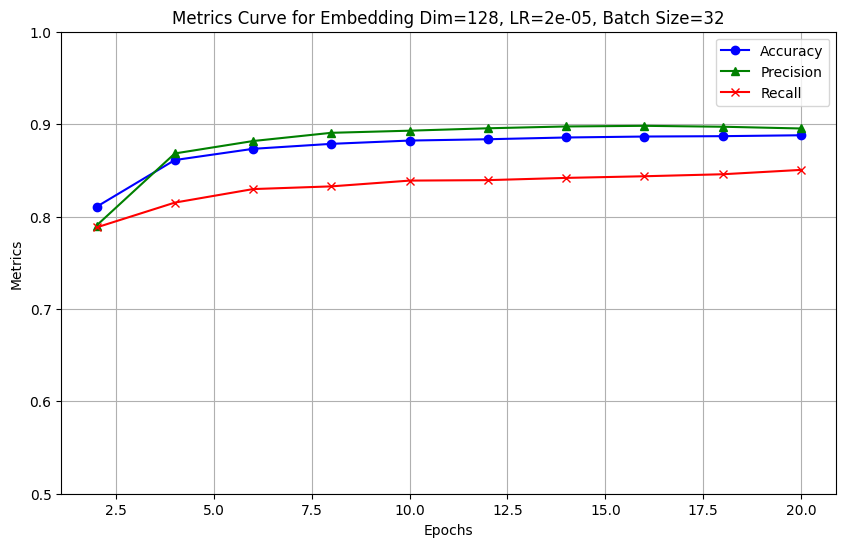



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Accuracy: 0.9100 at Epoch 20
Optimal Precision: 0.9112 at Epoch 12
Optimal Recall: 0.8883 at Epoch 20 



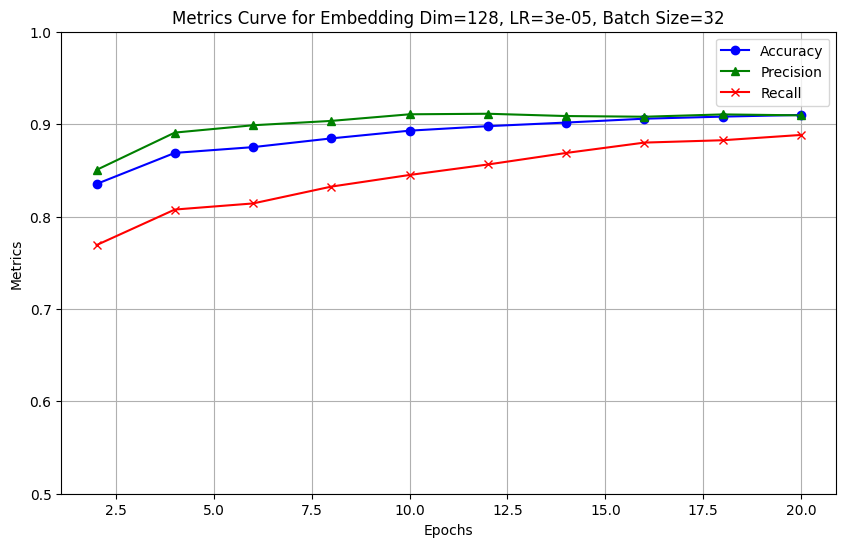



---------------------------------------------------------------------------------------------------- 



In [ ]:
# Path ke log evaluasi
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"  # Pastikan path benar
evaluation_data = pd.read_csv(evaluation_log_path)

# Hyperparameter untuk filter
learning_rates = [1e-5, 2e-5, 3e-5]  # Learning Rate
ED = 128  # Embedding Dimension
BS = 32  # Batch Size

for lr in learning_rates:
    # Filter data evaluasi berdasarkan hyperparameter dan kelipatan epoch
    filtered_data = evaluation_data[
        evaluation_data['Model Name'].str.contains(
            rf"cnn_attention_ed\({ED}\)_lr\({lr}\)_bs\({BS}\)_epoch\(\d+\)", regex=True
        )
    ]

    if filtered_data.empty:
        print(f"No evaluation data found for Learning Rate = {lr}, Embedding Dim = {ED}, Batch Size = {BS}!\n")
        print("----\n")
        continue

    # Buat salinan eksplisit untuk menghindari SettingWithCopyWarning
    filtered_data = filtered_data.copy()

    # Ekstrak epoch dari nama model
    filtered_data['Epoch'] = filtered_data['Model Name'].str.extract(r"epoch\((\d+)\)")[0].astype(int)

    # Sortir berdasarkan epoch
    filtered_data = filtered_data.sort_values('Epoch')

    # Ekstrak kolom yang relevan
    epochs = filtered_data['Epoch']
    accuracy = filtered_data['Accuracy']
    precision_plt = filtered_data['Precision']
    recall_plt = filtered_data['Recall']

    # Ekstrak nama model tanpa epoch
    model_name_without_epoch = filtered_data['Model Name'].iloc[0].split('_epoch(')[0]

    # Cetak hasil terbaik untuk setiap learning rate
    optimal_accuracy_epoch = accuracy.idxmax()
    optimal_precision_epoch = precision_plt.idxmax()
    optimal_recall_epoch = recall_plt.idxmax()

    optimal_accuracy = accuracy.loc[optimal_accuracy_epoch]
    optimal_precision = precision_plt.loc[optimal_precision_epoch]
    optimal_recall = recall_plt.loc[optimal_recall_epoch]

    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Accuracy: {optimal_accuracy:.4f} at Epoch {epochs.loc[optimal_accuracy_epoch]}")
    print(f"Optimal Precision: {optimal_precision:.4f} at Epoch {epochs.loc[optimal_precision_epoch]}")
    print(f"Optimal Recall: {optimal_recall:.4f} at Epoch {epochs.loc[optimal_recall_epoch]} \n")

    # Plot Accuracy, F1-Score, Precision, dan Recall dalam satu kurva
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
    plt.plot(epochs, precision_plt, marker='^', label='Precision', color='green')
    plt.plot(epochs, recall_plt, marker='x', label='Recall', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0.5, 1.0)
    plt.title(f'Metrics Curve for Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.grid()
    plt.legend()
    plt.show()

    print("\n")  # Tambahkan spasi antar plot

    print("----" * 25, "\n")


## Batch 5 (128, 64)

Results for Learning Rate = 1e-05:

Optimal Accuracy: 0.8741 at Epoch 20
Optimal Precision: 0.8562 at Epoch 20
Optimal Recall: 0.8660 at Epoch 18 



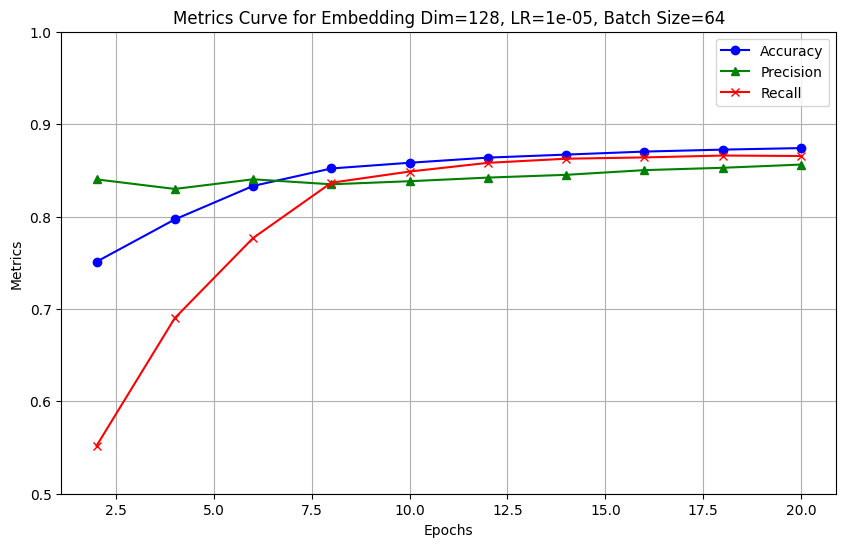



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Accuracy: 0.8862 at Epoch 20
Optimal Precision: 0.8824 at Epoch 20
Optimal Recall: 0.8621 at Epoch 20 



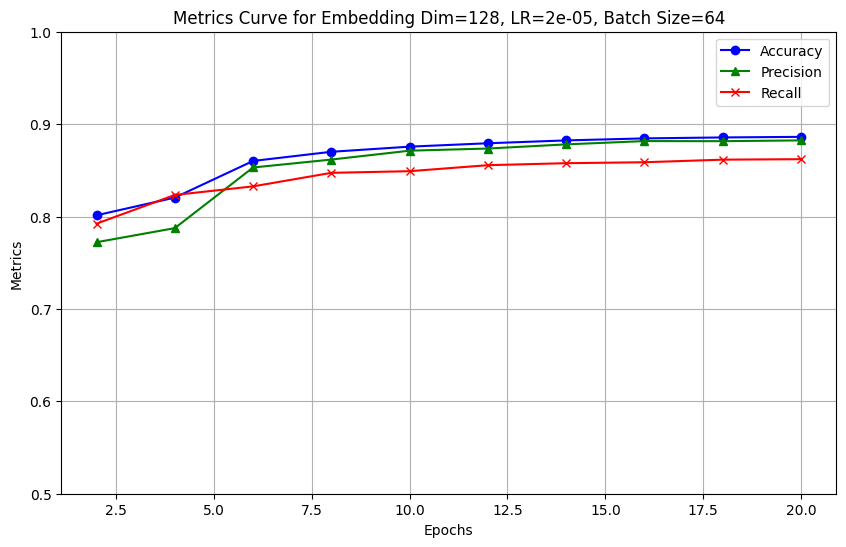



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Accuracy: 0.8881 at Epoch 20
Optimal Precision: 0.9123 at Epoch 20
Optimal Recall: 0.8808 at Epoch 4 



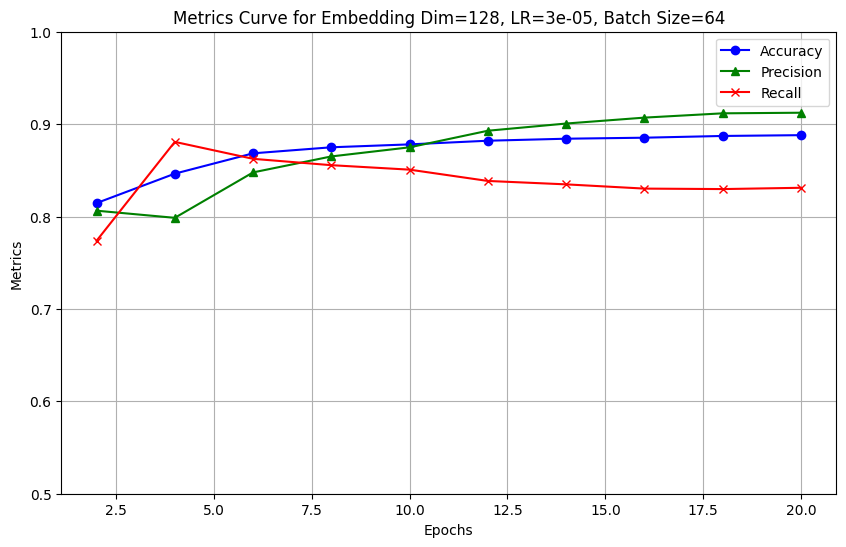



---------------------------------------------------------------------------------------------------- 



In [ ]:
# Path ke log evaluasi
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"  # Pastikan path benar
evaluation_data = pd.read_csv(evaluation_log_path)

# Hyperparameter untuk filter
learning_rates = [1e-5, 2e-5, 3e-5]  # Learning Rate
ED = 128  # Embedding Dimension
BS = 64  # Batch Size

for lr in learning_rates:
    # Filter data evaluasi berdasarkan hyperparameter dan kelipatan epoch
    filtered_data = evaluation_data[
        evaluation_data['Model Name'].str.contains(
            rf"cnn_attention_ed\({ED}\)_lr\({lr}\)_bs\({BS}\)_epoch\(\d+\)", regex=True
        )
    ]

    if filtered_data.empty:
        print(f"No evaluation data found for Learning Rate = {lr}, Embedding Dim = {ED}, Batch Size = {BS}!\n")
        print("----\n")
        continue

    # Buat salinan eksplisit untuk menghindari SettingWithCopyWarning
    filtered_data = filtered_data.copy()

    # Ekstrak epoch dari nama model
    filtered_data['Epoch'] = filtered_data['Model Name'].str.extract(r"epoch\((\d+)\)")[0].astype(int)

    # Sortir berdasarkan epoch
    filtered_data = filtered_data.sort_values('Epoch')

    # Ekstrak kolom yang relevan
    epochs = filtered_data['Epoch']
    accuracy = filtered_data['Accuracy']
    precision_plt = filtered_data['Precision']
    recall_plt = filtered_data['Recall']

    # Ekstrak nama model tanpa epoch
    model_name_without_epoch = filtered_data['Model Name'].iloc[0].split('_epoch(')[0]

    # Cetak hasil terbaik untuk setiap learning rate
    optimal_accuracy_epoch = accuracy.idxmax()
    optimal_precision_epoch = precision_plt.idxmax()
    optimal_recall_epoch = recall_plt.idxmax()

    optimal_accuracy = accuracy.loc[optimal_accuracy_epoch]
    optimal_precision = precision_plt.loc[optimal_precision_epoch]
    optimal_recall = recall_plt.loc[optimal_recall_epoch]

    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Accuracy: {optimal_accuracy:.4f} at Epoch {epochs.loc[optimal_accuracy_epoch]}")
    print(f"Optimal Precision: {optimal_precision:.4f} at Epoch {epochs.loc[optimal_precision_epoch]}")
    print(f"Optimal Recall: {optimal_recall:.4f} at Epoch {epochs.loc[optimal_recall_epoch]} \n")

    # Plot Accuracy, F1-Score, Precision, dan Recall dalam satu kurva
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
    plt.plot(epochs, precision_plt, marker='^', label='Precision', color='green')
    plt.plot(epochs, recall_plt, marker='x', label='Recall', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0.5, 1.0)
    plt.title(f'Metrics Curve for Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.grid()
    plt.legend()
    plt.show()

    print("\n")  # Tambahkan spasi antar plot

    print("----" * 25, "\n")


## Batch 6 (128, 128)

Results for Learning Rate = 1e-05:

Optimal Accuracy: 0.8700 at Epoch 20
Optimal Precision: 0.8646 at Epoch 20
Optimal Recall: 0.8432 at Epoch 20 



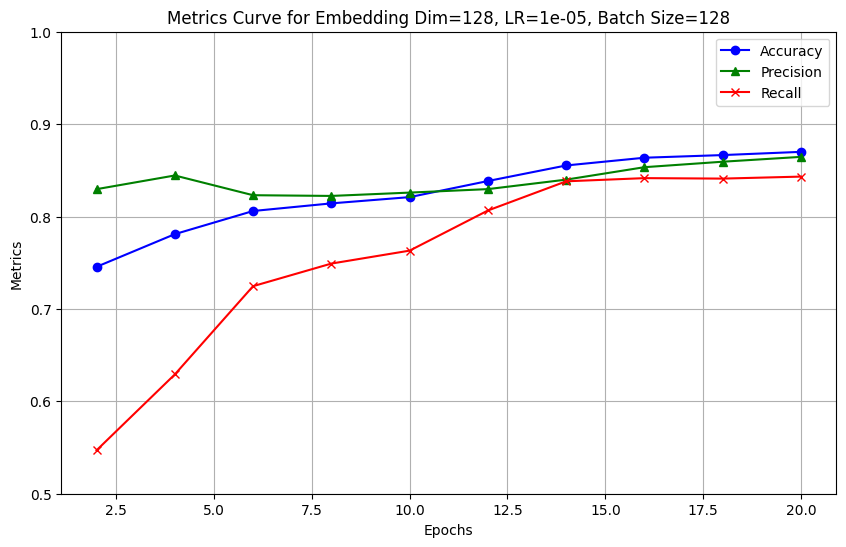



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Accuracy: 0.8797 at Epoch 20
Optimal Precision: 0.9121 at Epoch 18
Optimal Recall: 0.8114 at Epoch 20 



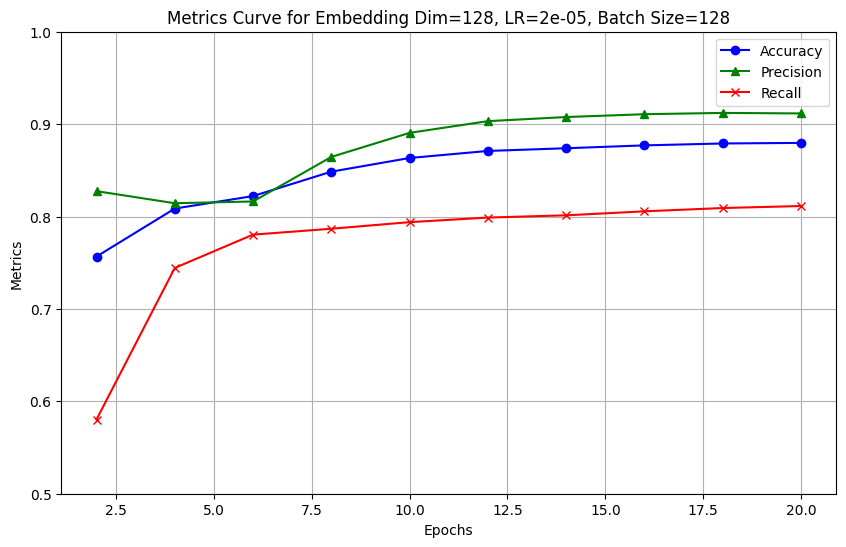



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Accuracy: 0.8854 at Epoch 20
Optimal Precision: 0.9030 at Epoch 20
Optimal Recall: 0.8351 at Epoch 20 



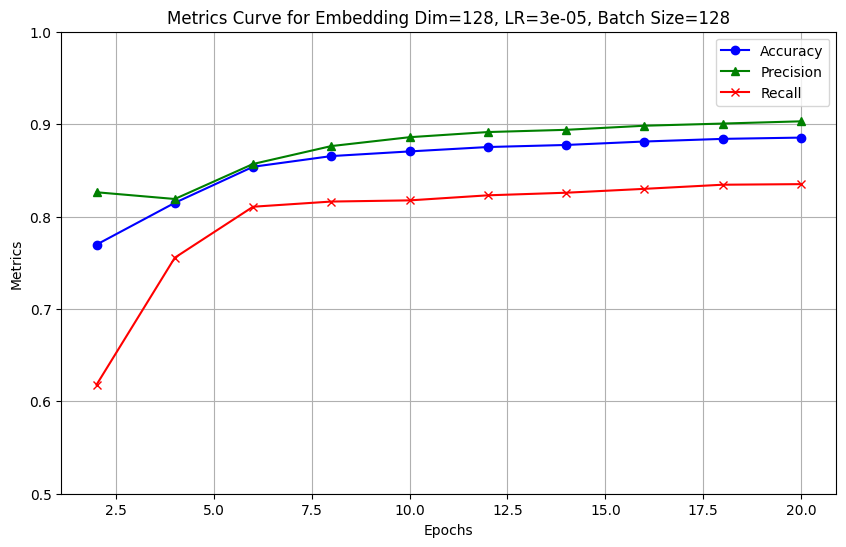



---------------------------------------------------------------------------------------------------- 



In [ ]:
# Path ke log evaluasi
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"  # Pastikan path benar
evaluation_data = pd.read_csv(evaluation_log_path)

# Hyperparameter untuk filter
learning_rates = [1e-5, 2e-5, 3e-5]  # Learning Rate
ED = 128  # Embedding Dimension
BS = 128  # Batch Size

for lr in learning_rates:
    # Filter data evaluasi berdasarkan hyperparameter dan kelipatan epoch
    filtered_data = evaluation_data[
        evaluation_data['Model Name'].str.contains(
            rf"cnn_attention_ed\({ED}\)_lr\({lr}\)_bs\({BS}\)_epoch\(\d+\)", regex=True
        )
    ]

    if filtered_data.empty:
        print(f"No evaluation data found for Learning Rate = {lr}, Embedding Dim = {ED}, Batch Size = {BS}!\n")
        print("----\n")
        continue

    # Buat salinan eksplisit untuk menghindari SettingWithCopyWarning
    filtered_data = filtered_data.copy()

    # Ekstrak epoch dari nama model
    filtered_data['Epoch'] = filtered_data['Model Name'].str.extract(r"epoch\((\d+)\)")[0].astype(int)

    # Sortir berdasarkan epoch
    filtered_data = filtered_data.sort_values('Epoch')

    # Ekstrak kolom yang relevan
    epochs = filtered_data['Epoch']
    accuracy = filtered_data['Accuracy']
    precision_plt = filtered_data['Precision']
    recall_plt = filtered_data['Recall']

    # Ekstrak nama model tanpa epoch
    model_name_without_epoch = filtered_data['Model Name'].iloc[0].split('_epoch(')[0]

    # Cetak hasil terbaik untuk setiap learning rate
    optimal_accuracy_epoch = accuracy.idxmax()
    optimal_precision_epoch = precision_plt.idxmax()
    optimal_recall_epoch = recall_plt.idxmax()

    optimal_accuracy = accuracy.loc[optimal_accuracy_epoch]
    optimal_precision = precision_plt.loc[optimal_precision_epoch]
    optimal_recall = recall_plt.loc[optimal_recall_epoch]

    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Accuracy: {optimal_accuracy:.4f} at Epoch {epochs.loc[optimal_accuracy_epoch]}")
    print(f"Optimal Precision: {optimal_precision:.4f} at Epoch {epochs.loc[optimal_precision_epoch]}")
    print(f"Optimal Recall: {optimal_recall:.4f} at Epoch {epochs.loc[optimal_recall_epoch]} \n")

    # Plot Accuracy, F1-Score, Precision, dan Recall dalam satu kurva
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
    plt.plot(epochs, precision_plt, marker='^', label='Precision', color='green')
    plt.plot(epochs, recall_plt, marker='x', label='Recall', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0.5, 1.0)
    plt.title(f'Metrics Curve for Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.grid()
    plt.legend()
    plt.show()

    print("\n")  # Tambahkan spasi antar plot

    print("----" * 25, "\n")


## Batch 7 (256, 32)

Results for Learning Rate = 1e-05:

Optimal Accuracy: 0.8816 at Epoch 20
Optimal Precision: 0.8659 at Epoch 20
Optimal Recall: 0.8722 at Epoch 18 



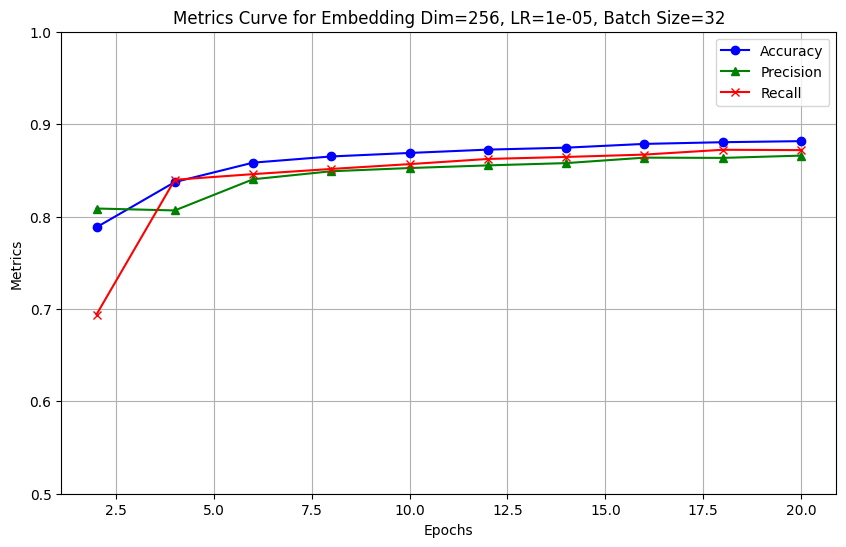



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Accuracy: 0.9040 at Epoch 20
Optimal Precision: 0.9080 at Epoch 16
Optimal Recall: 0.8821 at Epoch 20 



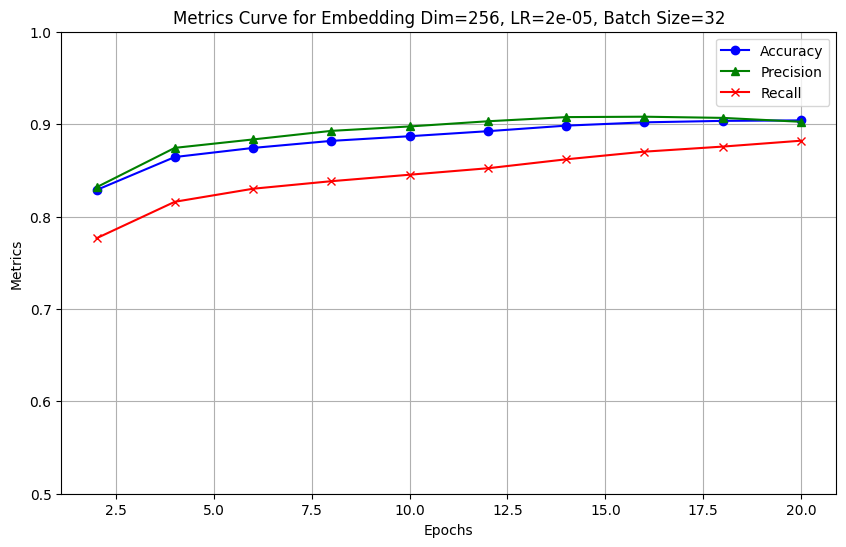



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Accuracy: 0.9053 at Epoch 20
Optimal Precision: 0.9203 at Epoch 20
Optimal Recall: 0.8643 at Epoch 20 



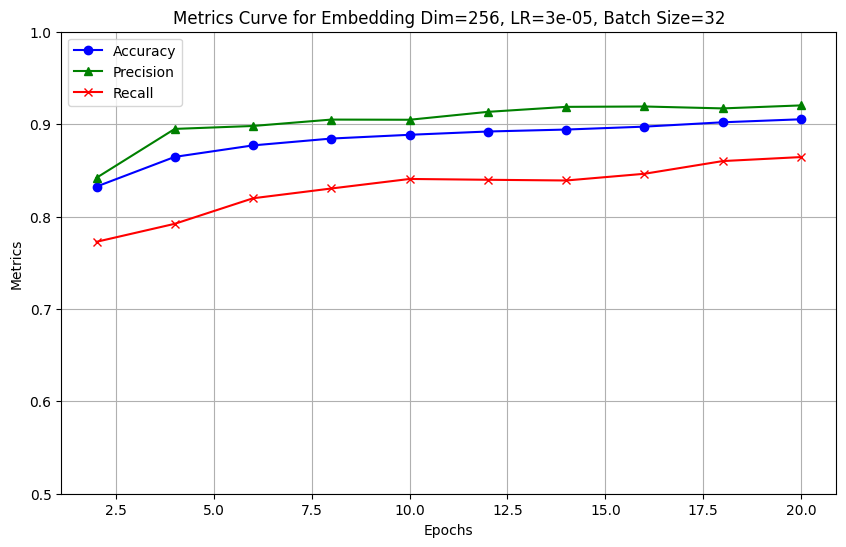



---------------------------------------------------------------------------------------------------- 



In [ ]:
# Path ke log evaluasi
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"  # Pastikan path benar
evaluation_data = pd.read_csv(evaluation_log_path)

# Hyperparameter untuk filter
learning_rates = [1e-5, 2e-5, 3e-5]  # Learning Rate
ED = 256  # Embedding Dimension
BS = 32  # Batch Size

for lr in learning_rates:
    # Filter data evaluasi berdasarkan hyperparameter dan kelipatan epoch
    filtered_data = evaluation_data[
        evaluation_data['Model Name'].str.contains(
            rf"cnn_attention_ed\({ED}\)_lr\({lr}\)_bs\({BS}\)_epoch\(\d+\)", regex=True
        )
    ]

    if filtered_data.empty:
        print(f"No evaluation data found for Learning Rate = {lr}, Embedding Dim = {ED}, Batch Size = {BS}!\n")
        print("----\n")
        continue

    # Buat salinan eksplisit untuk menghindari SettingWithCopyWarning
    filtered_data = filtered_data.copy()

    # Ekstrak epoch dari nama model
    filtered_data['Epoch'] = filtered_data['Model Name'].str.extract(r"epoch\((\d+)\)")[0].astype(int)

    # Sortir berdasarkan epoch
    filtered_data = filtered_data.sort_values('Epoch')

    # Ekstrak kolom yang relevan
    epochs = filtered_data['Epoch']
    accuracy = filtered_data['Accuracy']
    precision_plt = filtered_data['Precision']
    recall_plt = filtered_data['Recall']

    # Ekstrak nama model tanpa epoch
    model_name_without_epoch = filtered_data['Model Name'].iloc[0].split('_epoch(')[0]

    # Cetak hasil terbaik untuk setiap learning rate
    optimal_accuracy_epoch = accuracy.idxmax()
    optimal_precision_epoch = precision_plt.idxmax()
    optimal_recall_epoch = recall_plt.idxmax()

    optimal_accuracy = accuracy.loc[optimal_accuracy_epoch]
    optimal_precision = precision_plt.loc[optimal_precision_epoch]
    optimal_recall = recall_plt.loc[optimal_recall_epoch]

    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Accuracy: {optimal_accuracy:.4f} at Epoch {epochs.loc[optimal_accuracy_epoch]}")
    print(f"Optimal Precision: {optimal_precision:.4f} at Epoch {epochs.loc[optimal_precision_epoch]}")
    print(f"Optimal Recall: {optimal_recall:.4f} at Epoch {epochs.loc[optimal_recall_epoch]} \n")

    # Plot Accuracy, F1-Score, Precision, dan Recall dalam satu kurva
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
    plt.plot(epochs, precision_plt, marker='^', label='Precision', color='green')
    plt.plot(epochs, recall_plt, marker='x', label='Recall', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0.5, 1.0)
    plt.title(f'Metrics Curve for Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.grid()
    plt.legend()
    plt.show()

    print("\n")  # Tambahkan spasi antar plot

    print("----" * 25, "\n")


## Batch 8 (256, 64)

Results for Learning Rate = 1e-05:

Optimal Accuracy: 0.8753 at Epoch 20
Optimal Precision: 0.8690 at Epoch 20
Optimal Recall: 0.8526 at Epoch 14 



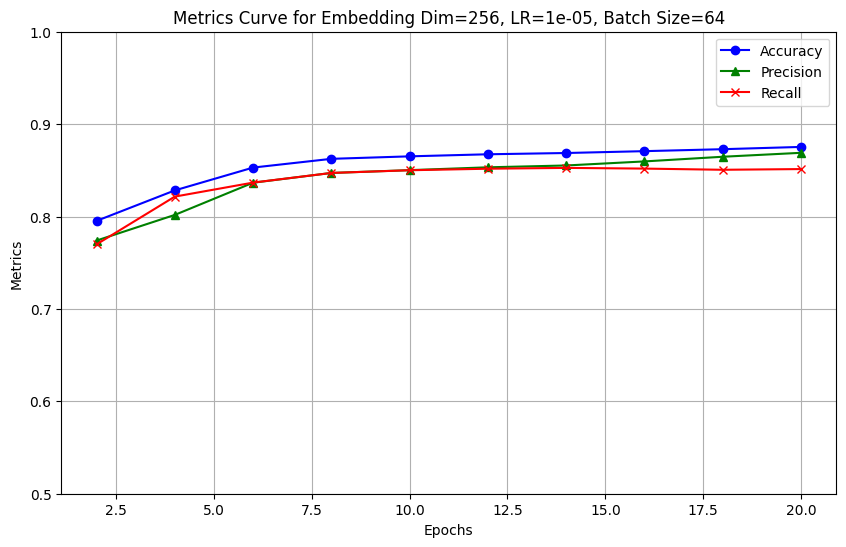



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Accuracy: 0.8918 at Epoch 20
Optimal Precision: 0.9098 at Epoch 16
Optimal Recall: 0.8469 at Epoch 10 



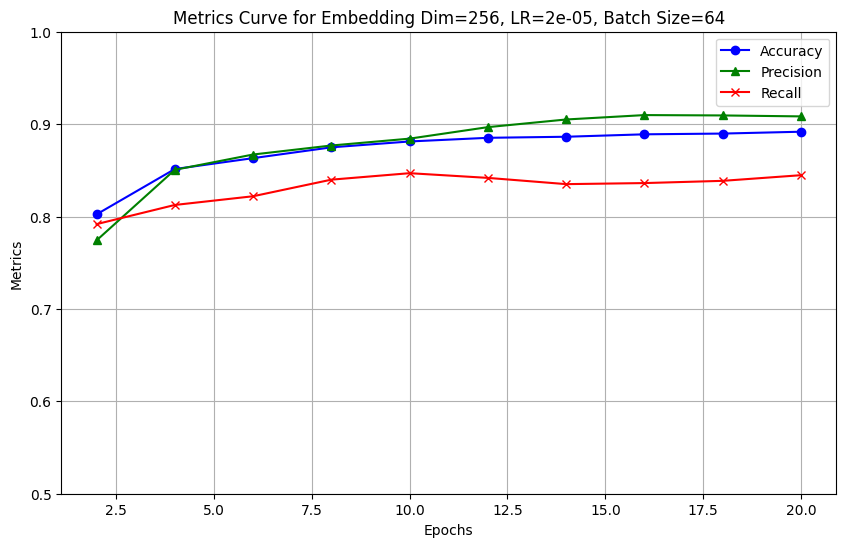



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Accuracy: 0.9031 at Epoch 20
Optimal Precision: 0.9014 at Epoch 16
Optimal Recall: 0.8940 at Epoch 20 



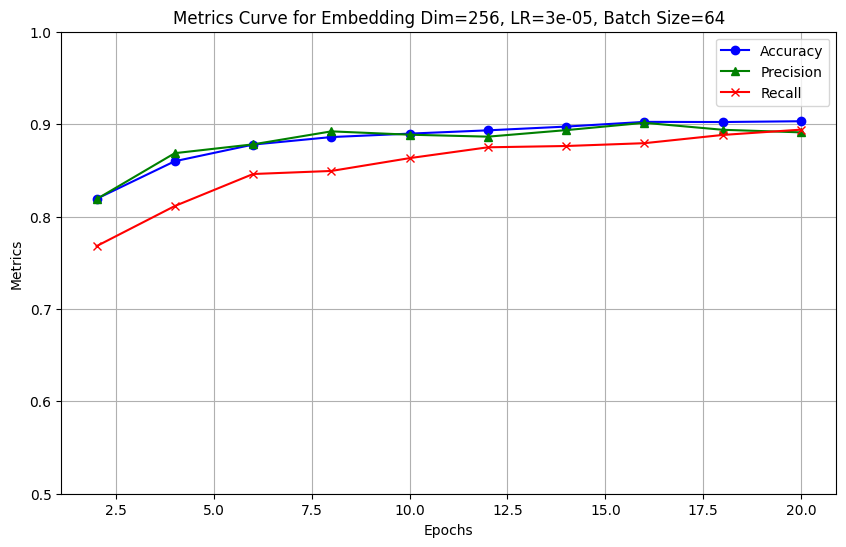



---------------------------------------------------------------------------------------------------- 



In [ ]:
# Path ke log evaluasi
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"  # Pastikan path benar
evaluation_data = pd.read_csv(evaluation_log_path)

# Hyperparameter untuk filter
learning_rates = [1e-5, 2e-5, 3e-5]  # Learning Rate
ED = 256  # Embedding Dimension
BS = 64  # Batch Size

for lr in learning_rates:
    # Filter data evaluasi berdasarkan hyperparameter dan kelipatan epoch
    filtered_data = evaluation_data[
        evaluation_data['Model Name'].str.contains(
            rf"cnn_attention_ed\({ED}\)_lr\({lr}\)_bs\({BS}\)_epoch\(\d+\)", regex=True
        )
    ]

    if filtered_data.empty:
        print(f"No evaluation data found for Learning Rate = {lr}, Embedding Dim = {ED}, Batch Size = {BS}!\n")
        print("----\n")
        continue

    # Buat salinan eksplisit untuk menghindari SettingWithCopyWarning
    filtered_data = filtered_data.copy()

    # Ekstrak epoch dari nama model
    filtered_data['Epoch'] = filtered_data['Model Name'].str.extract(r"epoch\((\d+)\)")[0].astype(int)

    # Sortir berdasarkan epoch
    filtered_data = filtered_data.sort_values('Epoch')

    # Ekstrak kolom yang relevan
    epochs = filtered_data['Epoch']
    accuracy = filtered_data['Accuracy']
    precision_plt = filtered_data['Precision']
    recall_plt = filtered_data['Recall']

    # Ekstrak nama model tanpa epoch
    model_name_without_epoch = filtered_data['Model Name'].iloc[0].split('_epoch(')[0]

    # Cetak hasil terbaik untuk setiap learning rate
    optimal_accuracy_epoch = accuracy.idxmax()
    optimal_precision_epoch = precision_plt.idxmax()
    optimal_recall_epoch = recall_plt.idxmax()

    optimal_accuracy = accuracy.loc[optimal_accuracy_epoch]
    optimal_precision = precision_plt.loc[optimal_precision_epoch]
    optimal_recall = recall_plt.loc[optimal_recall_epoch]

    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Accuracy: {optimal_accuracy:.4f} at Epoch {epochs.loc[optimal_accuracy_epoch]}")
    print(f"Optimal Precision: {optimal_precision:.4f} at Epoch {epochs.loc[optimal_precision_epoch]}")
    print(f"Optimal Recall: {optimal_recall:.4f} at Epoch {epochs.loc[optimal_recall_epoch]} \n")

    # Plot Accuracy, F1-Score, Precision, dan Recall dalam satu kurva
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
    plt.plot(epochs, precision_plt, marker='^', label='Precision', color='green')
    plt.plot(epochs, recall_plt, marker='x', label='Recall', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0.5, 1.0)
    plt.title(f'Metrics Curve for Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.grid()
    plt.legend()
    plt.show()

    print("\n")  # Tambahkan spasi antar plot

    print("----" * 25, "\n")


## Batch 9 (256, 128)

Results for Learning Rate = 1e-05:

Optimal Accuracy: 0.8702 at Epoch 20
Optimal Precision: 0.8831 at Epoch 20
Optimal Recall: 0.8202 at Epoch 20 



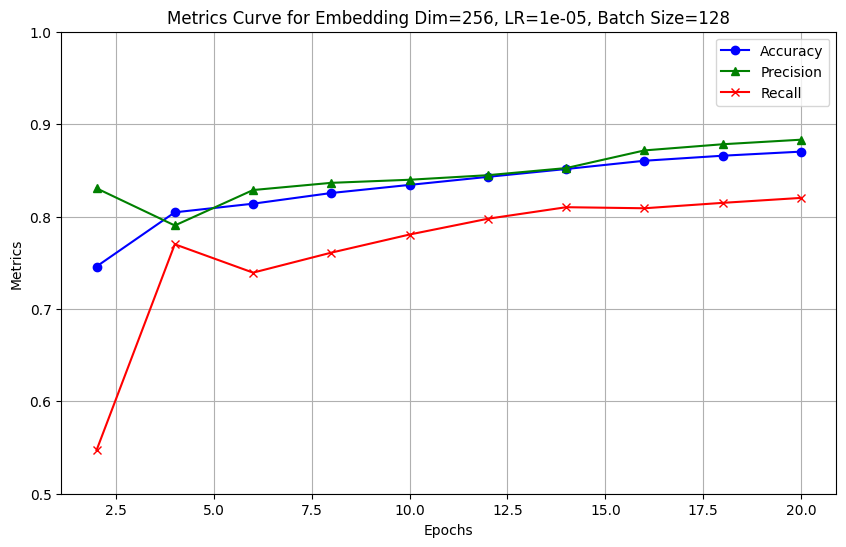



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 2e-05:

Optimal Accuracy: 0.8772 at Epoch 20
Optimal Precision: 0.8970 at Epoch 20
Optimal Recall: 0.8216 at Epoch 20 



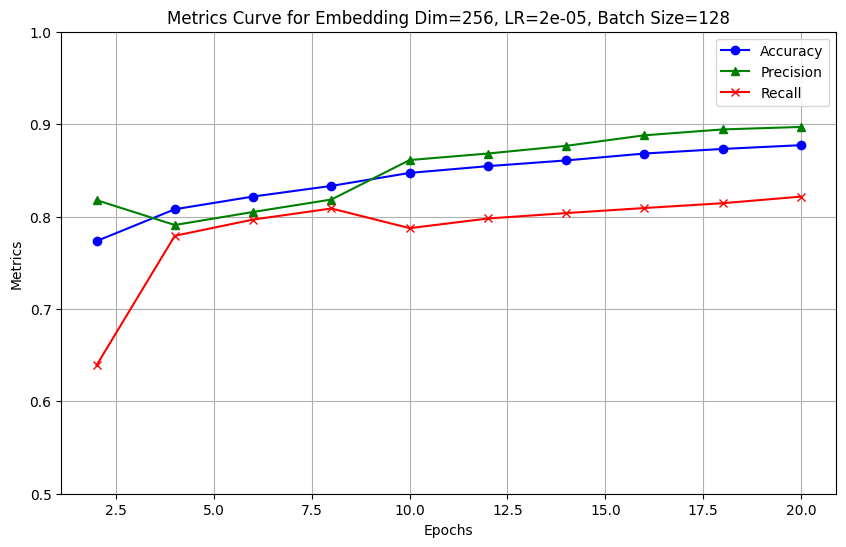



---------------------------------------------------------------------------------------------------- 

Results for Learning Rate = 3e-05:

Optimal Accuracy: 0.8953 at Epoch 20
Optimal Precision: 0.9356 at Epoch 20
Optimal Recall: 0.8277 at Epoch 14 



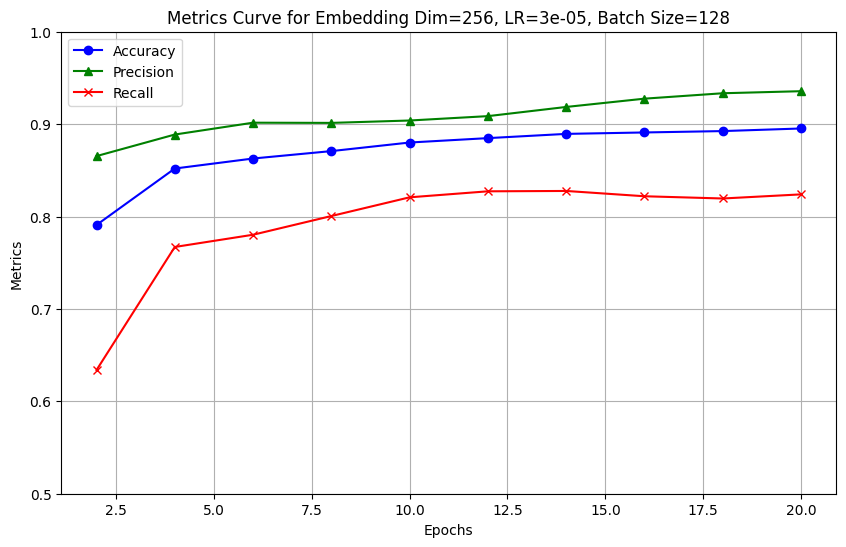



---------------------------------------------------------------------------------------------------- 



In [ ]:
# Path ke log evaluasi
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"  # Pastikan path benar
evaluation_data = pd.read_csv(evaluation_log_path)

# Hyperparameter untuk filter
learning_rates = [1e-5, 2e-5, 3e-5]  # Learning Rate
ED = 256  # Embedding Dimension
BS = 128  # Batch Size

for lr in learning_rates:
    # Filter data evaluasi berdasarkan hyperparameter dan kelipatan epoch
    filtered_data = evaluation_data[
        evaluation_data['Model Name'].str.contains(
            rf"cnn_attention_ed\({ED}\)_lr\({lr}\)_bs\({BS}\)_epoch\(\d+\)", regex=True
        )
    ]

    if filtered_data.empty:
        print(f"No evaluation data found for Learning Rate = {lr}, Embedding Dim = {ED}, Batch Size = {BS}!\n")
        print("----\n")
        continue

    # Buat salinan eksplisit untuk menghindari SettingWithCopyWarning
    filtered_data = filtered_data.copy()

    # Ekstrak epoch dari nama model
    filtered_data['Epoch'] = filtered_data['Model Name'].str.extract(r"epoch\((\d+)\)")[0].astype(int)

    # Sortir berdasarkan epoch
    filtered_data = filtered_data.sort_values('Epoch')

    # Ekstrak kolom yang relevan
    epochs = filtered_data['Epoch']
    accuracy = filtered_data['Accuracy']
    precision_plt = filtered_data['Precision']
    recall_plt = filtered_data['Recall']

    # Ekstrak nama model tanpa epoch
    model_name_without_epoch = filtered_data['Model Name'].iloc[0].split('_epoch(')[0]

    # Cetak hasil terbaik untuk setiap learning rate
    optimal_accuracy_epoch = accuracy.idxmax()
    optimal_precision_epoch = precision_plt.idxmax()
    optimal_recall_epoch = recall_plt.idxmax()

    optimal_accuracy = accuracy.loc[optimal_accuracy_epoch]
    optimal_precision = precision_plt.loc[optimal_precision_epoch]
    optimal_recall = recall_plt.loc[optimal_recall_epoch]

    print(f"Results for Learning Rate = {lr}:\n")
    print(f"Optimal Accuracy: {optimal_accuracy:.4f} at Epoch {epochs.loc[optimal_accuracy_epoch]}")
    print(f"Optimal Precision: {optimal_precision:.4f} at Epoch {epochs.loc[optimal_precision_epoch]}")
    print(f"Optimal Recall: {optimal_recall:.4f} at Epoch {epochs.loc[optimal_recall_epoch]} \n")

    # Plot Accuracy, F1-Score, Precision, dan Recall dalam satu kurva
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
    plt.plot(epochs, precision_plt, marker='^', label='Precision', color='green')
    plt.plot(epochs, recall_plt, marker='x', label='Recall', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0.5, 1.0)
    plt.title(f'Metrics Curve for Embedding Dim={ED}, LR={lr}, Batch Size={BS}')
    plt.grid()
    plt.legend()
    plt.show()

    print("\n")  # Tambahkan spasi antar plot

    print("----" * 25, "\n")


# 6. Hasil Pengujian (Custom )

## Embedding dimension

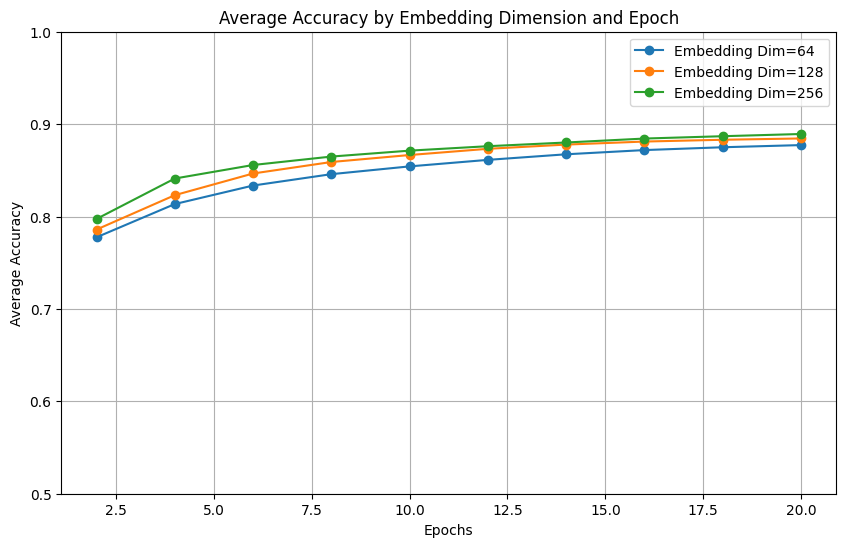

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/average_accuracy_by_embedding_dimension.png


In [ ]:
# Path ke log evaluasi dan lokasi untuk menyimpan grafik
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"
save_path = "/content/drive/MyDrive/Grafik Hasil Pengujian/"

# Membaca data evaluasi
evaluation_data = pd.read_csv(evaluation_log_path)

# Proposed Hyperparameters
embedding_dims = [64, 128, 256]
num_epochs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

# Pastikan direktori penyimpanan ada
os.makedirs(save_path, exist_ok=True)

# Loop through each embedding dimension
plt.figure(figsize=(10, 6))
for ed in embedding_dims:
    avg_accuracies = []
    for epoch in num_epochs:
        # Filter data based on embedding dimension and epoch
        filtered_data = evaluation_data[
            evaluation_data['Model Name'].str.contains(
                rf"cnn_attention_ed\({ed}\)_lr\(\d+e-\d+\)_bs\(\d+\)_epoch\({epoch}\)", regex=True
            )
        ]

        if not filtered_data.empty:
            # Calculate average accuracy for the specific embedding dimension and epoch
            mean_accuracy = filtered_data['Accuracy'].mean()
            avg_accuracies.append(mean_accuracy)
        else:
            avg_accuracies.append(None)  # Handle missing data

    # Plot average accuracy by epoch for the current embedding dimension
    plt.plot(num_epochs, avg_accuracies, marker='o', label=f'Embedding Dim={ed}')

# Configure and save the plot
plt.xlabel('Epochs')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy by Embedding Dimension and Epoch')
plt.legend()
plt.grid()
plt.ylim(0.5, 1.0)
plot_path = os.path.join(save_path, 'average_accuracy_by_embedding_dimension.png')
plt.savefig(plot_path)
plt.show()

print(f"Plot saved at: {plot_path}")


## Batch Size pada Embedding Dimension

### 64

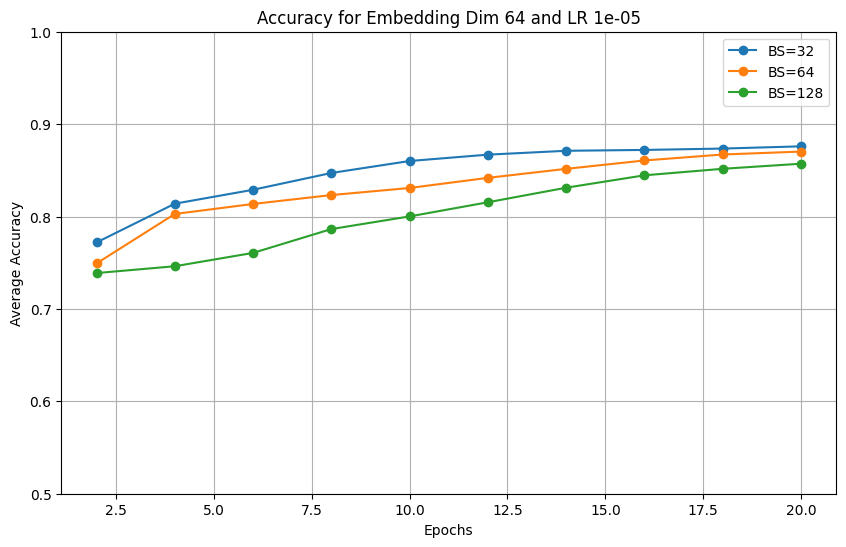

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_64_lr_1e-05.png


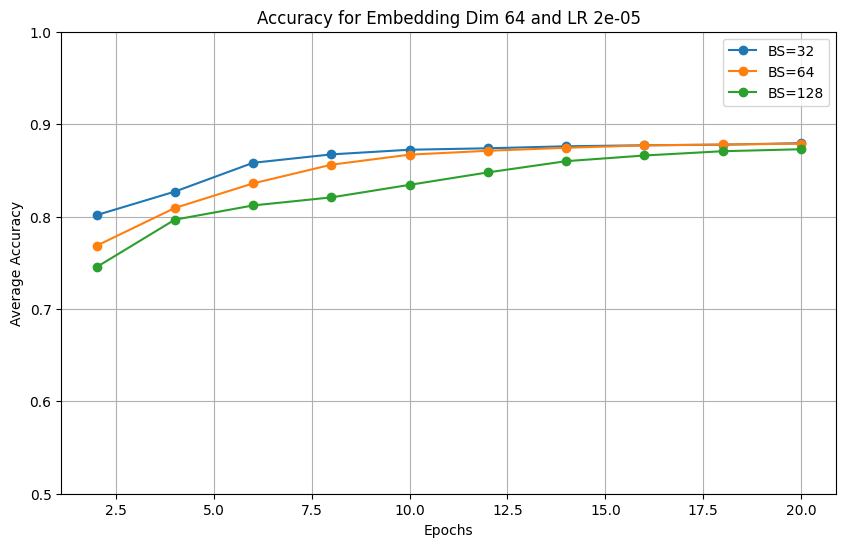

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_64_lr_2e-05.png


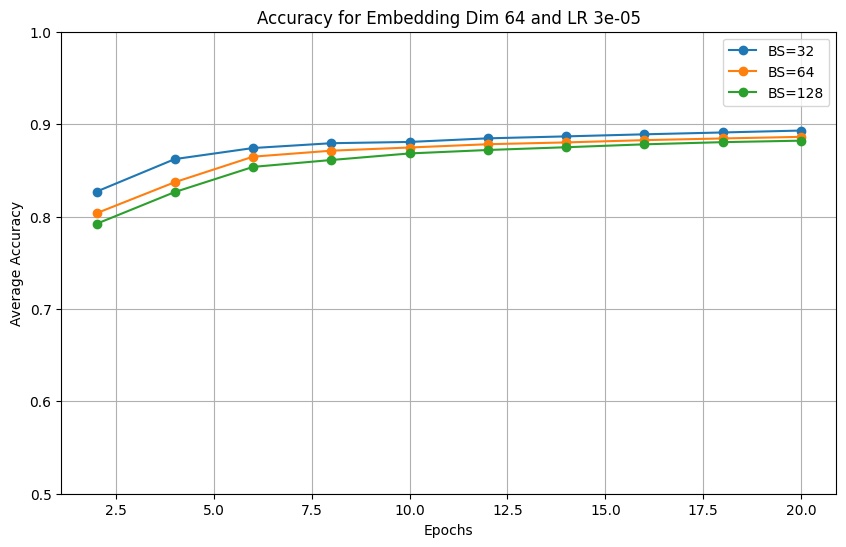

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_64_lr_3e-05.png
Full LaTeX table saved to /content/drive/MyDrive/Latex/results_ed(64).tex


In [ ]:
# Path ke log evaluasi dan lokasi untuk menyimpan grafik
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"
save_path = "/content/drive/MyDrive/Grafik Hasil Pengujian/"

# Membaca data evaluasi
evaluation_data = pd.read_csv(evaluation_log_path)

# Parameter yang ditentukan
embedding_dim = 64
num_epochs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [32, 64, 128]

# Pastikan direktori penyimpanan ada
os.makedirs(save_path, exist_ok=True)

# Loop untuk setiap learning rate
for lr in learning_rates:
    plt.figure(figsize=(10, 6))
    for bs in batch_sizes:
        avg_accuracies = []
        for epoch in num_epochs:
            # Filter data berdasarkan embedding dimension, epoch, learning rate, dan batch size
            filtered_data = evaluation_data[
                evaluation_data['Model Name'].str.contains(
                    rf"cnn_attention_ed\({embedding_dim}\)_lr\({lr:.0e}\)_bs\({bs}\)_epoch\({epoch}\)", regex=True
                )
            ]

            if not filtered_data.empty:
                # Hitung rata-rata akurasi untuk kombinasi tertentu
                mean_accuracy = filtered_data['Accuracy'].mean()
                avg_accuracies.append(mean_accuracy)
            else:
                avg_accuracies.append(None)  # Tangani data yang hilang

        # Plot rata-rata akurasi berdasarkan epoch untuk batch size tertentu
        plt.plot(num_epochs, avg_accuracies, marker='o', label=f'BS={bs}')

    # Konfigurasi plot
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy for Embedding Dim {embedding_dim} and LR {lr:.0e}')
    plt.legend()
    plt.grid()
    plt.ylim(0.5, 1.0)

    # Simpan plot
    plot_path = os.path.join(save_path, f'accuracy_embedding_{embedding_dim}_lr_{lr:.0e}.png')
    plt.savefig(plot_path)
    plt.show()

    print(f"Plot saved at: {plot_path}")

# Filter dan simpan data hasil uji ke dalam LaTeX table
filtered_results = []

# Iterasi untuk setiap kombinasi parameter
for lr in learning_rates:
    for bs in batch_sizes:
        for epoch in num_epochs:
            # Filter data berdasarkan kondisi
            filtered_data = evaluation_data[
                evaluation_data['Model Name'].str.contains(
                    rf"cnn_attention_ed\({embedding_dim}\)_lr\({lr:.0e}\)_bs\({bs}\)_epoch\({epoch}\)", regex=True
                )
            ]
            if not filtered_data.empty:
                # Ekstraksi metrik yang relevan
                accuracy = filtered_data['Accuracy'].mean()
                precision = filtered_data['Precision'].mean()
                recall = filtered_data['Recall'].mean()

                filtered_results.append({
                    'Embedding Dimension': embedding_dim,
                    'Learning Rate': f"{lr:.1e}",
                    'Batch Size': bs,
                    'Epoch': epoch,
                    'Akurasi': f"{accuracy * 100:.2f}%",
                    'Presisi': f"{precision * 100:.2f}%",
                    'Recall': f"{recall * 100:.2f}%"
                })

# Konversi hasil ke DataFrame
filtered_results_df = pd.DataFrame(filtered_results)

# Format ke LaTeX table
latex_table = filtered_results_df.to_latex(
    index=False,
    float_format="%.4f",  # Format untuk kolom lainnya
    caption="Hasil Pengujian Batch Size pada Embedding Dimension 64",
    label="tab:batch_size_results"
)

# Simpan LaTeX table ke file
latex_table_path = "/content/drive/MyDrive/Latex/results_ed(64).tex"
os.makedirs(os.path.dirname(latex_table_path), exist_ok=True)
with open(latex_table_path, "w") as file:
    file.write(latex_table)

print(f"Full LaTeX table saved to {latex_table_path}")


### 128

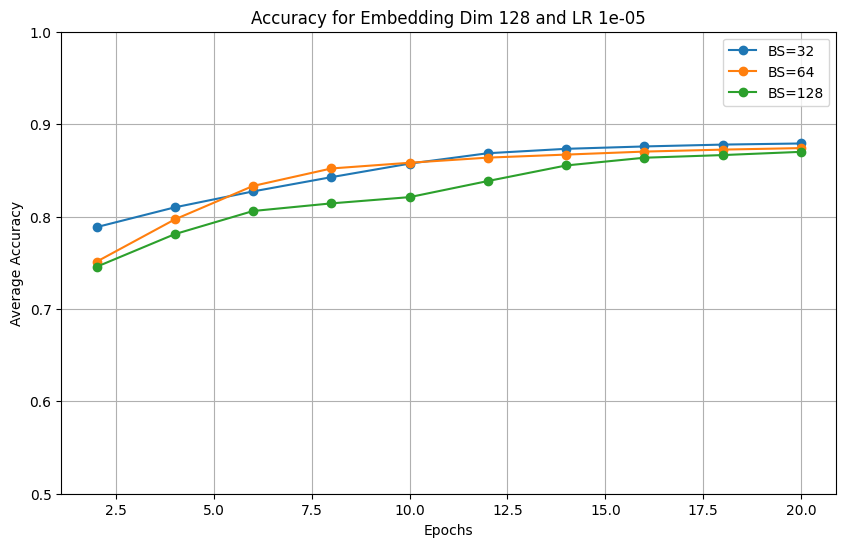

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_128_lr_1e-05.png


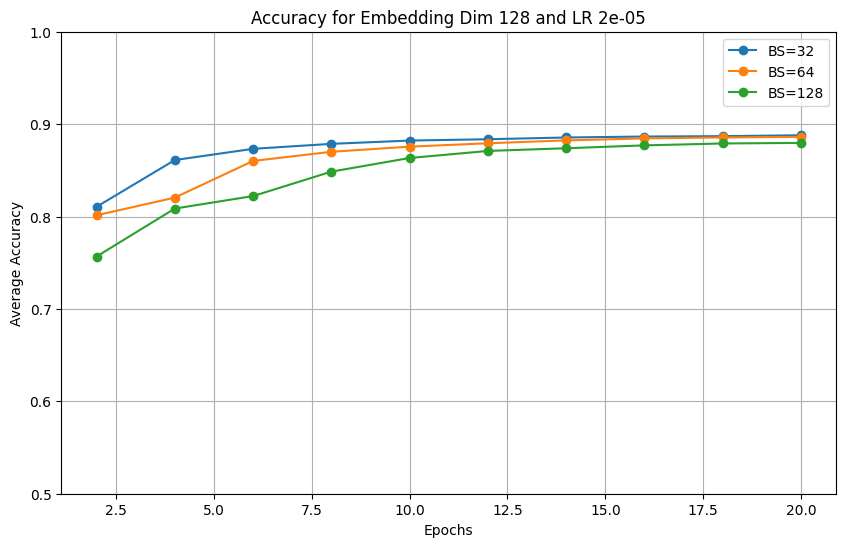

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_128_lr_2e-05.png


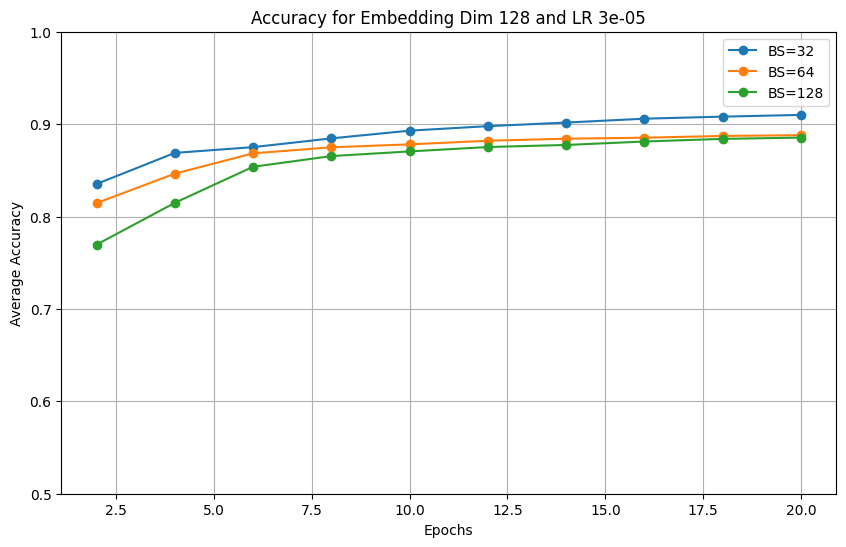

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_128_lr_3e-05.png
Full LaTeX table saved to /content/drive/MyDrive/Latex/results_ed(128).tex


In [ ]:
# Path ke log evaluasi dan lokasi untuk menyimpan grafik
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"
save_path = "/content/drive/MyDrive/Grafik Hasil Pengujian/"

# Membaca data evaluasi
evaluation_data = pd.read_csv(evaluation_log_path)

# Parameter yang ditentukan
embedding_dim = 128
num_epochs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [32, 64, 128]

# Pastikan direktori penyimpanan ada
os.makedirs(save_path, exist_ok=True)

# Loop untuk setiap learning rate
for lr in learning_rates:
    plt.figure(figsize=(10, 6))
    for bs in batch_sizes:
        avg_accuracies = []
        for epoch in num_epochs:
            # Filter data berdasarkan embedding dimension, epoch, learning rate, dan batch size
            filtered_data = evaluation_data[
                evaluation_data['Model Name'].str.contains(
                    rf"cnn_attention_ed\({embedding_dim}\)_lr\({lr:.0e}\)_bs\({bs}\)_epoch\({epoch}\)", regex=True
                )
            ]

            if not filtered_data.empty:
                # Hitung rata-rata akurasi untuk kombinasi tertentu
                mean_accuracy = filtered_data['Accuracy'].mean()
                avg_accuracies.append(mean_accuracy)
            else:
                avg_accuracies.append(None)  # Tangani data yang hilang

        # Plot rata-rata akurasi berdasarkan epoch untuk batch size tertentu
        plt.plot(num_epochs, avg_accuracies, marker='o', label=f'BS={bs}')

    # Konfigurasi plot
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy for Embedding Dim {embedding_dim} and LR {lr:.0e}')
    plt.legend()
    plt.grid()
    plt.ylim(0.5, 1.0)

    # Simpan plot
    plot_path = os.path.join(save_path, f'accuracy_embedding_{embedding_dim}_lr_{lr:.0e}.png')
    plt.savefig(plot_path)
    plt.show()

    print(f"Plot saved at: {plot_path}")

# Filter dan simpan data hasil uji ke dalam LaTeX table
filtered_results = []

# Iterasi untuk setiap kombinasi parameter
for lr in learning_rates:
    for bs in batch_sizes:
        for epoch in num_epochs:
            # Filter data berdasarkan kondisi
            filtered_data = evaluation_data[
                evaluation_data['Model Name'].str.contains(
                    rf"cnn_attention_ed\({embedding_dim}\)_lr\({lr:.0e}\)_bs\({bs}\)_epoch\({epoch}\)", regex=True
                )
            ]
            if not filtered_data.empty:
                # Ekstraksi metrik yang relevan
                accuracy = filtered_data['Accuracy'].mean()
                precision = filtered_data['Precision'].mean()
                recall = filtered_data['Recall'].mean()

                filtered_results.append({
                    'Embedding Dimension': embedding_dim,
                    'Learning Rate': f"{lr:.1e}",
                    'Batch Size': bs,
                    'Epoch': epoch,
                    'Akurasi': f"{accuracy * 100:.2f}%",
                    'Presisi': f"{precision * 100:.2f}%",
                    'Recall': f"{recall * 100:.2f}%"
                })

# Konversi hasil ke DataFrame
filtered_results_df = pd.DataFrame(filtered_results)

# Format ke LaTeX table
latex_table = filtered_results_df.to_latex(
    index=False,
    float_format="%.4f",  # Format untuk kolom lainnya
    caption="Hasil Pengujian Batch Size pada Embedding Dimension 128",
    label="tab:batch_size_results"
)

# Simpan LaTeX table ke file
latex_table_path = "/content/drive/MyDrive/Latex/results_ed(128).tex"
os.makedirs(os.path.dirname(latex_table_path), exist_ok=True)
with open(latex_table_path, "w") as file:
    file.write(latex_table)

print(f"Full LaTeX table saved to {latex_table_path}")


### 256

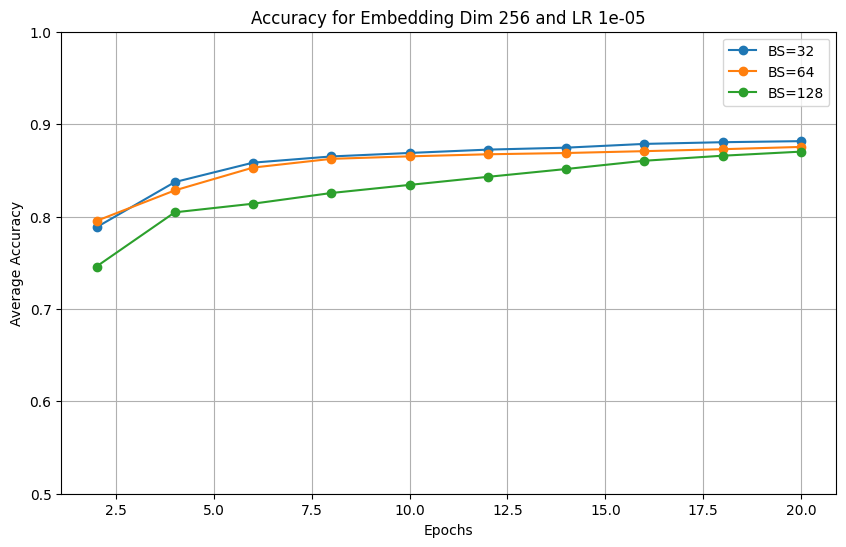

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_256_lr_1e-05.png


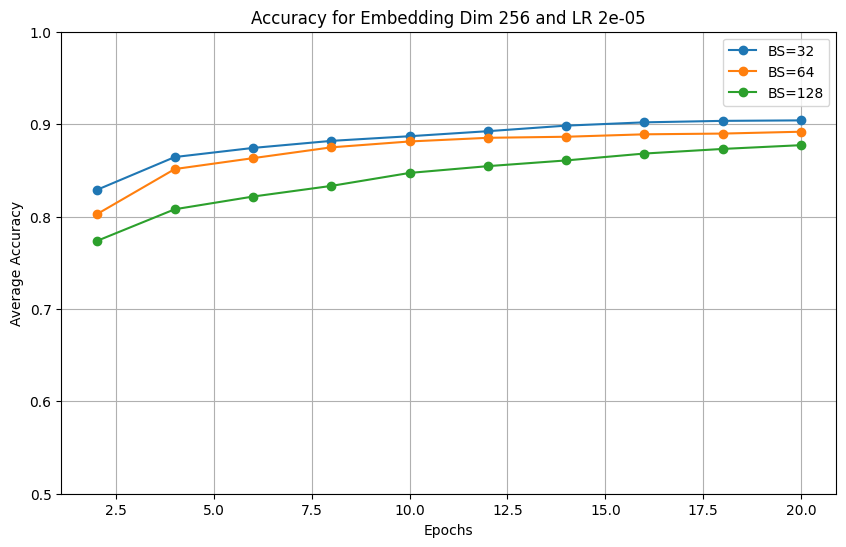

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_256_lr_2e-05.png


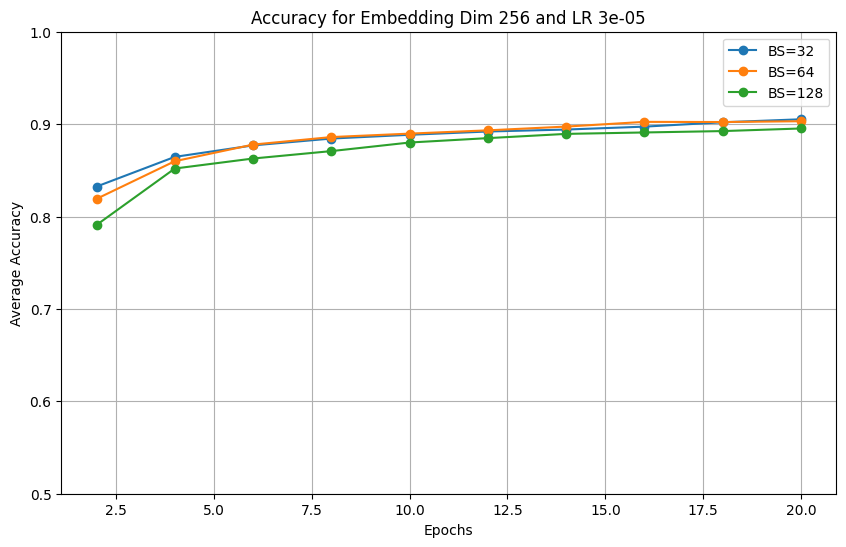

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_256_lr_3e-05.png
Full LaTeX table saved to /content/drive/MyDrive/Latex/results_ed(256).tex


In [ ]:
# Path ke log evaluasi dan lokasi untuk menyimpan grafik
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"
save_path = "/content/drive/MyDrive/Grafik Hasil Pengujian/"

# Membaca data evaluasi
evaluation_data = pd.read_csv(evaluation_log_path)

# Parameter yang ditentukan
embedding_dim = 256
num_epochs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [32, 64, 128]

# Pastikan direktori penyimpanan ada
os.makedirs(save_path, exist_ok=True)

# Loop untuk setiap learning rate
for lr in learning_rates:
    plt.figure(figsize=(10, 6))
    for bs in batch_sizes:
        avg_accuracies = []
        for epoch in num_epochs:
            # Filter data berdasarkan embedding dimension, epoch, learning rate, dan batch size
            filtered_data = evaluation_data[
                evaluation_data['Model Name'].str.contains(
                    rf"cnn_attention_ed\({embedding_dim}\)_lr\({lr:.0e}\)_bs\({bs}\)_epoch\({epoch}\)", regex=True
                )
            ]

            if not filtered_data.empty:
                # Hitung rata-rata akurasi untuk kombinasi tertentu
                mean_accuracy = filtered_data['Accuracy'].mean()
                avg_accuracies.append(mean_accuracy)
            else:
                avg_accuracies.append(None)  # Tangani data yang hilang

        # Plot rata-rata akurasi berdasarkan epoch untuk batch size tertentu
        plt.plot(num_epochs, avg_accuracies, marker='o', label=f'BS={bs}')

    # Konfigurasi plot
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy for Embedding Dim {embedding_dim} and LR {lr:.0e}')
    plt.legend()
    plt.grid()
    plt.ylim(0.5, 1.0)

    # Simpan plot
    plot_path = os.path.join(save_path, f'accuracy_embedding_{embedding_dim}_lr_{lr:.0e}.png')
    plt.savefig(plot_path)
    plt.show()

    print(f"Plot saved at: {plot_path}")

# Filter dan simpan data hasil uji ke dalam LaTeX table
filtered_results = []

# Iterasi untuk setiap kombinasi parameter
for lr in learning_rates:
    for bs in batch_sizes:
        for epoch in num_epochs:
            # Filter data berdasarkan kondisi
            filtered_data = evaluation_data[
                evaluation_data['Model Name'].str.contains(
                    rf"cnn_attention_ed\({embedding_dim}\)_lr\({lr:.0e}\)_bs\({bs}\)_epoch\({epoch}\)", regex=True
                )
            ]
            if not filtered_data.empty:
                # Ekstraksi metrik yang relevan
                accuracy = filtered_data['Accuracy'].mean()
                precision = filtered_data['Precision'].mean()
                recall = filtered_data['Recall'].mean()

                filtered_results.append({
                    'Embedding Dimension': embedding_dim,
                    'Learning Rate': f"{lr:.1e}",
                    'Batch Size': bs,
                    'Epoch': epoch,
                    'Akurasi': f"{accuracy * 100:.2f}%",
                    'Presisi': f"{precision * 100:.2f}%",
                    'Recall': f"{recall * 100:.2f}%"
                })

# Konversi hasil ke DataFrame
filtered_results_df = pd.DataFrame(filtered_results)

# Format ke LaTeX table
latex_table = filtered_results_df.to_latex(
    index=False,
    float_format="%.4f",  # Format untuk kolom lainnya
    caption="Hasil Pengujian Batch Size pada Embedding Dimension 256",
    label="tab:batch_size_results"
)

# Simpan LaTeX table ke file
latex_table_path = "/content/drive/MyDrive/Latex/results_ed(256).tex"
os.makedirs(os.path.dirname(latex_table_path), exist_ok=True)
with open(latex_table_path, "w") as file:
    file.write(latex_table)

print(f"Full LaTeX table saved to {latex_table_path}")


## Learning Rate pada Embedding Dimension

### 64

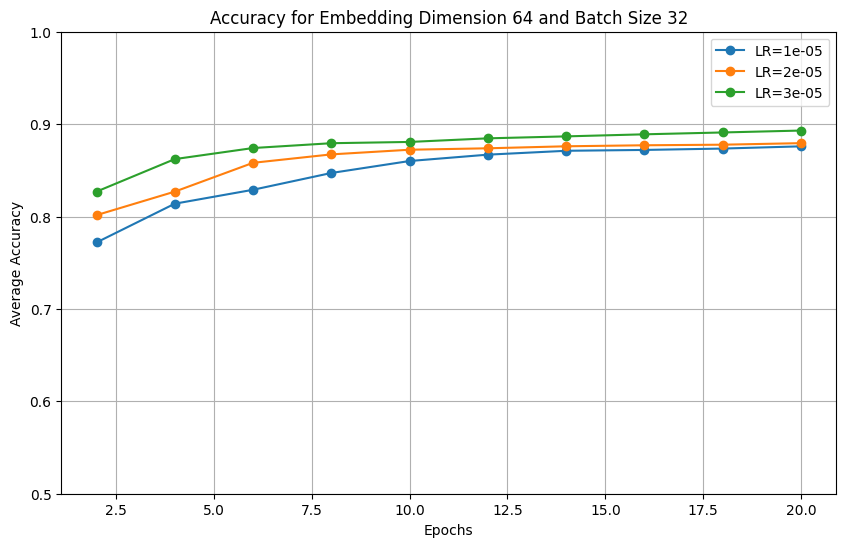

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_dim64_batch_size32.png


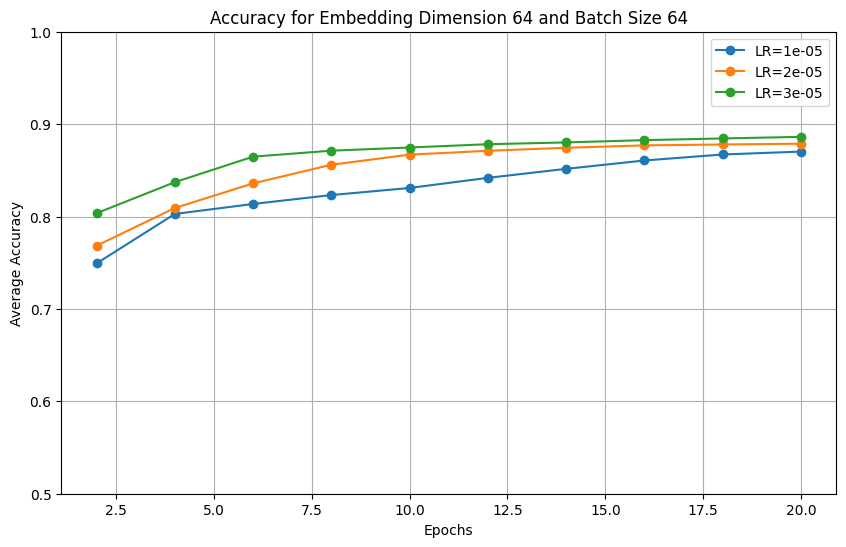

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_dim64_batch_size64.png


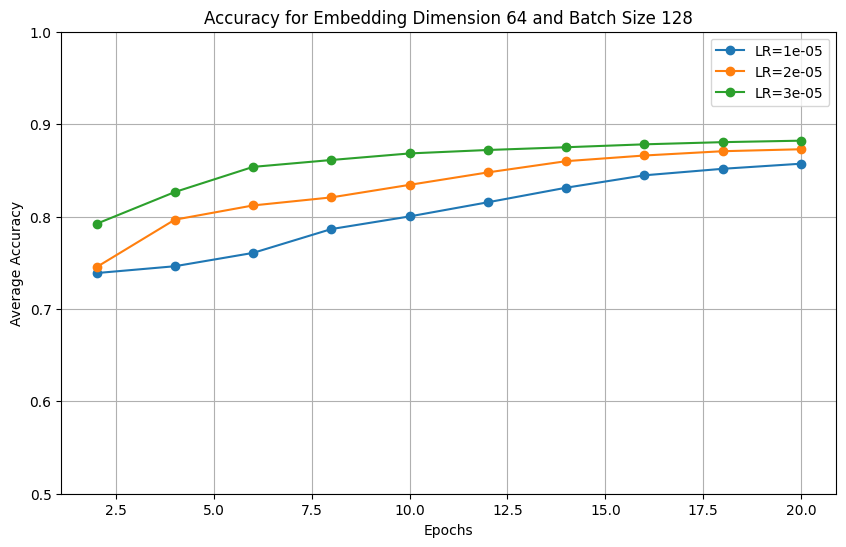

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_dim64_batch_size128.png


In [ ]:
# Path ke log evaluasi dan lokasi untuk menyimpan grafik
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"
save_path = "/content/drive/MyDrive/Grafik Hasil Pengujian/"

# Membaca data evaluasi
evaluation_data = pd.read_csv(evaluation_log_path)

# Parameter yang ditentukan
embedding_dim = 64
num_epochs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [32, 64, 128]

# Pastikan direktori penyimpanan ada
os.makedirs(save_path, exist_ok=True)

# Loop untuk setiap batch size
for bs in batch_sizes:
    plt.figure(figsize=(10, 6))
    for lr in learning_rates:
        avg_accuracies = []
        for epoch in num_epochs:
            # Filter data berdasarkan embedding dimension, epoch, learning rate, dan batch size
            filtered_data = evaluation_data[
                evaluation_data['Model Name'].str.contains(
                    rf"cnn_attention_ed\({embedding_dim}\)_lr\({lr:.0e}\)_bs\({bs}\)_epoch\({epoch}\)", regex=True
                )
            ]

            if not filtered_data.empty:
                # Hitung rata-rata akurasi untuk kombinasi tertentu
                mean_accuracy = filtered_data['Accuracy'].mean()
                avg_accuracies.append(mean_accuracy)
            else:
                avg_accuracies.append(None)  # Tangani data yang hilang

        # Plot rata-rata akurasi berdasarkan epoch untuk learning rate tertentu
        plt.plot(num_epochs, avg_accuracies, marker='o', label=f'LR={lr:.0e}')

    # Konfigurasi plot
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy for Embedding Dimension {embedding_dim} and Batch Size {bs}')
    plt.legend()
    plt.grid()
    plt.ylim(0.5, 1.0)

    # Simpan plot
    plot_path = os.path.join(save_path, f'accuracy_embedding_dim{embedding_dim}_batch_size{bs}.png')
    plt.savefig(plot_path)
    plt.show()

    print(f"Plot saved at: {plot_path}")


###128

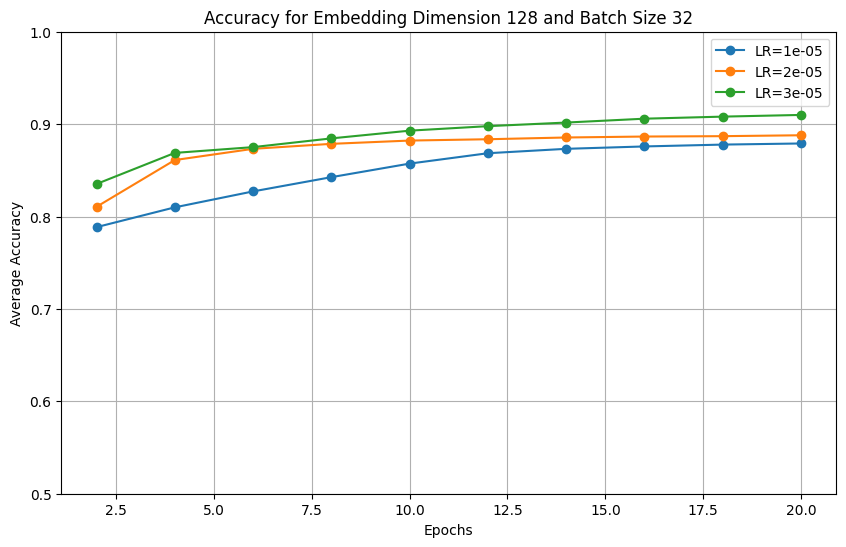

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_dim128_batch_size32.png


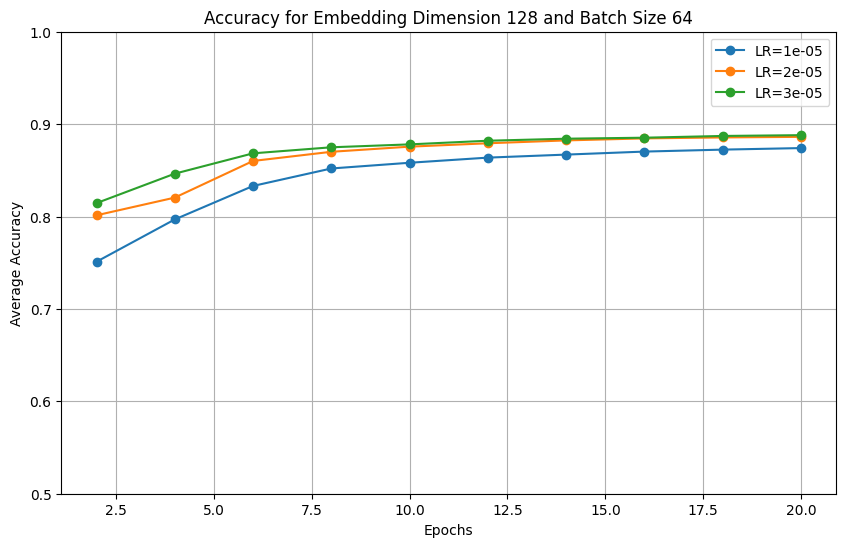

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_dim128_batch_size64.png


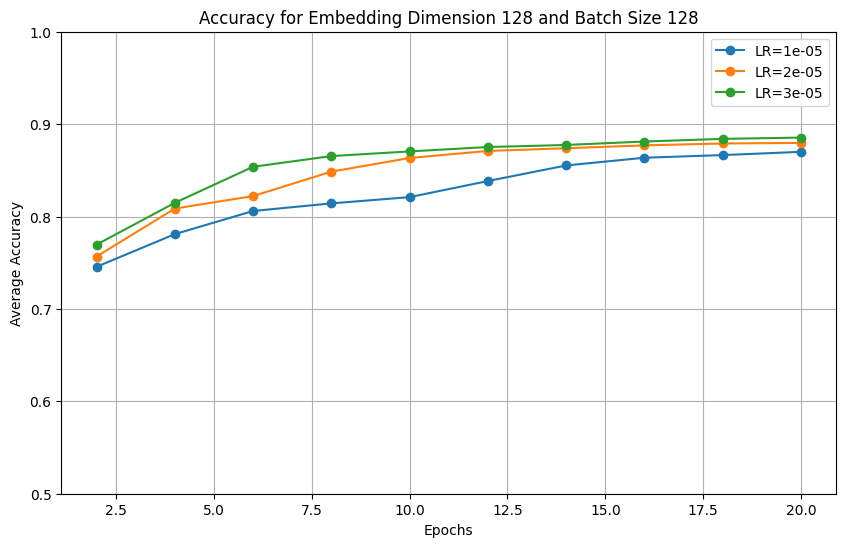

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_dim128_batch_size128.png


In [ ]:
# Path ke log evaluasi dan lokasi untuk menyimpan grafik
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"
save_path = "/content/drive/MyDrive/Grafik Hasil Pengujian/"

# Membaca data evaluasi
evaluation_data = pd.read_csv(evaluation_log_path)

# Parameter yang ditentukan
embedding_dim = 128
num_epochs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [32, 64, 128]

# Pastikan direktori penyimpanan ada
os.makedirs(save_path, exist_ok=True)

# Loop untuk setiap batch size
for bs in batch_sizes:
    plt.figure(figsize=(10, 6))
    for lr in learning_rates:
        avg_accuracies = []
        for epoch in num_epochs:
            # Filter data berdasarkan embedding dimension, epoch, learning rate, dan batch size
            filtered_data = evaluation_data[
                evaluation_data['Model Name'].str.contains(
                    rf"cnn_attention_ed\({embedding_dim}\)_lr\({lr:.0e}\)_bs\({bs}\)_epoch\({epoch}\)", regex=True
                )
            ]

            if not filtered_data.empty:
                # Hitung rata-rata akurasi untuk kombinasi tertentu
                mean_accuracy = filtered_data['Accuracy'].mean()
                avg_accuracies.append(mean_accuracy)
            else:
                avg_accuracies.append(None)  # Tangani data yang hilang

        # Plot rata-rata akurasi berdasarkan epoch untuk learning rate tertentu
        plt.plot(num_epochs, avg_accuracies, marker='o', label=f'LR={lr:.0e}')

    # Konfigurasi plot
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy for Embedding Dimension {embedding_dim} and Batch Size {bs}')
    plt.legend()
    plt.grid()
    plt.ylim(0.5, 1.0)

    # Simpan plot
    plot_path = os.path.join(save_path, f'accuracy_embedding_dim{embedding_dim}_batch_size{bs}.png')
    plt.savefig(plot_path)
    plt.show()

    print(f"Plot saved at: {plot_path}")


### 256

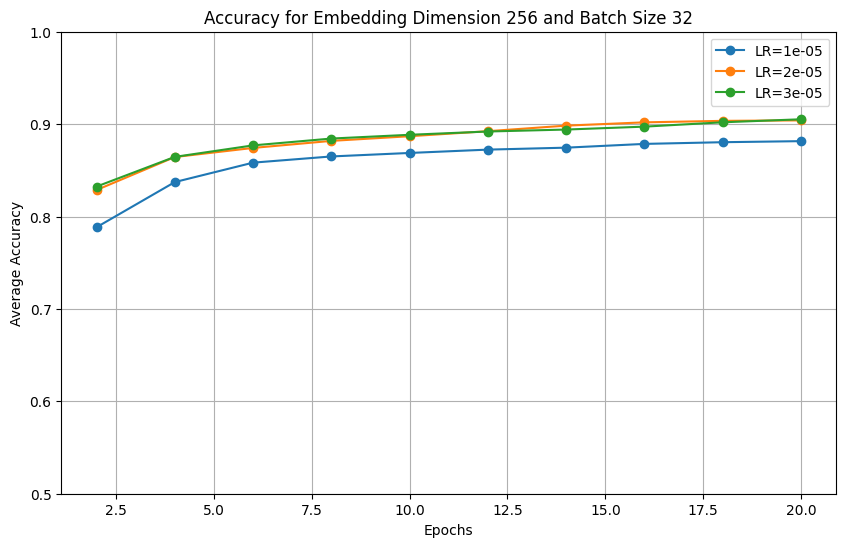

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_dim256_batch_size32.png


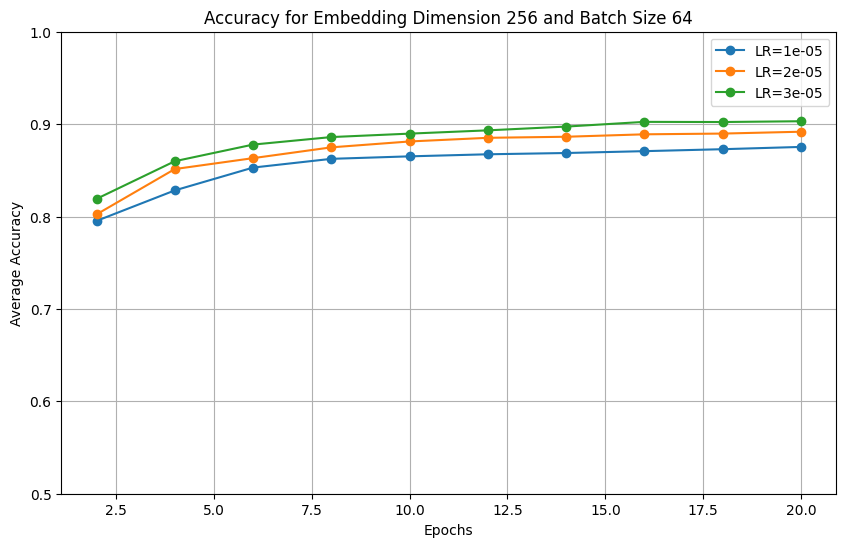

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_dim256_batch_size64.png


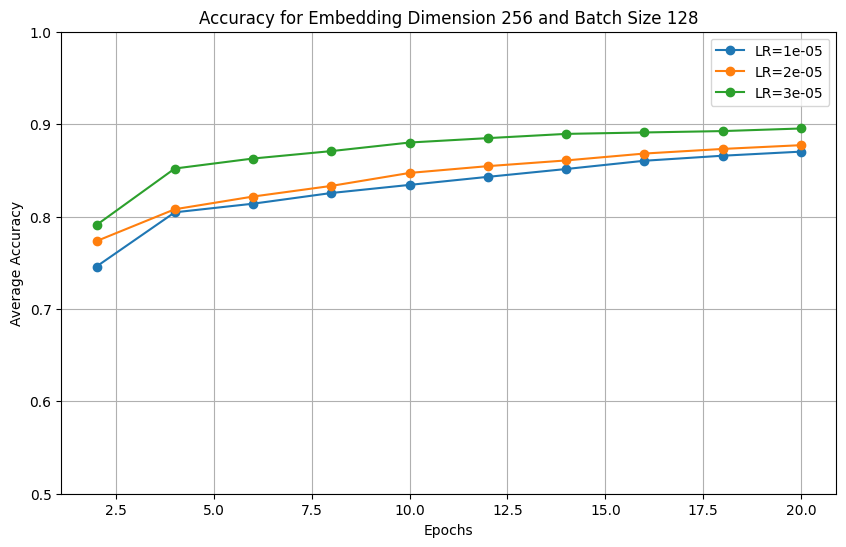

Plot saved at: /content/drive/MyDrive/Grafik Hasil Pengujian/accuracy_embedding_dim256_batch_size128.png


In [ ]:
# Path ke log evaluasi dan lokasi untuk menyimpan grafik
evaluation_log_path = "/content/drive/MyDrive/Log/evaluation_log.csv"
save_path = "/content/drive/MyDrive/Grafik Hasil Pengujian/"

# Membaca data evaluasi
evaluation_data = pd.read_csv(evaluation_log_path)

# Parameter yang ditentukan
embedding_dim = 256
num_epochs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [32, 64, 128]

# Pastikan direktori penyimpanan ada
os.makedirs(save_path, exist_ok=True)

# Loop untuk setiap batch size
for bs in batch_sizes:
    plt.figure(figsize=(10, 6))
    for lr in learning_rates:
        avg_accuracies = []
        for epoch in num_epochs:
            # Filter data berdasarkan embedding dimension, epoch, learning rate, dan batch size
            filtered_data = evaluation_data[
                evaluation_data['Model Name'].str.contains(
                    rf"cnn_attention_ed\({embedding_dim}\)_lr\({lr:.0e}\)_bs\({bs}\)_epoch\({epoch}\)", regex=True
                )
            ]

            if not filtered_data.empty:
                # Hitung rata-rata akurasi untuk kombinasi tertentu
                mean_accuracy = filtered_data['Accuracy'].mean()
                avg_accuracies.append(mean_accuracy)
            else:
                avg_accuracies.append(None)  # Tangani data yang hilang

        # Plot rata-rata akurasi berdasarkan epoch untuk learning rate tertentu
        plt.plot(num_epochs, avg_accuracies, marker='o', label=f'LR={lr:.0e}')

    # Konfigurasi plot
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy for Embedding Dimension {embedding_dim} and Batch Size {bs}')
    plt.legend()
    plt.grid()
    plt.ylim(0.5, 1.0)

    # Simpan plot
    plot_path = os.path.join(save_path, f'accuracy_embedding_dim{embedding_dim}_batch_size{bs}.png')
    plt.savefig(plot_path)
    plt.show()

    print(f"Plot saved at: {plot_path}")


# 7. Start GUI

In [ ]:
# Replace 'YOUR_NGROK_AUTH_TOKEN' with your actual ngrok authtoken
ngrok.set_auth_token("2Xp4L8dJ0OIdDbRNAV4lDzyOGW2_2rpX1G7P44vMTg3ipfP2D")
public_url = ngrok.connect(5000)

gui = GUI()
gui.start_gui()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://ee2d-34-105-15-206.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 13:17:33] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 13:17:34] "GET /static/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 13:17:35] "GET /static/images/bg.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 13:17:37] "GET /favicon.ico HTTP/1.1" 404 -


Loading model from: /content/drive/MyDrive/Model/cnn_attention_ed(128)_lr(3e-05)_bs(32)_epoch(20).keras
Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 13:17:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 13:17:56] "GET /static/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 13:17:56] "GET /static/images/bg.jpg HTTP/1.1" 304 -


Loading model from: /content/drive/MyDrive/Model/cnn_attention_ed(128)_lr(3e-05)_bs(32)_epoch(20).keras
Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 13:18:12] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 13:18:13] "GET /static/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 13:18:13] "GET /static/images/bg.jpg HTTP/1.1" 304 -


Loading model from: /content/drive/MyDrive/Model/cnn_attention_ed(128)_lr(3e-05)_bs(32)_epoch(20).keras
Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 14:03:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 14:03:46] "GET /static/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 14:03:46] "GET /static/images/bg.jpg HTTP/1.1" 304 -


Loading model from: /content/drive/MyDrive/Model/cnn_attention_ed(128)_lr(3e-05)_bs(32)_epoch(20).keras
Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 14:04:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 14:04:11] "GET /static/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [23/Dec/2024 14:04:12] "GET /static/images/bg.jpg HTTP/1.1" 304 -
